In [1]:
import numpy as np
import csv
import re

In [4]:
artist_id_file = open("mxm_779k_matches.txt")
msd_name_to_mxm = {} # map MSD artist name to MXM artist name
artist_name_to_tracks = {} # map MXM artist name to list of (MSD, MXM track IDs)

lines = artist_id_file.readlines()
for line in lines:
    if line[0] == '#':
        continue
    terms = re.split('<SEP>', line.rstrip())
    # we know each line is formatted as such:
    # tid|artist name|title|mxm tid|artist_name|title
    msd_name_to_mxm[terms[1]] = terms[4]
    if terms[4] in artist_name_to_tracks:
        artist_name_to_tracks[terms[4]] += (terms[0], terms[3])
    else:
        artist_name_to_tracks[terms[4]] = [(terms[0], terms[3])]
    
artist_id_file.close()

In [6]:
def construct_track_to_words(lines):
    track_to_words = {} # maps MSD track ID to np.array of word counts, indexed by all_words
    all_words = []
    for line in lines:
        if line[0] == '#':
            continue
        if line[0] == '%':
            all_words = re.split(',', line[1:].rstrip())
            continue
        content = re.split(',', line.rstrip())
        # know that lines are formatted as TID,MXMID,idx:cnt,idx:cnt,...
        word_counts = np.zeros(len(all_words))
        for term in content[2:]:
            index, count = re.split(':', term)
            index, count = int(index), int(count)
            word_counts[index-1] = count
        track_to_words[content[0]] = word_counts
    return all_words, track_to_words

In [7]:
words_dataset = open("mxm_dataset_train.txt")
lines = words_dataset.readlines()
all_words, track_to_words = construct_track_to_words(lines)
words_dataset.close()

In [8]:
words_dataset = open("mxm_dataset_test.txt")
lines = words_dataset.readlines()
output = construct_track_to_words(lines)
words_dataset.close()

In [9]:
print(len(track_to_words))
track_to_words.update(output[1])
print(len(track_to_words))

210519
237662


In [10]:
artist_name_to_word_count = {} # maps MXM artist name to np array of word count

for artist in artist_name_to_tracks:
    word_counts = np.zeros(len(all_words))
    for track_id in artist_name_to_tracks[artist]:
        track_id = track_id[0]
        if track_id in track_to_words:
            word_counts += track_to_words[track_id]
    artist_name_to_word_count[artist] = word_counts

In [11]:
artists_in_dataset = [name for name in artist_name_to_word_count if np.any(artist_name_to_word_count[name])]

In [12]:
print(len(artists_in_dataset))
print(len(artist_name_to_word_count))

9395
46469


In [13]:
filename = "artist_to_word_count.csv"
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile) 
        
    # writing the fields 
    csvwriter.writerow(['name'] + all_words) 
        
    # writing the data rows 
    for name in artists_in_dataset:
        csvwriter.writerow([name] + list(artist_name_to_word_count[name]))

In [99]:
# !python -m pip install lyricsgenius
from lyricsgenius import Genius
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds

In [22]:
token = 'M4ryjx_Lsw6ivDYBJDstefp269uJrax2fYcntlBjYDRvH70j0jNrj67xaE8q66M0'
genius = Genius(token, remove_section_headers=True, timeout=20)
genius.remove_section_headers = True

In [23]:
df = pd.read_csv('../compiled-data-filtered.csv')
artists = df['Artist']

In [25]:
artist_songs = {}
for artist in artists[:10]:
    artist_songs[artist] = genius.search_artist(artist, max_songs=5)

Searching for songs by "Cats" 1981 Original London Cast...

Changing artist name to 'Cats Original London Cast (1981)'
Done. Found 0 songs.
Searching for songs by "Weird Al" Yankovic...

Changing artist name to '“Weird Al” Yankovic'
Song 1: "Amish Paradise"
Song 2: "Word Crimes"
Song 3: "Tacky"
Song 4: "White & Nerdy"
Song 5: "The Saga Begins"

Reached user-specified song limit (5).
Done. Found 5 songs.
Searching for songs by $NOT...

Song 1: "GOSHA"
Song 2: "Moon & Stars"
Song 3: "BERETTA"
Song 4: "MEGAN"
Song 5: "Excuse Me"

Reached user-specified song limit (5).
Done. Found 5 songs.
Searching for songs by $atori Zoom...

Song 1: "BUSTER"
Song 2: "RIPSTICK"
Song 3: "LOCK OUT"
Song 4: "REVENGE"
Song 5: "Honey"

Reached user-specified song limit (5).
Done. Found 5 songs.
Searching for songs by $uicideBoy$...

Changing artist name to '$UICIDEBOY$'
Song 1: "Kill Yourself (Part III)"
Song 2: "Paris"
Song 3: "2nd Hand"
Song 4: "Antarctica"
Song 5: "I No Longer Fear the Razor Guarding My He

In [115]:
df2 = pd.read_csv('../compiled-w-songs.csv')
artists2 = df2[['Artist', 'Songs']]

In [116]:
artists_songs2 = dict(zip(artists2['Artist'], artists2['Songs']))
for artist in artists_songs2:
    songs = artists_songs2[artist].replace('"', "'").strip("'[]").split("', '")
    artists_songs2[artist] = songs

In [117]:
song_lyrics = {}
artists2 = list(artists_songs2)

for artist in artists2:
    song_info = []
    for song in artists_songs2[artist]:
        try:
            song_info.append(genius.search_song(song, artist=artist))
        except Exception as e:
            print(song, artist, e)
    song_lyrics[artist] = song_info

Searching for "The Phantom Of the Opera" by "Cats" 1981 Original London Cast...
Done.
Searching for "All I Ask Of You" by "Cats" 1981 Original London Cast...
Done.
Searching for "Think Of Me" by "Cats" 1981 Original London Cast...
Done.
Searching for "The Music Of The Night" by "Cats" 1981 Original London Cast...
Done.
Searching for "Angel Of Music" by "Cats" 1981 Original London Cast...
Done.
Searching for "The Phantom Of The Opera" by "Cats" 1981 Original London Cast...
Done.
Searching for "The Point Of No Return" by "Cats" 1981 Original London Cast...
Done.
Searching for "I Know I Have A Heart" by "Cats" 1981 Original London Cast...
Done.
Searching for "Any Dream Will Do" by "Cats" 1981 Original London Cast...
Done.
Searching for "Wishing You Were Somehow Here Again" by "Cats" 1981 Original London Cast...
Done.
Searching for "Amish Paradise (Parody of 'Gangsta\'s Paradise' by Coolio)" by "Weird Al" Yankovic...
No results found for: 'Amish Paradise (Parody of 'Gangsta\'s Paradise' by

Done.
Searching for "(God Must Have Spent) A Little More Time On You - Remix" by *NSYNC...
Done.
Searching for "Gone" by *NSYNC...
Done.
Searching for "Thinking Of You (I Drive Myself Crazy) - Remix" by *NSYNC...
Done.
Searching for "Girlfriend" by *NSYNC...
Done.
Searching for "Spa Music (Sleeping Music)" by *spandrel...
No results found for: 'Spa Music (Sleeping Music) *spandrel'
Searching for "Spa Music" by *spandrel...
Done.
Searching for "Massage Therapy" by *spandrel...
Done.
Searching for "Meditation Music" by *spandrel...
Done.
Searching for "Spa Music (Massage Therapy)" by *spandrel...
No results found for: 'Spa Music (Massage Therapy) *spandrel'
Searching for "Yoga Music" by *spandrel...
Done.
Searching for "Music for Spa" by *spandrel...
Done.
Searching for "Study Music" by *spandrel...
Done.
Searching for "Relaxation Music" by *spandrel...
Done.
Searching for "Studying Music" by *spandrel...
Done.
Searching for "Substance" by 03 Greedo...
Done.
Searching for "Trap House (fe

Done.
Searching for "Bigger Than You (feat. Drake & Quavo)" by 2 Chainz...
Done.
Searching for "Feel A Way (feat. Kanye West & Brent Faiyaz)" by 2 Chainz...
Done.
Searching for "We Want Some P--sy" by 2 LIVE CREW...
No results found for: 'We Want Some P--sy 2 LIVE CREW'
Searching for "Me So Horny" by 2 LIVE CREW...
Done.
Searching for "Hoochie Mama" by 2 LIVE CREW...
Done.
Searching for "Pop That P--sy" by 2 LIVE CREW...
Done.
Searching for "One And One" by 2 LIVE CREW...
Done.
Searching for "Dirty Nursery Rhymes" by 2 LIVE CREW...
Done.
Searching for "Get It Girl" by 2 LIVE CREW...
Done.
Searching for "Do Wah Diddy" by 2 LIVE CREW...
Done.
Searching for "The F--k Shop" by 2 LIVE CREW...
Done.
Searching for "Throw The 'D" by 2 LIVE CREW...
Done.
Searching for "No limit - RAP VERSION" by 2 Unlimited...
Done.
Searching for "Get Ready - Rapversion Edit" by 2 Unlimited...
Done.
Searching for "Twilight Zone" by 2 Unlimited...
Done.
Searching for "Tribal Dance" by 2 Unlimited...
Done.
Search

Done.
Searching for "Ambitionz Az A Ridah" by 2Pac...
Done.
Searching for "All Eyez On Me (ft. Big Syke)" by 2Pac...
Done.
Searching for "Do For Love" by 2Pac...
Done.
Searching for "Dear Mama" by 2Pac...
Done.
Searching for "Hit 'Em Up - Single Version" by 2Pac...
Done.
Searching for "California Love - Original Version" by 2Pac...
Done.
Searching for "Changes" by 2Pac...
Done.
Searching for "Keep Ya Head Up" by 2Pac...
Done.
Searching for "I Get Around" by 2Pac...
Done.
Searching for "Hail Mary" by 2Pac...
Done.
Searching for "Riches" by 2tone...
Done.
Searching for "North Sac Baby" by 2tone...
No results found for: 'North Sac Baby 2tone'
Searching for "What's Hannin" by 2tone...
No results found for: 'What's Hannin 2tone'
Searching for "El Taliban" by 2tone...
No results found for: 'El Taliban 2tone'
Searching for "Patrullando" by 2tone...
No results found for: 'Patrullando 2tone'
Searching for "Overdose" by 2tone...
Done.
Searching for "Blue Faces" by 2tone...
Done.
Searching for "S

Done.
Searching for "4D" by 4D...
Done.
Searching for "Talking Heads" by 4D...
Done.
Searching for "Refuge" by 4D...
Done.
Searching for "Details Matter" by 4D...
Done.
Searching for "Dispossession" by 4D...
No results found for: 'Dispossession 4D'
Searching for "Freefall" by 4D...
No results found for: 'Freefall 4D'
Searching for "Youngblood" by 5 Seconds of Summer...
Done.
Searching for "Teeth" by 5 Seconds of Summer...
Done.
Searching for "Ghost Of You" by 5 Seconds of Summer...
Done.
Searching for "Who Do You Love" by 5 Seconds of Summer...
Done.
Searching for "Easier" by 5 Seconds of Summer...
Done.
Searching for "She Looks So Perfect" by 5 Seconds of Summer...
Done.
Searching for "Old Me" by 5 Seconds of Summer...
Done.
Searching for "Lie To Me (feat. Julia Michaels)" by 5 Seconds of Summer...
Done.
Searching for "She's Kinda Hot" by 5 Seconds of Summer...
Done.
Searching for "Amnesia" by 5 Seconds of Summer...
Done.
Searching for "What You Know Bout Love" by 50 Cent...
Done.
Sea

Specified song does not contain lyrics. Rejecting.
Searching for "Seven of Nine" by 90sFlav...
Specified song does not contain lyrics. Rejecting.
Searching for "Southlands 94" by 90sFlav...
Specified song does not contain lyrics. Rejecting.
Searching for "Put It On" by 98...
Done.
Searching for "Deadly Combination (feat. 2Pac)" by 98...
Done.
Searching for "The Enemy (feat. Fat Joe)" by 98...
Done.
Searching for "MVP" by 98...
Done.
Searching for "Day One (feat. Big L, A.G., Lord Finesse, & O.C.)" by 98...
No results found for: 'Day One (feat. Big L, A.G., Lord Finesse, & O.C.) 98'
Searching for "98 Freestyle" by 98...
Done.
Searching for "Street Struck" by 98...
Done.
Searching for "Da Graveyard" by 98...
Done.
Searching for "All Black" by 98...
Done.
Searching for "8 Iz Enuff" by 98...
No results found for: '8 Iz Enuff 98'
Searching for "I Do (Cherish You)" by 98º...
No results found for: 'I Do (Cherish You) 98º'
Searching for "The Hardest Thing" by 98º...
No results found for: 'The 

Done.
Searching for "I'm Made Of Wax, Larry, What Are You Made Of?" by A Day To Remember...
Done.
Searching for "Because He Lives" by A Few Good Men...
Done.
Searching for "He Touched Me" by A Few Good Men...
Done.
Searching for "You Are My All In All/Canon In D - Medley" by A Few Good Men...
Done.
Searching for "Chain Breaker" by A Few Good Men...
Done.
Searching for "Sometimes It Takes A Mountain" by A Few Good Men...
Done.
Searching for "Alpha And Omega" by A Few Good Men...
Done.
Searching for "When I Cry" by A Few Good Men...
Done.
Searching for "Jesus Messiah" by A Few Good Men...
Done.
Searching for "At The Cross" by A Few Good Men...
Done.
Searching for "I’ll Fly Away" by A Few Good Men...
Done.
Searching for "I Ran (So Far Away)" by A Flock Of Seagulls...
Done.
Searching for "I Ran (So Far Away)" by A Flock Of Seagulls...
Done.
Searching for "Space Age Love Song" by A Flock Of Seagulls...
Done.
Searching for "The More You Live, The More You Love" by A Flock Of Seagulls...
Done

Done.
Searching for "L$D" by A$AP Rocky...
Done.
Searching for "Everyday (feat. Rod Stewart, Miguel & Mark Ronson)" by A$AP Rocky...
Done.
Searching for "Potato Salad" by A$AP Rocky...
Done.
Searching for "Fukk Sleep (feat. FKA twigs)" by A$AP Rocky...
Done.
Searching for "Babushka Boi" by A$AP Rocky...
Done.
Searching for "BANKROLL (feat. A$AP Rocky & A$AP Ferg)" by A$AP Rocky...
Done.
Searching for "Rich Nigga Problems" by A$AP Rocky...
Done.
Searching for "Upside Down" by A*Teens...
Done.
Searching for "Can\'t Help Falling In Love - From 'Lilo & Stitch'/Soundtrack Version" by A*Teens...
No results found for: 'Can\'t Help Falling In Love - From 'Lilo & Stitch'/Soundtrack Version A*Teens'
Searching for "Mamma Mia" by A*Teens...
Done.
Searching for "Gimme! Gimme! Gimme! (A Man After Midnight)" by A*Teens...
Done.
Searching for "Super Trouper" by A*Teens...
Done.
Searching for "Dancing Queen" by A*Teens...
Done.
Searching for "Halfway Around The World" by A*Teens...
Done.
Searching for 

Done.
Searching for "Ya Lo Sé Que Tú Te Vas" by ABRA...
Done.
Searching for "Caray" by ABRA...
Done.
Searching for "Yo Te Recuerdo - Version Salsa" by ABRA...
Done.
Searching for "Querida" by ABRA...
Done.
Searching for "El Noa Noa" by ABRA...
Done.
Searching for "Back In Black" by AC/DC...
Done.
Searching for "Highway to Hell" by AC/DC...
Done.
Searching for "Thunderstruck" by AC/DC...
Done.
Searching for "You Shook Me All Night Long" by AC/DC...
Done.
Searching for "T.N.T." by AC/DC...
Done.
Searching for "Hells Bells" by AC/DC...
Done.
Searching for "Dirty Deeds Done Dirt Cheap" by AC/DC...
Done.
Searching for "Shoot to Thrill" by AC/DC...
Done.
Searching for "It's a Long Way to the Top (If You Wanna Rock 'N' Roll)" by AC/DC...
Done.
Searching for "Rock N Roll Train" by AC/DC...
Done.
Searching for "Another One Bites The Dust - Remastered 2011" by ACOT...
Done.
Searching for "Bohemian Rhapsody - Remastered 2011" by ACOT...
Done.
Searching for "Don't Stop Me Now - Remastered 2011" by

Done.
Searching for "Good For Me - ALPHA 9 Remix" by ALPHA 9...
Done.
Searching for "All That I Can" by ALPHA 9...
Done.
Searching for "Come Home - Extended Mix" by ALPHA 9...
Done.
Searching for "Stellar" by ALPHA 9...
Done.
Searching for "Empty Streets - ALPHA 9 Remix" by ALPHA 9...
Done.
Searching for "Never Be The Same - ALPHA 9 Remix" by ALPHA 9...
Done.
Searching for "Everywhere I Go" by ALPHA 9...
Done.
Searching for "Before The Dawn - Edit" by ALPHA 9...
Done.
Searching for "All We Need" by ALPHA 9...
Specified song does not contain lyrics. Rejecting.
Searching for "Azzura" by ALPHA 9...
Specified song does not contain lyrics. Rejecting.
Searching for "What You Know Bout Love" by APB...
Done.
Searching for "For The Night (feat. Lil Baby & DaBaby)" by APB...
No results found for: 'For The Night (feat. Lil Baby & DaBaby) APB'
Searching for "Hello (feat. A Boogie Wit da Hoodie)" by APB...
No results found for: 'Hello (feat. A Boogie Wit da Hoodie) APB'
Searching for "Dior" by APB.

Done.
Searching for "Carry On" by AWOLNATION...
Done.
Searching for "Run" by AWOLNATION...
Done.
Searching for "Disco Body Parts (feat. AWOLNATION)" by AWOLNATION...
Done.
Searching for "The Best" by AWOLNATION...
Done.
Searching for "The Best (feat. Alice Merton)" by AWOLNATION...
No results found for: 'The Best (feat. Alice Merton) AWOLNATION'
Searching for "I\'m On Fire - From 'Fifty Shades Of Grey' Soundtrack" by AWOLNATION...
No results found for: 'I\'m On Fire - From 'Fifty Shades Of Grey' Soundtrack AWOLNATION'
Searching for "Kill Your Heroes" by AWOLNATION...
Done.
Searching for "Hollow Moon (Bad Wolf)" by AWOLNATION...
Done.
Searching for "Woman Woman" by AWOLNATION...
Done.
Searching for "Relación - Remix" by AZ...
Done.
Searching for "UN DIA (ONE DAY) (Feat. Tainy)" by AZ...
Done.
Searching for "Una Locura" by AZ...
Done.
Searching for "LOCATION" by AZ...
Done.
Searching for "LA CANCIÓN" by AZ...
Done.
Searching for "Tu Veneno" by AZ...
Done.
Searching for "I Like It" by AZ.

No results found for: 'Those Magic Changes - From 'Grease Live!' Music From The Television Event Aaron Tveit'
Searching for "Summer Nights - From 'Grease Live!' Music From The Television Event" by Aaron Tveit...
No results found for: 'Summer Nights - From 'Grease Live!' Music From The Television Event Aaron Tveit'
Searching for "ABC Café / Red & Black" by Aaron Tveit...
Done.
Searching for "Sandy - From 'Grease Live!' Music From The Television Event" by Aaron Tveit...
No results found for: 'Sandy - From 'Grease Live!' Music From The Television Event Aaron Tveit'
Searching for "Superboy and the Invisible Girl" by Aaron Tveit...
Done.
Searching for "We Go Together - From 'Grease Live!' Music From The Television Event" by Aaron Tveit...
No results found for: 'We Go Together - From 'Grease Live!' Music From The Television Event Aaron Tveit'
Searching for "Come What May" by Aaron Tveit...
Done.
Searching for "Freight Train" by Aaron Watson...
Done.
Searching for "Outta Style" by Aaron Watso

No results found for: 'Piano Concerto No. 21 in C Major, K. 467 'Elvira Madigan': II. Andante Academy of Ancient Music'
Searching for "Fantasia in D Minor, K.397" by Academy of Ancient Music...
No results found for: 'Fantasia in D Minor, K.397 Academy of Ancient Music'
Searching for "Requiem, K. 626: Lacrimosa" by Academy of Ancient Music...
Specified song does not contain lyrics. Rejecting.
Searching for "Symphony No.25 in G minor, K.183: 1. Allegro con brio" by Academy of Ancient Music...
No results found for: 'Symphony No.25 in G minor, K.183: 1. Allegro con brio Academy of Ancient Music'
Searching for "Piano Sonata No. 16 in C Major, K. 545 'Sonata facile': 1. Allegro" by Academy of Ancient Music...
No results found for: 'Piano Sonata No. 16 in C Major, K. 545 'Sonata facile': 1. Allegro Academy of Ancient Music'
Searching for "Adagio in E Major, K. 261" by Academy of Ancient Music...
No results found for: 'Adagio in E Major, K. 261 Academy of Ancient Music'
Searching for "Serenade

No results found for: 'The Four Seasons - Winter in F Minor, RV. 297: I. Allegro non molto Accademia I Filarmonici'
Searching for "Concerto for Lute, 2 Violins and Continuo in D major, RV 93: 2. Largo (Arr. for Guitar)" by Accademia I Filarmonici...
No results found for: 'Concerto for Lute, 2 Violins and Continuo in D major, RV 93: 2. Largo (Arr. for Guitar) Accademia I Filarmonici'
Searching for "Concerto For 2 Mandolins, Strings And Continuo In G, RV 532: 3. Allegro" by Accademia I Filarmonici...
No results found for: 'Concerto For 2 Mandolins, Strings And Continuo In G, RV 532: 3. Allegro Accademia I Filarmonici'
Searching for "Vivaldi: Violin Concerto in E Major, RV 269, No. 1, Spring: I. Allegro" by Accademia I Filarmonici...
No results found for: 'Vivaldi: Violin Concerto in E Major, RV 269, No. 1, Spring: I. Allegro Accademia I Filarmonici'
Searching for "Vivaldi: The Four Seasons, Violin Concerto in G Minor, Op. 8 No. 2, RV 315 'Summer': III. Presto" by Accademia I Filarmonici.

Done.
Searching for "Puzzle of Us" by Adam Doleac...
Done.
Searching for "Whiskey's Fine" by Adam Doleac...
Done.
Searching for "Meet Me in the City" by Adam Doleac...
Done.
Searching for "Meet Me in the City - Stripped" by Adam Doleac...
Done.
Searching for "Another - Wedding Version" by Adam Doleac...
Done.
Searching for "Whiskey's Fine - Acoustic" by Adam Doleac...
No results found for: 'Whiskey's Fine - Acoustic Adam Doleac'
Searching for "Determinate - From 'Lemonade Mouth'" by Adam Hicks...
No results found for: 'Determinate - From 'Lemonade Mouth' Adam Hicks'
Searching for "Turn Up the Music" by Adam Hicks...
Done.
Searching for "More Than a Band" by Adam Hicks...
Done.
Searching for "Breakthrough" by Adam Hicks...
Done.
Searching for "Here We Go" by Adam Hicks...
Done.
Searching for "Livin' On a High Wire" by Adam Hicks...
No results found for: 'Livin' On a High Wire Adam Hicks'
Searching for "Dance for Life" by Adam Hicks...
Done.
Searching for "Whodunit" by Adam Hicks...
Done

No results found for: 'Pero Quererte Jamas La Tempranera Adan Romero'
Searching for "Envuelto en Sabanas" by Adan Romero...
Done.
Searching for "Eres Perfecta" by Adan Romero...
Done.
Searching for "El Diablo Como Enemigo" by Adan Romero...
Done.
Searching for "Try (feat. RØRY)" by Adara...
Done.
Searching for "Moments" by Adara...
Done.
Searching for "Homesick (feat. SOUNDR)" by Adara...
Done.
Searching for "Hurt (feat. Zack Gray)" by Adara...
Done.
Searching for "Cold Skin - MiTiS Remix" by Adara...
No results found for: 'Cold Skin - MiTiS Remix Adara'
Searching for "Wait" by Adara...
Done.
Searching for "Without Me (feat. Danni Carra)" by Adara...
No results found for: 'Without Me (feat. Danni Carra) Adara'
Searching for "Shattered (feat. RUNN)" by Adara...
No results found for: 'Shattered (feat. RUNN) Adara'
Searching for "By My Side" by Adara...
Done.
Searching for "Break The Silence (feat. RBBTS)" by Adara...
No results found for: 'Break The Silence (feat. RBBTS) Adara'
Searching

No results found for: 'La traviata / Act 1: Libiamo ne'lieti calici Adriana Lazzarini'
Searching for "Nessun doma - Turandot" by Adriana Lazzarini...
No results found for: 'Nessun doma - Turandot Adriana Lazzarini'
Searching for "Baby, can I hold you tonight" by Adriana Lazzarini...
No results found for: 'Baby, can I hold you tonight Adriana Lazzarini'
Searching for "La Bohème / Act 1: 'O soave fanciulla'" by Adriana Lazzarini...
No results found for: 'La Bohème / Act 1: 'O soave fanciulla' Adriana Lazzarini'
Searching for "My Way" by Adriana Lazzarini...
No results found for: 'My Way Adriana Lazzarini'
Searching for "Get You The Moon (feat. Snøw)" by Adriana Proenza...
No results found for: 'Get You The Moon (feat. Snøw) Adriana Proenza'
Searching for "Can We Kiss Forever?" by Adriana Proenza...
Done.
Searching for "Baby You're Worth It" by Adriana Proenza...
No results found for: 'Baby You're Worth It Adriana Proenza'
Searching for "Wish I Was Better" by Adriana Proenza...
No results

No results found for: 'Roulette Dares (The Haunt Of) Aegis'
Searching for "Eriatarka" by Aegis...
No results found for: 'Eriatarka Aegis'
Searching for "L'Via L'Viaquez" by Aegis...
Done.
Searching for "Televators" by Aegis...
No results found for: 'Televators Aegis'
Searching for "Son et Lumiere" by Aegis...
Done.
Searching for "Cicatriz Esp" by Aegis...
No results found for: 'Cicatriz Esp Aegis'
Searching for "Goliath" by Aegis...
Done.
Searching for "Chop Suey!" by Aer...
Done.
Searching for "Toxicity" by Aer...
Done.
Searching for "B.Y.O.B." by Aer...
Done.
Searching for "Aerials" by Aer...
Done.
Searching for "Lonely Day" by Aer...
Done.
Searching for "Sugar" by Aer...
Done.
Searching for "Protect The Land" by Aer...
Done.
Searching for "Hypnotize" by Aer...
Done.
Searching for "Radio/Video" by Aer...
Done.
Searching for "ATWA" by Aer...
Done.
Searching for "Surface" by Aero Chord...
Done.
Searching for "Drop It" by Aero Chord...
Done.
Searching for "Shootin Stars" by Aero Chord..

Done.
Searching for "Ausgebombt" by Agent Orange...
No results found for: 'Ausgebombt Agent Orange'
Searching for "Nuclear Winter" by Agent Orange...
Done.
Searching for "In War and Pieces" by Agent Orange...
Done.
Searching for "Sodom & Gomorrah" by Agent Orange...
Done.
Searching for "Surfin' Bird" by Agent Orange...
Done.
Searching for "Marines" by Agent Orange...
Done.
Searching for "Jeux d'enfants, Op.22 WD 56: 3. La poupée" by Agnes Baltsa...
No results found for: 'Jeux d'enfants, Op.22 WD 56: 3. La poupée Agnes Baltsa'
Searching for "Carmen Suite No.1: 5. Les toréadors" by Agnes Baltsa...
No results found for: 'Carmen Suite No.1: 5. Les toréadors Agnes Baltsa'
Searching for "Bizet: Carmen, WD 31, Act 1 Scene 4: No. 5, Havanaise, 'L\'amour est un oiseau rebelle' (Carmen, Chorus)" by Agnes Baltsa...
No results found for: 'Bizet: Carmen, WD 31, Act 1 Scene 4: No. 5, Havanaise, 'L\'amour est un oiseau rebelle' (Carmen, Chorus) Agnes Baltsa'
Searching for "Carmen, Act I: No.5 Habaner

Done.
Searching for "Slime Belief" by Ai Nam...
Done.
Searching for "All In" by Ai Nam...
Done.
Searching for "Self Control" by Ai Nam...
Done.
Searching for "Resistiré" by Aida Cuevas...
Done.
Searching for "Kings" by Aidan O'Rourke...
Done.
Searching for "Rings Of Saturn" by Aidan O'Rourke...
No results found for: 'Rings Of Saturn Aidan O'Rourke'
Searching for "Circinus" by Aidan O'Rourke...
Done.
Searching for "The Gift" by Aidan O'Rourke...
No results found for: 'The Gift Aidan O'Rourke'
Searching for "Black Is The Colour" by Aidan O'Rourke...
Done.
Searching for "Sculptor" by Aidan O'Rourke...
No results found for: 'Sculptor Aidan O'Rourke'
Searching for "Boreal" by Aidan O'Rourke...
No results found for: 'Boreal Aidan O'Rourke'
Searching for "Seeing Things" by Aidan O'Rourke...
No results found for: 'Seeing Things Aidan O'Rourke'
Searching for "Modern Gods" by Aidan O'Rourke...
Done.
Searching for "Pinwheel" by Aidan O'Rourke...
No results found for: 'Pinwheel Aidan O'Rourke'
Sea

Done.
Searching for "Sana Doğru" by Ajda Pekkan...
Done.
Searching for "Arada Sırada - Dance Remix" by Ajda Pekkan...
Done.
Searching for "Son Yolcu" by Ajda Pekkan...
Done.
Searching for "Kimler Geldi Kimler Geçti" by Ajda Pekkan...
Done.
Searching for "Sana Neler Edeceğim" by Ajda Pekkan...
Done.
Searching for "Como Mario" by AkaPella...
Done.
Searching for "Godlevel La Batalla De Los Dioses 2" by AkaPella...
Done.
Searching for "BUTAKA REMIX" by AkaPella...
Done.
Searching for "Te Quiero Ver - Remix" by AkaPella...
Done.
Searching for "Akapelinho" by AkaPella...
Done.
Searching for "Una Canción Así - Remix" by AkaPella...
Done.
Searching for "6 AM" by AkaPella...
Done.
Searching for "Gordo Funky" by AkaPella...
Done.
Searching for "Réplica" by AkaPella...
Done.
Searching for "Un Día Más" by AkaPella...
Done.
Searching for "Handel / Orch. Hale: Keyboard Suite in D Minor, HWV 437: III. Sarabande" by Akademie für Alte Musik Berlin...
No results found for: 'Handel / Orch. Hale: Keyboard

Done.
Searching for "Cuentos Pa' Morros" by Akwid...
Done.
Searching for "Por Tus Pujidos Nos Hallaron" by Akwid...
Done.
Searching for "Jamas Imagine" by Akwid...
Done.
Searching for "Pobre Compa" by Akwid...
Done.
Searching for "Me Gustas Para Mi" by Akwid...
Done.
Searching for "Felicità" by Al Bano...
Done.
Searching for "Ci sarà" by Al Bano...
Done.
Searching for "Tu soltanto tu (Mi hai fatto innamorare)" by Al Bano...
Done.
Searching for "Sempre sempre - Live" by Al Bano...
Done.
Searching for "Canzone blu" by Al Bano...
Done.
Searching for "Che angelo sei (Amore mio)" by Al Bano...
Done.
Searching for "Magic Oh Magic" by Al Bano...
Done.
Searching for "Qualche stupido ti amo (Somethin' stupid) - Live" by Al Bano...
No results found for: 'Qualche stupido ti amo (Somethin' stupid) - Live Al Bano'
Searching for "Quando un amore se ne va" by Al Bano...
Done.
Searching for "Angeli" by Al Bano...
Done.
Searching for "Let's Stay Together" by Al Green...
Done.
Searching for "Tired of Be

No results found for: 'Gaby oh Gaby - Remix 1991 Alain Bashung'
Searching for "Madame rêve" by Alain Bashung...
Done.
Searching for "Ma petite entreprise" by Alain Bashung...
Done.
Searching for "Je T'Ai Manqué" by Alain Bashung...
Done.
Searching for "Discovery" by Alain Bashung...
Done.
Searching for "Que reste t-il de nos amours ?" by Alain Bashung...
Done.
Searching for "Clair de Lune, L. 32" by Alain Planes...
Done.
Searching for "Rêverie" by Alain Planes...
Done.
Searching for "Suite bergamasque: Suite bergamasque: III. Clair de lune. Andante très expressif" by Alain Planes...
No results found for: 'Suite bergamasque: Suite bergamasque: III. Clair de lune. Andante très expressif Alain Planes'
Searching for "Suite bergamasque, L. 75: 3. Clair de lune" by Alain Planes...
No results found for: 'Suite bergamasque, L. 75: 3. Clair de lune Alain Planes'
Searching for "Suite bergamasque, L. 75: Clair de lune" by Alain Planes...
No results found for: 'Suite bergamasque, L. 75: Clair de l

Done.
Searching for "Fake A Smile" by Alan Walker...
Done.
Searching for "On My Way" by Alan Walker...
Done.
Searching for "Lily" by Alan Walker...
Done.
Searching for "Space Melody (Edward Artemyev) (feat. Leony)" by Alan Walker...
Done.
Searching for "Darkside" by Alan Walker...
Done.
Searching for "Alone" by Alan Walker...
Done.
Searching for "Ignite" by Alan Walker...
Done.
Searching for "Sorry" by Alan Walker...
Done.
Searching for "Ironic - 2015 Remaster" by Alanis Morissette...
No results found for: 'Ironic - 2015 Remaster Alanis Morissette'
Searching for "You Oughta Know - 2015 Remaster" by Alanis Morissette...
Done.
Searching for "Hand in My Pocket - 2015 Remaster" by Alanis Morissette...
No results found for: 'Hand in My Pocket - 2015 Remaster Alanis Morissette'
Searching for "Thank U" by Alanis Morissette...
Done.
Searching for "Head over Feet - 2015 Remaster" by Alanis Morissette...
No results found for: 'Head over Feet - 2015 Remaster Alanis Morissette'
Searching for "You 

No results found for: 'Ageispolis Albert'
Searching for "Flim" by Albert...
Done.
Searching for "IZ-US" by Albert...
No results found for: 'IZ-US Albert'
Searching for "Fingerbib" by Albert...
Done.
Searching for "It Never Rains in Southern California" by Albert Hammond...
Done.
Searching for "The Free Electric Band" by Albert Hammond...
Done.
Searching for "Echame a mi La Culpa" by Albert Hammond...
Done.
Searching for "I'm a Train" by Albert Hammond...
Done.
Searching for "When I'm Gone" by Albert Hammond...
Done.
Searching for "Down By The River" by Albert Hammond...
Done.
Searching for "Eres Toda una Mujer" by Albert Hammond...
Done.
Searching for "I Don't Wanna Die In An Air Disaster" by Albert Hammond...
Done.
Searching for "Ansiedad" by Albert Hammond...
Done.
Searching for "Si Me Amaras" by Albert Hammond...
Done.
Searching for "Born Under A Bad Sign - Mono Mix" by Albert King...
Done.
Searching for "Crosscut Saw - Mono Mix" by Albert King...
No results found for: 'Crosscut Saw

No results found for: 'Rumores Alberto Vazquez'
Searching for "Sentimental" by Alberto Vazquez...
No results found for: 'Sentimental Alberto Vazquez'
Searching for "Un Idiota" by Alberto Vazquez...
No results found for: 'Un Idiota Alberto Vazquez'
Searching for "Tu Forma De Ser - Version Cumbia" by Alberto Y Roberto...
Done.
Searching for "Tu Forma De Ser" by Alberto Y Roberto...
Done.
Searching for "Indispensable" by Alberto Y Roberto...
Done.
Searching for "Se Supone" by Alberto Y Roberto...
Done.
Searching for "Tengo Problemas" by Alberto Y Roberto...
Done.
Searching for "La Diva" by Alberto Y Roberto...
Done.
Searching for "La Rola" by Alberto Y Roberto...
Done.
Searching for "Cada Día Te Quiero Más" by Alberto Y Roberto...
Done.
Searching for "De Los Besos Que Te Di" by Alberto Y Roberto...
No results found for: 'De Los Besos Que Te Di Alberto Y Roberto'
Searching for "Indispensable" by Alberto Y Roberto...
Done.
Searching for "Coco" by Albion...
Done.
Searching for "Ringlo" by Al

No results found for: 'La Traviata / Act 1: Libiamo ne'lieti calici Aldo Protti'
Searching for "Dies Irae" by Aldo Protti...
No results found for: 'Dies Irae Aldo Protti'
Searching for "Nabucco / Act 3: Va, pensiero, sull'ali dorate" by Aldo Protti...
No results found for: 'Nabucco / Act 3: Va, pensiero, sull'ali dorate Aldo Protti'
Searching for "La traviata / Act 1: Libiamo ne'lieti calici" by Aldo Protti...
No results found for: 'La traviata / Act 1: Libiamo ne'lieti calici Aldo Protti'
Searching for "Requiem: II. Dies Irae" by Aldo Protti...
No results found for: 'Requiem: II. Dies Irae Aldo Protti'
Searching for "Verdi: La traviata, Act 1: 'Libiamo ne' lieti calici' (Alfredo, Violetta, Chorus)" by Aldo Protti...
No results found for: 'Verdi: La traviata, Act 1: 'Libiamo ne' lieti calici' (Alfredo, Violetta, Chorus) Aldo Protti'
Searching for "Il Trovatore / Act 2: 'Vedi! le fosche notturne spoglie' (Anvil Chorus)" by Aldo Protti...
No results found for: 'Il Trovatore / Act 2: 'Ved

Done.
Searching for "Amiga mía" by Alejandro Sanz...
Done.
Searching for "Un Beso en Madrid" by Alejandro Sanz...
Done.
Searching for "Deja Que Te Bese" by Alejandro Sanz...
Done.
Searching for "El Ultimo Adiós - Varios Artistas Version" by Alejandro Sanz...
No results found for: 'El Ultimo Adiós - Varios Artistas Version Alejandro Sanz'
Searching for "Mi Persona Favorita" by Alejandro Sanz...
Done.
Searching for "La fuerza del corazón" by Alejandro Sanz...
Done.
Searching for "Desde cuando" by Alejandro Sanz...
Done.
Searching for "Mi soledad y yo" by Alejandro Sanz...
Done.
Searching for "Y, ¿Si fuera ella?" by Alejandro Sanz...
Done.
Searching for "Duele El Amor" by Aleks Syntek...
Done.
Searching for "Sexo Pudor Y Lágrimas" by Aleks Syntek...
Done.
Searching for "Corazones Invencibles" by Aleks Syntek...
Done.
Searching for "Tu Recuerdo Divino (feat. Los Ángeles Azules) - Versión Bodas" by Aleks Syntek...
Done.
Searching for "Historias De Danzón Y De Arrabal" by Aleks Syntek...
Don

No results found for: 'The Mob Song Alessandro Safina'
Searching for "Come What May - Original Film Version" by Alessandro Safina...
No results found for: 'Come What May - Original Film Version Alessandro Safina'
Searching for "Toast to Freedom - Long Version" by Alessandro Safina...
No results found for: 'Toast to Freedom - Long Version Alessandro Safina'
Searching for "Scars To Your Beautiful" by Alessia Cara...
Done.
Searching for "Out Of Love" by Alessia Cara...
Done.
Searching for "Stay" by Alessia Cara...
Done.
Searching for "I'm Like A Bird - Recorded at Spotify Studios NYC" by Alessia Cara...
Done.
Searching for "Here" by Alessia Cara...
Done.
Searching for "How Far I'll Go - Alessia Cara Version" by Alessia Cara...
Done.
Searching for "Ready" by Alessia Cara...
Done.
Searching for "Another Place" by Alessia Cara...
Done.
Searching for "I Choose - From The Netflix Original Film The Willoughbys" by Alessia Cara...
Done.
Searching for "River Of Tears" by Alessia Cara...
Done.
Sea

No results found for: 'Destination Calabria - Extended Mix Alex Gaudino'
Searching for "Open Your Eyes" by Alex Gaudino...
Done.
Searching for "Glad You Came - Alex Gaudino Radio Full Vocal" by Alex Gaudino...
No results found for: 'Glad You Came - Alex Gaudino Radio Full Vocal Alex Gaudino'
Searching for "What A Feeling - Radio Edit" by Alex Gaudino...
No results found for: 'What A Feeling - Radio Edit Alex Gaudino'
Searching for "I Like to Move it - Radio Mix" by Alex Guesta...
Done.
Searching for "Born Again (Babylonia)" by Alex Guesta...
Done.
Searching for "75, Brazil Street (Radio Mix) - Nicola Fasano Vs Pat-Rich" by Alex Guesta...
No results found for: '75, Brazil Street (Radio Mix) - Nicola Fasano Vs Pat-Rich Alex Guesta'
Searching for "It's a Fine Day" by Alex Guesta...
Done.
Searching for "It's A Fine Day" by Alex Guesta...
Done.
Searching for "Moonlight Shadow" by Alex Guesta...
Done.
Searching for "How Will I Know (feat. Anni) - Sonny Vice Remix" by Alex Guesta...
No result

No results found for: 'Good For Me - ALPHA 9 Remix Alex Vargas'
Searching for "See The End" by Alex Vargas...
Done.
Searching for "Sun In Your Eyes - Spencer Brown Edit" by Alex Vargas...
No results found for: 'Sun In Your Eyes - Spencer Brown Edit Alex Vargas'
Searching for "Sun & Moon - Original Mix" by Alex Vargas...
No results found for: 'Sun & Moon - Original Mix Alex Vargas'
Searching for "Love Is Not Enough - Hybrid Minds Remix" by Alex Vargas...
No results found for: 'Love Is Not Enough - Hybrid Minds Remix Alex Vargas'
Searching for "IDK You Yet" by Alexander 23...
Done.
Searching for "Cry Over Boys" by Alexander 23...
Done.
Searching for "We Don’t Talk Enough (with Alexander 23)" by Alexander 23...
Done.
Searching for "Nothing's the Same" by Alexander 23...
Done.
Searching for "Lucky" by Alexander 23...
Done.
Searching for "Brainstorm" by Alexander 23...
Done.
Searching for "Dirty AF1s" by Alexander 23...
Done.
Searching for "Come Here and Leave Me Alone" by Alexander 23...
D

Done.
Searching for "Por un Segundo" by Alexandra...
Done.
Searching for "Enseñame a Olvidar" by Alexandra...
Done.
Searching for "Mr. Saxobeat" by Alexandra Stan...
Done.
Searching for "Get Back (ASAP)" by Alexandra Stan...
Done.
Searching for "We Wanna" by Alexandra Stan...
Done.
Searching for "Aleasa" by Alexandra Stan...
Done.
Searching for "Tikari" by Alexandra Stan...
Done.
Searching for "Tembleque" by Alexandra Stan...
Done.
Searching for "1.000.000." by Alexandra Stan...
Done.
Searching for "Lollipop (Param Pam Pam)" by Alexandra Stan...
Done.
Searching for "Balans - Trials & Tribulations Remix" by Alexandra Stan...
Done.
Searching for "Delfinii" by Alexandra Stan...
Done.
Searching for "The Imitation Game" by Alexandre Desplat...
Specified song does not contain lyrics. Rejecting.
Searching for "Lily's Theme" by Alexandre Desplat...
Specified song does not contain lyrics. Rejecting.
Searching for "Extremely Loud and Incredibly Close" by Alexandre Desplat...
Done.
Searching for 

Done.
Searching for "Nightfall" by Alfoa...
Done.
Searching for "It's Getting Late" by Alfoa...
Done.
Searching for "Paths" by Alfoa...
Done.
Searching for "After Dark" by Alfoa...
Done.
Searching for "Frost" by Alfoa...
Done.
Searching for "Cada Vez Te Extraño Más" by Alfonso Vélez...
Done.
Searching for "Porque Te Quiero (Feat. Luis Alfonso Partida 'El Yaki')" by Alfonso Vélez...
No results found for: 'Porque Te Quiero (Feat. Luis Alfonso Partida 'El Yaki') Alfonso Vélez'
Searching for "Te Equivocaste" by Alfonso Vélez...
Done.
Searching for "Nomás Este Rey - Bonus Track" by Alfonso Vélez...
No results found for: 'Nomás Este Rey - Bonus Track Alfonso Vélez'
Searching for "Déjalo Así" by Alfonso Vélez...
Done.
Searching for "Afortunado - Versión Pop" by Alfonso Vélez...
No results found for: 'Afortunado - Versión Pop Alfonso Vélez'
Searching for "No Me Restes - En Vivo" by Alfonso Vélez...
Done.
Searching for "Polvo Y Nada - En Vivo" by Alfonso Vélez...
Done.
Searching for "Y Me la Vu

No results found for: 'Dies Irae Alfredo Giacomotti'
Searching for "Nabucco / Act 3: Va, pensiero, sull'ali dorate" by Alfredo Giacomotti...
No results found for: 'Nabucco / Act 3: Va, pensiero, sull'ali dorate Alfredo Giacomotti'
Searching for "La traviata / Act 1: Libiamo ne'lieti calici" by Alfredo Giacomotti...
No results found for: 'La traviata / Act 1: Libiamo ne'lieti calici Alfredo Giacomotti'
Searching for "Requiem: II. Dies Irae" by Alfredo Giacomotti...
No results found for: 'Requiem: II. Dies Irae Alfredo Giacomotti'
Searching for "Verdi: La traviata, Act 1: 'Libiamo ne' lieti calici' (Alfredo, Violetta, Chorus)" by Alfredo Giacomotti...
No results found for: 'Verdi: La traviata, Act 1: 'Libiamo ne' lieti calici' (Alfredo, Violetta, Chorus) Alfredo Giacomotti'
Searching for "Il Trovatore / Act 2: 'Vedi! le fosche notturne spoglie' (Anvil Chorus)" by Alfredo Giacomotti...
No results found for: 'Il Trovatore / Act 2: 'Vedi! le fosche notturne spoglie' (Anvil Chorus) Alfredo G

Done.
Searching for "My Boo" by Alicia Keys...
Done.
Searching for "Too Much (feat. Usher)" by Alicia Keys...
Done.
Searching for "Come Thru (with Usher)" by Alicia Keys...
Done.
Searching for "OMG (feat. will.i.am)" by Alicia Keys...
Done.
Searching for "U Remind Me" by Alicia Keys...
Done.
Searching for "U Got It Bad" by Alicia Keys...
Done.
Searching for "Burn" by Alicia Keys...
Done.
Searching for "I Don't Mind (feat. Juicy J)" by Alicia Keys...
Done.
Searching for "El Ultimo Adiós - Varios Artistas Version" by Alicia Villarreal...
No results found for: 'El Ultimo Adiós - Varios Artistas Version Alicia Villarreal'
Searching for "Te Quedó Grande La Yegua" by Alicia Villarreal...
Done.
Searching for "Insensible A Ti (Me Pone A Mil)" by Alicia Villarreal...
Done.
Searching for "La Que Baje La Guardia" by Alicia Villarreal...
Done.
Searching for "Sentimientos" by Alicia Villarreal...
Done.
Searching for "Besos Y Copas" by Alicia Villarreal...
Done.
Searching for "Te Aprovechas" by Alic

No results found for: 'Organ Sonata No. 4, BWV 528: 2. Andante [Adagio] (Transcr. by August Stradal) Alison Bury'
Searching for "Off Road" by Alison Krauss...
Done.
Searching for "She's Everything" by Alison Krauss...
No results found for: 'She's Everything Alison Krauss'
Searching for "Whiskey Lullaby (feat. Alison Krauss)" by Alison Krauss...
Done.
Searching for "Then" by Alison Krauss...
Done.
Searching for "I'm Gonna Miss Her" by Alison Krauss...
No results found for: 'I'm Gonna Miss Her Alison Krauss'
Searching for "Remind Me (with Carrie Underwood)" by Alison Krauss...
Done.
Searching for "Mud on the Tires" by Alison Krauss...
No results found for: 'Mud on the Tires Alison Krauss'
Searching for "When I Get Where I'm Going (feat. Dolly Parton)" by Alison Krauss...
No results found for: 'When I Get Where I'm Going (feat. Dolly Parton) Alison Krauss'
Searching for "Water" by Alison Krauss...
Done.
Searching for "No I in Beer" by Alison Krauss...
Done.
Searching for "When You Say Not

Done.
Searching for "I Swear" by All-4-One...
Done.
Searching for "I Can Love You Like That" by All-4-One...
Done.
Searching for "Say What You Want To" by All-4-One...
Done.
Searching for "Beautiful As U" by All-4-One...
No results found for: 'Beautiful As U All-4-One'
Searching for "So Much in Love" by All-4-One...
Done.
Searching for "I Swear" by All-4-One...
Done.
Searching for "Someone Who Lives in Your Heart" by All-4-One...
Done.
Searching for "Someday - From 'The Hunchback of Notre Dame'/Soundtrack Version" by All-4-One...
No results found for: 'Someday - From 'The Hunchback of Notre Dame'/Soundtrack Version All-4-One'
Searching for "(She's Got) Skillz" by All-4-One...
Done.
Searching for "When I Needed an Angel" by All-4-One...
Done.
Searching for "Catamaran" by Allah-Las...
Done.
Searching for "Raspberry Jam" by Allah-Las...
Specified song does not contain lyrics. Rejecting.
Searching for "Ferus Gallery" by Allah-Las...
Specified song does not contain lyrics. Rejecting.
Search

Done.
Searching for "Watch Over You" by Alter Bridge...
Done.
Searching for "Blackbird" by Alter Bridge...
Done.
Searching for "Open Your Eyes" by Alter Bridge...
Done.
Searching for "In Loving Memory" by Alter Bridge...
Done.
Searching for "Broken Wings" by Alter Bridge...
Done.
Searching for "Addicted To Pain" by Alter Bridge...
Done.
Searching for "Wouldn't You Rather" by Alter Bridge...
Done.
Searching for "Cry Of Achilles" by Alter Bridge...
Done.
Searching for "Ties That Bind" by Alter Bridge...
Done.
Searching for "What Does It Take (To Win Your Love)" by Alton Ellis...
Done.
Searching for "Blackman's Word (Black Man's Pride)" by Alton Ellis...
Done.
Searching for "I'm Still in Love" by Alton Ellis...
Done.
Searching for "Working On a Groovy Thing" by Alton Ellis...
Done.
Searching for "You Made Me So Very Happy" by Alton Ellis...
Done.
Searching for "I'm Still In Love" by Alton Ellis...
Done.
Searching for "Black Man\'s World - aka 'Black Man, White Man'" by Alton Ellis...
No r

Done.
Searching for "Plimsoll Punks" by Alvvays...
Done.
Searching for "Potential Breakup Song" by Aly...
Done.
Searching for "Potential Breakup Song" by Aly...
Done.
Searching for "Slow Dancing" by Aly...
Done.
Searching for "Pretty Places" by Aly...
Done.
Searching for "Like Whoa" by Aly...
Done.
Searching for "Joan of Arc on the Dance Floor" by Aly...
Done.
Searching for "Listen!!!" by Aly...
Done.
Searching for "Symptom of Your Touch" by Aly...
Done.
Searching for "Walking On Sunshine" by Aly...
Done.
Searching for "Rush" by Aly...
Done.
Searching for "Potential Breakup Song" by Aly & AJ...
Done.
Searching for "Potential Breakup Song" by Aly & AJ...
Done.
Searching for "Slow Dancing" by Aly & AJ...
Done.
Searching for "Pretty Places" by Aly & AJ...
Done.
Searching for "Like Whoa" by Aly & AJ...
Done.
Searching for "Joan of Arc on the Dance Floor" by Aly & AJ...
Done.
Searching for "Listen!!!" by Aly & AJ...
Done.
Searching for "Symptom of Your Touch" by Aly & AJ...
Done.
Searching 

Done.
Searching for "Azul" by Amar...
Done.
Searching for "Drop Dead Cynical" by Amaranthe...
Done.
Searching for "Archangel" by Amaranthe...
Done.
Searching for "82nd All the Way" by Amaranthe...
Done.
Searching for "Digital World" by Amaranthe...
Done.
Searching for "Viral" by Amaranthe...
Done.
Searching for "The Nexus" by Amaranthe...
Done.
Searching for "Strong" by Amaranthe...
Done.
Searching for "Amaranthine" by Amaranthe...
Done.
Searching for "Fearless" by Amaranthe...
Done.
Searching for "Maximize" by Amaranthe...
Done.
Searching for "Amber" by Amber...
Done.
Searching for "All Mixed Up" by Amber...
Done.
Searching for "Beautiful Disaster" by Amber...
Done.
Searching for "Love Song" by Amber...
Done.
Searching for "Down" by Amber...
Done.
Searching for "Good Feeling" by Amber...
Done.
Searching for "Champagne" by Amber...
Done.
Searching for "I'll Be Here Awhile" by Amber...
Done.
Searching for "Sunset in July" by Amber...
Done.
Searching for "Space and Time" by Amber...
Done

No results found for: 'Verdi: Rigoletto, Act 3: 'La donna è mobile' (Duke of Mantua) Ambrosian Opera Chorus'
Searching for "La traviata / Act 1: 'Libiamo ne\'lieti calici' - Live" by Ambrosian Opera Chorus...
No results found for: 'La traviata / Act 1: 'Libiamo ne\'lieti calici' - Live Ambrosian Opera Chorus'
Searching for "Il Trovatore / Act 3: 'Di quella pira" by Ambrosian Opera Chorus...
No results found for: 'Il Trovatore / Act 3: 'Di quella pira Ambrosian Opera Chorus'
Searching for "Biggest Part of Me" by Ambrosio...
Done.
Searching for "How Much I Feel" by Ambrosio...
Done.
Searching for "You're the Only Woman - You & I" by Ambrosio...
Done.
Searching for "Holdin' on to Yesterday" by Ambrosio...
Done.
Searching for "Nice, Nice, Very Nice" by Ambrosio...
Done.
Searching for "Life Beyond L.A." by Ambrosio...
Done.
Searching for "How Long (Has This Been Going On) [Live]" by Ambrosio...
Done.
Searching for "Livin' on My Own" by Ambrosio...
Done.
Searching for "How Much I Feel" by Am

Done.
Searching for "Why Don't We Fall in Love" by Amerie...
Done.
Searching for "Talkin' To Me (Edit)" by Amerie...
Done.
Searching for "1 Thing (feat. Eve) - Radio Version" by Amerie...
Done.
Searching for "1 Thing (feat. Eve)" by Amerie...
Done.
Searching for "I'm Coming Out" by Amerie...
Done.
Searching for "Nothing Like Loving You" by Amerie...
Done.
Searching for "I Just Died" by Amerie...
Done.
Searching for "Touch" by Amerie...
Done.
Searching for "All I Have" by Amerie...
Done.
Searching for "Ni**as In Paris" by Amil...
Done.
Searching for "Empire State Of Mind" by Amil...
Done.
Searching for "Numb / Encore" by Amil...
Done.
Searching for "Run This Town" by Amil...
Done.
Searching for "No Church In The Wild" by Amil...
Done.
Searching for "Hard Knock Life (Ghetto Anthem)" by Amil...
Done.
Searching for "Big Pimpin'" by Amil...
Done.
Searching for "Otis" by Amil...
Done.
Searching for "What It Feels Like" by Amil...
Done.
Searching for "Young Forever" by Amil...
Done.
Searching

Done.
Searching for "House of Sleep" by Amorphis...
Done.
Searching for "Wrong Direction" by Amorphis...
Done.
Searching for "Brother and Sister - Radio Edit" by Amorphis...
No results found for: 'Brother and Sister - Radio Edit Amorphis'
Searching for "Amongst Stars" by Amorphis...
Done.
Searching for "Silver Bride" by Amorphis...
Done.
Searching for "Death of a King" by Amorphis...
Done.
Searching for "Under the Red Cloud" by Amorphis...
Done.
Searching for "Message in the Amber" by Amorphis...
Done.
Searching for "From the Heaven of My Heart" by Amorphis...
Done.
Searching for "Sweet Pea" by Amos Lee...
Done.
Searching for "Arms Of A Woman" by Amos Lee...
Done.
Searching for "Windows Are Rolled Down" by Amos Lee...
Done.
Searching for "Wait Up For Me" by Amos Lee...
Done.
Searching for "Colors" by Amos Lee...
Done.
Searching for "Keep It Loose, Keep It Tight" by Amos Lee...
Done.
Searching for "Hang On, Hang On" by Amos Lee...
Done.
Searching for "Violin" by Amos Lee...
Done.
Search

Done.
Searching for "When We Fall Apart (feat. Vince Gill & Amy Grant)" by Amy Grant...
Done.
Searching for "A Woman" by Amy Grant...
Done.
Searching for "El-Shaddai" by Amy Grant...
Done.
Searching for "That's What Love Is For" by Amy Grant...
Done.
Searching for "Somewhere Somehow" by Amy Grant...
Done.
Searching for "Better Than A Hallelujah" by Amy Grant...
Done.
Searching for "Thy Word" by Amy Grant...
Done.
Searching for "Every Heartbeat" by Amy Grant...
Done.
Searching for "Holy, Holy, Holy" by Amy Grant...
Done.
Searching for "Goodbye To A World" by Amy Millan...
Done.
Searching for "Shelter" by Amy Millan...
Done.
Searching for "Look at the Sky" by Amy Millan...
Done.
Searching for "Musician" by Amy Millan...
Done.
Searching for "Something Comforting" by Amy Millan...
No results found for: 'Something Comforting Amy Millan'
Searching for "Sad Machine" by Amy Millan...
Done.
Searching for "Get Your Wish" by Amy Millan...
Done.
Searching for "Divinity" by Amy Millan...
Done.
Sear

Done.
Searching for "Enséñame" by Anahí...
Done.
Searching for "Aún Hay Algo" by Anahí...
Done.
Searching for "Miku" by Anamanaguchi...
Done.
Searching for "Miku - Japanese Version" by Anamanaguchi...
Done.
Searching for "On My Own" by Anamanaguchi...
Done.
Searching for "Prom Night" by Anamanaguchi...
Done.
Searching for "Another Winter" by Anamanaguchi...
Specified song does not contain lyrics. Rejecting.
Searching for "Endless Fantasy" by Anamanaguchi...
Specified song does not contain lyrics. Rejecting.
Searching for "Pop It" by Anamanaguchi...
Done.
Searching for "Get Your Wish - Anamanaguchi Remix" by Anamanaguchi...
Done.
Searching for "My Skateboard Will Go On" by Anamanaguchi...
No results found for: 'My Skateboard Will Go On Anamanaguchi'
Searching for "Air On Line" by Anamanaguchi...
Done.
Searching for "18" by Anarbor...
Done.
Searching for "Can't Help It" by Anarbor...
Done.
Searching for "You And I" by Anarbor...
Done.
Searching for "Gypsy Woman" by Anarbor...
Done.
Searc

Done.
Searching for "Do You Realize??" by Andre de Ridder...
Done.
Searching for "Yoshimi Battles the Pink Robots, Pt. 1" by Andre de Ridder...
No results found for: 'Yoshimi Battles the Pink Robots, Pt. 1 Andre de Ridder'
Searching for "She Don't Use Jelly" by Andre de Ridder...
Done.
Searching for "Race for the Prize - 2017 Remaster" by Andre de Ridder...
No results found for: 'Race for the Prize - 2017 Remaster Andre de Ridder'
Searching for "Fight Test" by Andre de Ridder...
Done.
Searching for "The W.A.N.D." by Andre de Ridder...
Done.
Searching for "Turn It On" by Andre de Ridder...
Done.
Searching for "In the Morning of the Magicians" by Andre de Ridder...
Done.
Searching for "The Yeah Yeah Yeah Song" by Andre de Ridder...
Done.
Searching for "Ego Tripping at the Gates of Hell" by Andre de Ridder...
No results found for: 'Ego Tripping at the Gates of Hell Andre de Ridder'
Searching for "Afterglow" by Andrea Bocelli...
Done.
Searching for "Perfect" by Andrea Bocelli...
Done.
Sear

No results found for: 'Vivaldi Variation (Arr. for Piano from Concerto for Strings in G Minor, RV 156) Andreas Scholl'
Searching for "The Four Seasons - Violin Concerto in F Minor, Op. 8 No. 4, RV 297 'Winter': I. Allegro non molto" by Andreas Scholl...
Specified song does not contain lyrics. Rejecting.
Searching for "The Four Seasons - Summer in G Minor, RV. 315: III. Presto" by Andreas Scholl...
No results found for: 'The Four Seasons - Summer in G Minor, RV. 315: III. Presto Andreas Scholl'
Searching for "Vivaldi: Violin Concerto in G Minor, RV 315 'L\'estate' (No. 2 from 'Il cimento dell\'armonia e dell\'inventione', Op. 8): III. Presto" by Andreas Scholl...
No results found for: 'Vivaldi: Violin Concerto in G Minor, RV 315 'L\'estate' (No. 2 from 'Il cimento dell\'armonia e dell\'inventione', Op. 8): III. Presto Andreas Scholl'
Searching for "The Four Seasons - Winter in F Minor, RV. 297: I. Allegro non molto" by Andreas Scholl...
No results found for: 'The Four Seasons - Winter i

Done.
Searching for "The Call (From 'Five Mystical Songs') (Arr. Harry D Bennett)" by Andrew Litton...
No results found for: 'The Call (From 'Five Mystical Songs') (Arr. Harry D Bennett) Andrew Litton'
Searching for "Five Variants of ‘Dives and Lazarus’" by Andrew Litton...
No results found for: 'Five Variants of ‘Dives and Lazarus’ Andrew Litton'
Searching for "Fantasia on Greensleeves" by Andrew Litton...
No results found for: 'Fantasia on Greensleeves Andrew Litton'
Searching for "The Phantom Of the Opera" by Andrew Lloyd Webber...
Done.
Searching for "All I Ask Of You" by Andrew Lloyd Webber...
Done.
Searching for "Think Of Me" by Andrew Lloyd Webber...
Done.
Searching for "The Music Of The Night" by Andrew Lloyd Webber...
Done.
Searching for "Angel Of Music" by Andrew Lloyd Webber...
Done.
Searching for "The Phantom Of The Opera" by Andrew Lloyd Webber...
Done.
Searching for "The Point Of No Return" by Andrew Lloyd Webber...
Done.
Searching for "I Know I Have A Heart" by Andrew Ll

No results found for: 'Piano Concerto No. 21 in C Major, K. 467 'Elvira Madigan': II. Andante András Ligeti'
Searching for "Fantasia in D Minor, K.397" by András Ligeti...
No results found for: 'Fantasia in D Minor, K.397 András Ligeti'
Searching for "Requiem, K. 626: Lacrimosa" by András Ligeti...
No results found for: 'Requiem, K. 626: Lacrimosa András Ligeti'
Searching for "Symphony No.25 in G minor, K.183: 1. Allegro con brio" by András Ligeti...
No results found for: 'Symphony No.25 in G minor, K.183: 1. Allegro con brio András Ligeti'
Searching for "Piano Sonata No. 16 in C Major, K. 545 'Sonata facile': 1. Allegro" by András Ligeti...
No results found for: 'Piano Sonata No. 16 in C Major, K. 545 'Sonata facile': 1. Allegro András Ligeti'
Searching for "Adagio in E Major, K. 261" by András Ligeti...
No results found for: 'Adagio in E Major, K. 261 András Ligeti'
Searching for "Serenade No. 13 in G Major, K. 525 'Eine kleine Nachtmusik': I. Allegro" by András Ligeti...
No results 

No results found for: 'Love On Concorde (feat. Alice et Moi) André Popp'
Searching for "Entrevue Séduction (feat. Pierre Niney)" by André Popp...
No results found for: 'Entrevue Séduction (feat. Pierre Niney) André Popp'
Searching for "Entrevue Expérience (feat. Frédéric Beigbeder)" by André Popp...
No results found for: 'Entrevue Expérience (feat. Frédéric Beigbeder) André Popp'
Searching for "Tchaikovsky: Swan Lake, Op. 20, Act 2: No. 10, Scène (Moderato)" by André Previn...
No results found for: 'Tchaikovsky: Swan Lake, Op. 20, Act 2: No. 10, Scène (Moderato) André Previn'
Searching for "Variations on a Rococo Theme, Op. 33 for cello and orchestra: Var. VI: Andante" by André Previn...
No results found for: 'Variations on a Rococo Theme, Op. 33 for cello and orchestra: Var. VI: Andante André Previn'
Searching for "Tchaikovsky: The Nutcracker, Op. 71, Act 2: No. 13 Waltz of the Flowers" by André Previn...
No results found for: 'Tchaikovsky: The Nutcracker, Op. 71, Act 2: No. 13 Waltz 

No results found for: '來生緣 Andy Lau'
Searching for "Coming In Hot" by Andy Mineo...
Done.
Searching for "You Can't Stop Me" by Andy Mineo...
Done.
Searching for "WILLY" by Andy Mineo...
Done.
Searching for "I Ain't Done" by Andy Mineo...
Done.
Searching for "Let Me Know" by Andy Mineo...
Done.
Searching for "The Saints" by Andy Mineo...
Done.
Searching for "We Against The World" by Andy Mineo...
Done.
Searching for "Herman Miller" by Andy Mineo...
Done.
Searching for "Momma Taught Me" by Andy Mineo...
Done.
Searching for "Celebrate More" by Andy Mineo...
Done.
Searching for "Casi Te Envidio" by Andy Montañez...
Done.
Searching for "Pillo Buena Gente" by Andy Montañez...
Done.
Searching for "Me Gusta" by Andy Montañez...
Done.
Searching for "Milonga para una Niña" by Andy Montañez...
Done.
Searching for "Payaso" by Andy Montañez...
Done.
Searching for "Un Verano En Nueva York" by Andy Montañez...
Done.
Searching for "Casi Te Envidio - Live Version" by Andy Montañez...
No results found f

Done.
Searching for "Spring" by Angel Olsen...
Done.
Searching for "Never Be Mine" by Angel Olsen...
Done.
Searching for "Whole New Mess" by Angel Olsen...
Done.
Searching for "Vivaldi Variation (Arr. for Piano from Concerto for Strings in G Minor, RV 156)" by Angel Romero...
No results found for: 'Vivaldi Variation (Arr. for Piano from Concerto for Strings in G Minor, RV 156) Angel Romero'
Searching for "The Four Seasons - Violin Concerto in F Minor, Op. 8 No. 4, RV 297 'Winter': I. Allegro non molto" by Angel Romero...
Specified song does not contain lyrics. Rejecting.
Searching for "The Four Seasons - Summer in G Minor, RV. 315: III. Presto" by Angel Romero...
No results found for: 'The Four Seasons - Summer in G Minor, RV. 315: III. Presto Angel Romero'
Searching for "Vivaldi: Violin Concerto in G Minor, RV 315 'L\'estate' (No. 2 from 'Il cimento dell\'armonia e dell\'inventione', Op. 8): III. Presto" by Angel Romero...
No results found for: 'Vivaldi: Violin Concerto in G Minor, RV

No results found for: 'Be Our Guest - From 'Beauty and the Beast'/Soundtrack Angela Lansbury'
Searching for "Beauty and the Beast - From 'Beauty and the Beast' / Soundtrack Version" by Angela Lansbury...
No results found for: 'Beauty and the Beast - From 'Beauty and the Beast' / Soundtrack Version Angela Lansbury'
Searching for "Something There - From 'Beauty and the Beast'/Soundtrack Version" by Angela Lansbury...
No results found for: 'Something There - From 'Beauty and the Beast'/Soundtrack Version Angela Lansbury'
Searching for "Nowhere to Go But Up" by Angela Lansbury...
Done.
Searching for "The Beautiful Briny - From 'Bedknobs and Broomsticks'/Soundtrack Version" by Angela Lansbury...
No results found for: 'The Beautiful Briny - From 'Bedknobs and Broomsticks'/Soundtrack Version Angela Lansbury'
Searching for "Human Again" by Angela Lansbury...
Done.
Searching for "The Worst Pies in London" by Angela Lansbury...
Done.
Searching for "Substitutiary Locomotion - From 'Bedknobs and B

Done.
Searching for "Lighters Up - Nationwide Version" by Angie Martinez...
Done.
Searching for "Magic Stick" by Angie Martinez...
Done.
Searching for "Paint It, Black" by Angie Stone...
Done.
Searching for "(I Can't Get No) Satisfaction - Mono Version" by Angie Stone...
Done.
Searching for "Start Me Up - Remastered" by Angie Stone...
Done.
Searching for "Gimme Shelter" by Angie Stone...
Done.
Searching for "Sympathy For The Devil - 50th Anniversary Edition" by Angie Stone...
No results found for: 'Sympathy For The Devil - 50th Anniversary Edition Angie Stone'
Searching for "Angie" by Angie Stone...
Done.
Searching for "Beast Of Burden - Remastered" by Angie Stone...
Done.
Searching for "Wild Horses - 2009 Mix" by Angie Stone...
Done.
Searching for "Brown Sugar - 2009 Mix" by Angie Stone...
Done.
Searching for "Miss You - Remastered" by Angie Stone...
Done.
Searching for "Valentine's Mashup 2019" by Angrej Ali...
No results found for: 'Valentine's Mashup 2019 Angrej Ali'
Searching for 

Done.
Searching for "Fuego (with Sean Paul & Anitta, feat. Tainy)" by Anitta...
Done.
Searching for "Minuet in A Major, D. 334" by Anja Lechner...
No results found for: 'Minuet in A Major, D. 334 Anja Lechner'
Searching for "Ständchen, S. 560 (Trans. from Schwanengesang No. 4, D. 957)" by Anja Lechner...
No results found for: 'Ständchen, S. 560 (Trans. from Schwanengesang No. 4, D. 957) Anja Lechner'
Searching for "Serenade" by Anja Lechner...
No results found for: 'Serenade Anja Lechner'
Searching for "Die Nacht (Arr. for Cello and Guitar by Anja Lechner and Pablo Márquez)" by Anja Lechner...
No results found for: 'Die Nacht (Arr. for Cello and Guitar by Anja Lechner and Pablo Márquez) Anja Lechner'
Searching for "4 Impromptus, Op.90, D.899: No.4 in A Flat Major: Allegretto" by Anja Lechner...
No results found for: '4 Impromptus, Op.90, D.899: No.4 in A Flat Major: Allegretto Anja Lechner'
Searching for "4 Impromptus, Op. 90, D. 899: No. 3 in G-flat major" by Anja Lechner...
No result

Done.
Searching for "Just Sing" by Anna Kendrick...
Done.
Searching for "Andrea Chenier (1997 Digital Remaster): La mamma morta" by Anna Maria Canali...
No results found for: 'Andrea Chenier (1997 Digital Remaster): La mamma morta Anna Maria Canali'
Searching for "Norma (1997 Digital Remaster): Casta Diva" by Anna Maria Canali...
No results found for: 'Norma (1997 Digital Remaster): Casta Diva Anna Maria Canali'
Searching for "Extrait 'Casta Diva'" by Anna Maria Canali...
No results found for: 'Extrait 'Casta Diva' Anna Maria Canali'
Searching for "La Wally (1997 Digital Remaster): Ebben?...Ne andrò lontana" by Anna Maria Canali...
No results found for: 'La Wally (1997 Digital Remaster): Ebben?...Ne andrò lontana Anna Maria Canali'
Searching for "Mascagni: Cavalleria rusticana: Intermezzo sinfonico (Andante sostenuto)" by Anna Maria Canali...
No results found for: 'Mascagni: Cavalleria rusticana: Intermezzo sinfonico (Andante sostenuto) Anna Maria Canali'
Searching for "Norma (1997 - R

Done.
Searching for "Glitter" by Anna of the North...
Done.
Searching for "A BOY IS A GUN*" by Anna of the North...
Done.
Searching for "Meditation: Méditation from Thaïs" by Anne Akiko Meyers...
No results found for: 'Meditation: Méditation from Thaïs Anne Akiko Meyers'
Searching for "Thaïs: Méditation (Arr. for Cello & Piano)" by Anne Akiko Meyers...
No results found for: 'Thaïs: Méditation (Arr. for Cello & Piano) Anne Akiko Meyers'
Searching for "Massenet: Thaïs, Act 2: Méditation" by Anne Akiko Meyers...
No results found for: 'Massenet: Thaïs, Act 2: Méditation Anne Akiko Meyers'
Searching for "Méditation de Thaïs" by Anne Akiko Meyers...
No results found for: 'Méditation de Thaïs Anne Akiko Meyers'
Searching for "Massenet: Thaïs: Méditation" by Anne Akiko Meyers...
No results found for: 'Massenet: Thaïs: Méditation Anne Akiko Meyers'
Searching for "Thaïs: Méditation (Arr. for Violin and Orchestra)" by Anne Akiko Meyers...
No results found for: 'Thaïs: Méditation (Arr. for Violin 

No results found for: 'Les Contes d'Hoffmann / Act 4: Entr'acte (Barcarolle) Anneliese Rothenberger'
Searching for "Barcarole - From The Opera 'Les Contes D’Hoffmann'" by Anneliese Rothenberger...
No results found for: 'Barcarole - From The Opera 'Les Contes D’Hoffmann' Anneliese Rothenberger'
Searching for "Les Contes d'Hoffmann: Barcarolle" by Anneliese Rothenberger...
No results found for: 'Les Contes d'Hoffmann: Barcarolle Anneliese Rothenberger'
Searching for "Harmonies des bois, Op. 76: 2. Les larmes de Jacqueline" by Anneliese Rothenberger...
No results found for: 'Harmonies des bois, Op. 76: 2. Les larmes de Jacqueline Anneliese Rothenberger'
Searching for "Orpheus in the Underworld: Cancan" by Anneliese Rothenberger...
No results found for: 'Orpheus in the Underworld: Cancan Anneliese Rothenberger'
Searching for "Galop Infernal (Can-Can) - De La Opera 'Orfeo En Los Infiernos" by Anneliese Rothenberger...
No results found for: 'Galop Infernal (Can-Can) - De La Opera 'Orfeo En L

Done.
Searching for "Would I Lie to You? - Remastered Version" by Annie Lennox...
No results found for: 'Would I Lie to You? - Remastered Version Annie Lennox'
Searching for "When Tomorrow Comes - Remastered Version" by Annie Lennox...
No results found for: 'When Tomorrow Comes - Remastered Version Annie Lennox'
Searching for "Sweet Dreams (Are Made Of This) - Steve Angello Remix Edit" by Annie Lennox...
No results found for: 'Sweet Dreams (Are Made Of This) - Steve Angello Remix Edit Annie Lennox'
Searching for "Takeaway" by Annika Wells...
No results found for: 'Takeaway Annika Wells'
Searching for "First Time" by Annika Wells...
Done.
Searching for "Nightlight" by Annika Wells...
Done.
Searching for "In Your Arms (with X Ambassadors)" by Annika Wells...
Done.
Searching for "Feel Good (feat. Daya)" by Annika Wells...
Done.
Searching for "Good Things Fall Apart (with Jon Bellion)" by Annika Wells...
No results found for: 'Good Things Fall Apart (with Jon Bellion) Annika Wells'
Searchi

No results found for: 'Cantabile, MS 109/Op. 17 (Arr. for Cello and Guitar) Anthony Collins'
Searching for "Paganini: 24 Caprices, Op. 1: No. 5 in A Minor" by Anthony Collins...
No results found for: 'Paganini: 24 Caprices, Op. 1: No. 5 in A Minor Anthony Collins'
Searching for "24 Caprices, Op.1 (2000 - Remaster): No. 2 in B Minor" by Anthony Collins...
No results found for: '24 Caprices, Op.1 (2000 - Remaster): No. 2 in B Minor Anthony Collins'
Searching for "Sei sonate M.S. 27 (op.3) per violino e chitarra / Sonata n.6 - In E Minor: Allegro vivo e spiritoso - Minore" by Anthony Collins...
No results found for: 'Sei sonate M.S. 27 (op.3) per violino e chitarra / Sonata n.6 - In E Minor: Allegro vivo e spiritoso - Minore Anthony Collins'
Searching for "Violin Concerto No.2 In B Minor, Op.7, MS.48: 3. Rondo à la clochette, 'La campanella' - Excerpt" by Anthony Collins...
No results found for: 'Violin Concerto No.2 In B Minor, Op.7, MS.48: 3. Rondo à la clochette, 'La campanella' - Exce

No results found for: 'Organ Sonata No. 4, BWV 528: 2. Andante [Adagio] (Transcr. by August Stradal) Anthony Rolfe Johnson'
Searching for "Legally Blonde" by Anthony Rosenthal...
No results found for: 'Legally Blonde Anthony Rosenthal'
Searching for "Chip on My Shoulder" by Anthony Rosenthal...
Done.
Searching for "Hard to Be the Bard" by Anthony Rosenthal...
Done.
Searching for "The Thrill of First Love" by Anthony Rosenthal...
Done.
Searching for "Take It Like a Man" by Anthony Rosenthal...
Done.
Searching for "Four Jews in a Room Bitching" by Anthony Rosenthal...
Done.
Searching for "The Harvard Variations" by Anthony Rosenthal...
No results found for: 'The Harvard Variations Anthony Rosenthal'
Searching for "Will Power" by Anthony Rosenthal...
Done.
Searching for "This Had Better Come to a Stop" by Anthony Rosenthal...
Done.
Searching for "What Would I Do?" by Anthony Rosenthal...
Done.
Searching for "Mala Costumbre" by Anthony Santos...
Done.
Searching for "LEYENDAS" by Anthony Sa

Done.
Searching for "Lamberto Quintero" by Antonio Aguilar...
Done.
Searching for "Bandido De Amores" by Antonio Aguilar...
Done.
Searching for "Nadie Es Eterno" by Antonio Aguilar...
Done.
Searching for "Que Me Entierren Con La Banda" by Antonio Aguilar...
Done.
Searching for "Qué Falta Me Hace Mi Padre" by Antonio Aguilar...
Done.
Searching for "Gabino Barrera" by Antonio Aguilar...
Done.
Searching for "Busca Otro Amor" by Antonio Aguilar...
Done.
Searching for "The Lark Ascending" by Antonio Pappano...
No results found for: 'The Lark Ascending Antonio Pappano'
Searching for "The Lark Ascending" by Antonio Pappano...
No results found for: 'The Lark Ascending Antonio Pappano'
Searching for "Vaughan Williams: Job, Scene 9: Epilogue" by Antonio Pappano...
No results found for: 'Vaughan Williams: Job, Scene 9: Epilogue Antonio Pappano'
Searching for "Vaughan Williams: The Lark Ascending: Opening (Excerpt)" by Antonio Pappano...
No results found for: 'Vaughan Williams: The Lark Ascending:

No results found for: '2 Pieces, Op. posth., B. 188: No. 1. Lullaby in G Major Antonín Dvořák'
Searching for "Serenade for Strings in E, Op.22: 4. Larghetto" by Antonín Dvořák...
No results found for: 'Serenade for Strings in E, Op.22: 4. Larghetto Antonín Dvořák'
Searching for "Slavonic Dance for Four Hands in E Minor, Op. 72/2: Dumka (Allegretto grazioso)" by Antonín Dvořák...
No results found for: 'Slavonic Dance for Four Hands in E Minor, Op. 72/2: Dumka (Allegretto grazioso) Antonín Dvořák'
Searching for "Symphony No.9 in E Minor, Op.95, B. 178 'From The New World': 4. Allegro con fuoco" by Antonín Dvořák...
No results found for: 'Symphony No.9 in E Minor, Op.95, B. 178 'From The New World': 4. Allegro con fuoco Antonín Dvořák'
Searching for "Humoresque, Op. 101, No. 7" by Antonín Dvořák...
No results found for: 'Humoresque, Op. 101, No. 7 Antonín Dvořák'
Searching for "Cello Concerto In B Minor, Op.104, B. 191: 1. Allegro" by Antonín Dvořák...
No results found for: 'Cello Concert

Done.
Searching for "Unstable (feat. The Kid LAROI)" by Anya...
Done.
Searching for "Natsuno Owarino Harmony" by Anzen Chitai...
No results found for: 'Natsuno Owarino Harmony Anzen Chitai'
Searching for "ワインレッドの心" by Anzen Chitai...
No results found for: 'ワインレッドの心 Anzen Chitai'
Searching for "悲しみにさよなら" by Anzen Chitai...
No results found for: '悲しみにさよなら Anzen Chitai'
Searching for "恋の予感" by Anzen Chitai...
No results found for: '恋の予感 Anzen Chitai'
Searching for "碧い瞳のエリス" by Anzen Chitai...
No results found for: '碧い瞳のエリス Anzen Chitai'
Searching for "夢のつづき" by Anzen Chitai...
No results found for: '夢のつづき Anzen Chitai'
Searching for "真夜中すぎの恋" by Anzen Chitai...
No results found for: '真夜中すぎの恋 Anzen Chitai'
Searching for "あなたに" by Anzen Chitai...
No results found for: 'あなたに Anzen Chitai'
Searching for "I Love Youからはじめよう" by Anzen Chitai...
No results found for: 'I Love Youからはじめよう Anzen Chitai'
Searching for "消えない夜" by Anzen Chitai...
No results found for: '消えない夜 Anzen Chitai'
Searching for 

No results found for: 'Wond'ring Aloud Aqualung'
Searching for "A Song for Jeffrey - Mono" by Aqualung...
No results found for: 'A Song for Jeffrey - Mono Aqualung'
Searching for "Teacher - Single Mix; 2001 Remaster" by Aqualung...
No results found for: 'Teacher - Single Mix; 2001 Remaster Aqualung'
Searching for "The Spins" by Aquarium...
Done.
Searching for "Self Care" by Aquarium...
Done.
Searching for "Good News" by Aquarium...
Done.
Searching for "Weekend (feat. Miguel)" by Aquarium...
Done.
Searching for "Blue World" by Aquarium...
Done.
Searching for "Dang! (feat. Anderson .Paak)" by Aquarium...
Done.
Searching for "Come Back to Earth" by Aquarium...
Done.
Searching for "My Favorite Part" by Aquarium...
Done.
Searching for "Ladders" by Aquarium...
Done.
Searching for "Small Worlds" by Aquarium...
Done.
Searching for "telepatía" by Aqui...
Done.
Searching for "Dead To Me" by Aqui...
Done.
Searching for "After The Storm (feat. Tyler, The Creator & Bootsy Collins)" by Aqui...
Done.

No results found for: 'Sonata 'Follia' Op.5, No.12: Adagio Arcangelo Corelli'
Searching for "Concerto Grosso in G Minor, Op. 6, No. 8, MC 6.8 'Fatto per la Notte di Natale': 3. Adagio - Allegro - Adagio" by Arcangelo Corelli...
No results found for: 'Concerto Grosso in G Minor, Op. 6, No. 8, MC 6.8 'Fatto per la Notte di Natale': 3. Adagio - Allegro - Adagio Arcangelo Corelli'
Searching for "Concerto Grosso in D Major, Op. 6 No. 4: II. Allegro" by Arcangelo Corelli...
No results found for: 'Concerto Grosso in D Major, Op. 6 No. 4: II. Allegro Arcangelo Corelli'
Searching for "Sonata Op.5, No.10: Sarabanda" by Arcangelo Corelli...
No results found for: 'Sonata Op.5, No.10: Sarabanda Arcangelo Corelli'
Searching for "Concerto Grosso No. 8 in G Minor, Op. 6 No. 8 'Christmas Concerto': II. Allegro" by Arcangelo Corelli...
Specified song does not contain lyrics. Rejecting.
Searching for "Concerto grosso No. 1 in D Major, Op. 6: II. Largo - Allegro" by Arcangelo Corelli...
No results found f

Done.
Searching for "God is a woman" by Aria...
Done.
Searching for "positions" by Ariana Grande...
Done.
Searching for "34+35" by Ariana Grande...
Done.
Searching for "7 rings" by Ariana Grande...
Done.
Searching for "Stuck with U (with Justin Bieber)" by Ariana Grande...
Done.
Searching for "thank u, next" by Ariana Grande...
Done.
Searching for "Rain On Me (with Ariana Grande)" by Ariana Grande...
Done.
Searching for "pov" by Ariana Grande...
Done.
Searching for "34+35 Remix (feat. Doja Cat, Megan Thee Stallion) - Remix" by Ariana Grande...
Done.
Searching for "motive (with Doja Cat)" by Ariana Grande...
Done.
Searching for "God is a woman" by Ariana Grande...
Done.
Searching for "FOOL'S GOLD" by Arie B....
Done.
Searching for "DITTO" by Arie B....
Done.
Searching for "BAD NEWS" by Arie B....
Done.
Searching for "SAYONARA" by Arie B....
Done.
Searching for "SANTA MONICA" by Arie B....
Done.
Searching for "RACECAR" by Arie B....
Done.
Searching for "CONVERSATIONS" by Arie B....
Done.

Specified song does not contain lyrics. Rejecting.
Searching for "The Betrayal of Lyla" by Ark Patrol...
No results found for: 'The Betrayal of Lyla Ark Patrol'
Searching for "Let Go - Acoustic" by Ark Patrol...
Done.
Searching for "Handel / Orch. Hale: Keyboard Suite in D Minor, HWV 437: III. Sarabande" by Arleen Auger...
No results found for: 'Handel / Orch. Hale: Keyboard Suite in D Minor, HWV 437: III. Sarabande Arleen Auger'
Searching for "Water Music Suite No. 1 In F, HWV 348: 2. Adagio e staccato" by Arleen Auger...
No results found for: 'Water Music Suite No. 1 In F, HWV 348: 2. Adagio e staccato Arleen Auger'
Searching for "Suite in B-Flat Major, HWV 434: IV. Menuet" by Arleen Auger...
No results found for: 'Suite in B-Flat Major, HWV 434: IV. Menuet Arleen Auger'
Searching for "Messiah, HWV 56, Part I: Pastoral Symphony, 'Pifa' (arr. L. Stokowski)" by Arleen Auger...
No results found for: 'Messiah, HWV 56, Part I: Pastoral Symphony, 'Pifa' (arr. L. Stokowski) Arleen Auger'
Se

Done.
Searching for "Playas" by Arsenal Efectivo...
Done.
Searching for "Money In The Grave (Drake ft. Rick Ross)" by Arston...
No results found for: 'Money In The Grave (Drake ft. Rick Ross) Arston'
Searching for "Purple Lamborghini (with Rick Ross)" by Arston...
Done.
Searching for "Aston Martin Music" by Arston...
Done.
Searching for "Hustlin'" by Arston...
Done.
Searching for "Gold Roses (feat. Drake)" by Arston...
Done.
Searching for "CUT EM IN (feat. Rick Ross)" by Arston...
Done.
Searching for "Stay Schemin" by Arston...
Done.
Searching for "Entanglements" by Arston...
Done.
Searching for "Push It" by Arston...
Done.
Searching for "The Devil Is A Lie" by Arston...
Done.
Searching for "Close Your Eyes" by Art Blakey & The Jazz Messengers...
No results found for: 'Close Your Eyes Art Blakey & The Jazz Messengers'
Searching for "Quick Trick" by Art Blakey & The Jazz Messengers...
No results found for: 'Quick Trick Art Blakey & The Jazz Messengers'
Searching for "Hipsippy Blues" by 

No results found for: 'The Well-Tempered Clavier: Book 1, BWV 846-869: 1. Prelude in C Major, BWV 846 Arthur Grumiaux'
Searching for "Goldberg Variations, BWV 988: Aria" by Arthur Grumiaux...
No results found for: 'Goldberg Variations, BWV 988: Aria Arthur Grumiaux'
Searching for "Unaccompanied Cello Suite No. 1 in G major, BWV 1007: I. Prélude" by Arthur Grumiaux...
No results found for: 'Unaccompanied Cello Suite No. 1 in G major, BWV 1007: I. Prélude Arthur Grumiaux'
Searching for "Air on a G String" by Arthur Grumiaux...
No results found for: 'Air on a G String Arthur Grumiaux'
Searching for "Goldberg Variations, BWV 988: Variatio 7 a 1 ovvero 2 Clav. Al tempo di Giga" by Arthur Grumiaux...
No results found for: 'Goldberg Variations, BWV 988: Variatio 7 a 1 ovvero 2 Clav. Al tempo di Giga Arthur Grumiaux'
Searching for "Orchestral Suite No. 3 in D Major, BWV 1068: 2. Air" by Arthur Grumiaux...
No results found for: 'Orchestral Suite No. 3 in D Major, BWV 1068: 2. Air Arthur Grumiau

No results found for: 'Le Carnaval des Animaux, R. 125: 13. Le Cygne Artur Rodzinski'
Searching for "Carnival of the Animals: The Swan" by Artur Rodzinski...
No results found for: 'Carnival of the Animals: The Swan Artur Rodzinski'
Searching for "Saint-Saëns / Transcr. Vidal: Le carnaval des animaux, R. 125: XIII. Le cygne" by Artur Rodzinski...
No results found for: 'Saint-Saëns / Transcr. Vidal: Le carnaval des animaux, R. 125: XIII. Le cygne Artur Rodzinski'
Searching for "Minuet in A Major, D. 334" by Artur Schnabel...
No results found for: 'Minuet in A Major, D. 334 Artur Schnabel'
Searching for "Ständchen, S. 560 (Trans. from Schwanengesang No. 4, D. 957)" by Artur Schnabel...
No results found for: 'Ständchen, S. 560 (Trans. from Schwanengesang No. 4, D. 957) Artur Schnabel'
Searching for "Serenade" by Artur Schnabel...
No results found for: 'Serenade Artur Schnabel'
Searching for "Die Nacht (Arr. for Cello and Guitar by Anja Lechner and Pablo Márquez)" by Artur Schnabel...
No re

Done.
Searching for "Ashes" by Ash...
Done.
Searching for "Blur" by Ash...
Done.
Searching for "El Dorado" by Ash...
Done.
Searching for "Ashes (Martin Jensen Remix)" by Ash...
Specified song does not contain lyrics. Rejecting.
Searching for "Radha Kaise Na Jale" by Asha Bhosle...
Done.
Searching for "Chura Liya Hai Tumne Jo Dil Ko (From 'Yaadon Ki Baaraat')" by Asha Bhosle...
No results found for: 'Chura Liya Hai Tumne Jo Dil Ko (From 'Yaadon Ki Baaraat') Asha Bhosle'
Searching for "Janu Meri Jaan - Shaan / Soundtrack Version" by Asha Bhosle...
No results found for: 'Janu Meri Jaan - Shaan / Soundtrack Version Asha Bhosle'
Searching for "Kisi Nazar Ko Tera Intezar" by Asha Bhosle...
No results found for: 'Kisi Nazar Ko Tera Intezar Asha Bhosle'
Searching for "O Haseena Zulfonwale Jane Jahan (From 'Teesri Manzil')" by Asha Bhosle...
No results found for: 'O Haseena Zulfonwale Jane Jahan (From 'Teesri Manzil') Asha Bhosle'
Searching for "Ajnabi Mujhko Itna Bata" by Asha Bhosle...
No res

No results found for: 'Laserface 01 (Aperture) Ashley Wallbridge'
Searching for "Take Everything" by Ashley Wallbridge...
Done.
Searching for "Saving Light" by Ashley Wallbridge...
No results found for: 'Saving Light Ashley Wallbridge'
Searching for "Yesterday" by Ashley Wallbridge...
No results found for: 'Yesterday Ashley Wallbridge'
Searching for "elise" by Ashley Wallbridge...
No results found for: 'elise Ashley Wallbridge'
Searching for "Somebody" by Ashley Wallbridge...
No results found for: 'Somebody Ashley Wallbridge'
Searching for "Concrete Angel (Radio Edit) (feat. Christina Novelli)" by Ashley Wallbridge...
No results found for: 'Concrete Angel (Radio Edit) (feat. Christina Novelli) Ashley Wallbridge'
Searching for "Never Before" by Ashley Wallbridge...
Done.
Searching for "Reckless" by Ashley Wallbridge...
No results found for: 'Reckless Ashley Wallbridge'
Searching for "Slumber Party" by Ashnikko...
Done.
Searching for "Daisy" by Ashnikko...
Done.
Searching for "STUPID (fe

Done.
Searching for "Beautiful People (feat. Khalid) - NOTD Remix" by Astrid S...
Done.
Searching for "An der schönen blauen Donau, Op.314" by Astrid Varnay...
No results found for: 'An der schönen blauen Donau, Op.314 Astrid Varnay'
Searching for "Suite No.3 In D, BWV 1068: 2. Air" by Astrid Varnay...
No results found for: 'Suite No.3 In D, BWV 1068: 2. Air Astrid Varnay'
Searching for "Orfeo Ed Euridice: Dance Of The Blessed Spirits (Act 2)" by Astrid Varnay...
No results found for: 'Orfeo Ed Euridice: Dance Of The Blessed Spirits (Act 2) Astrid Varnay'
Searching for "Adagio For Strings And Organ In G Minor" by Astrid Varnay...
No results found for: 'Adagio For Strings And Organ In G Minor Astrid Varnay'
Searching for "Valse triste, Op. 44" by Astrid Varnay...
No results found for: 'Valse triste, Op. 44 Astrid Varnay'
Searching for "Quintettino Op.30 No.6, G.324: 4. Passacalle" by Astrid Varnay...
No results found for: 'Quintettino Op.30 No.6, G.324: 4. Passacalle Astrid Varnay'
Sear

No results found for: 'One In A Million Atmozfears'
Searching for "Lost With You" by Atmozfears...
No results found for: 'Lost With You Atmozfears'
Searching for "Accelerate (Official XXlerator Anthem 2014)" by Atmozfears...
No results found for: 'Accelerate (Official XXlerator Anthem 2014) Atmozfears'
Searching for "What About Us" by Atmozfears...
No results found for: 'What About Us Atmozfears'
Searching for "my story" by Atmozfears...
No results found for: 'my story Atmozfears'
Searching for "The Whistle" by Atmozfears...
Done.
Searching for "Whole Again" by Atomic Kitten...
Done.
Searching for "The Tide Is High - Radio Mix" by Atomic Kitten...
Done.
Searching for "Eternal Flame - Single Version" by Atomic Kitten...
Done.
Searching for "It's OK!" by Atomic Kitten...
Done.
Searching for "The Last Goodbye" by Atomic Kitten...
Done.
Searching for "If You Come To Me" by Atomic Kitten...
Done.
Searching for "Be With You" by Atomic Kitten...
Done.
Searching for "Ladies Night" by Atomic Ki

Done.
Searching for "Time for That" by August Alsina...
Done.
Searching for "Chop Suey!" by August Burns Red...
Done.
Searching for "Icarus" by August Burns Red...
Done.
Searching for "Paramount" by August Burns Red...
Done.
Searching for "Defender" by August Burns Red...
Done.
Searching for "Westworld" by August Burns Red...
Specified song does not contain lyrics. Rejecting.
Searching for "Invisible Enemy" by August Burns Red...
Done.
Searching for "White Washed" by August Burns Red...
Done.
Searching for "Mariana's Trench" by August Burns Red...
Done.
Searching for "Standing In The Storm" by August Burns Red...
Done.
Searching for "The Legend Of Zelda" by August Burns Red...
Specified song does not contain lyrics. Rejecting.
Searching for "Boston" by Augustana...
Done.
Searching for "Sweet and Low - New Album Version" by Augustana...
Done.
Searching for "Stars and Boulevards" by Augustana...
Done.
Searching for "Twenty Years" by Augustana...
Done.
Searching for "Sunday Best" by Augus

No results found for: 'BIPP - Autechre Mx Autechre'
Searching for "1,2,3 dayz up (feat. SOPHIE)" by Autechre...
No results found for: '1,2,3 dayz up (feat. SOPHIE) Autechre'
Searching for "Mexican Radio" by Authority Zero...
Done.
Searching for "Revolution" by Authority Zero...
Done.
Searching for "One More Minute" by Authority Zero...
Done.
Searching for "Bayside" by Authority Zero...
Done.
Searching for "Fire Off Another" by Authority Zero...
Done.
Searching for "Ollie Ollie Oxen Free" by Authority Zero...
Done.
Searching for "Everyday" by Authority Zero...
Done.
Searching for "Revolution Riot" by Authority Zero...
Done.
Searching for "A Blind Eye" by Authority Zero...
Done.
Searching for "Broadcasting to the Nations" by Authority Zero...
Done.
Searching for "Move All Night" by Auto-Auto...
Done.
Searching for "Easy" by Auto-Auto...
Done.
Searching for "You Might Be (feat. Lils) - GoldFish Remix" by Auto-Auto...
No results found for: 'You Might Be (feat. Lils) - GoldFish Remix Auto-A

Done.
Searching for "I'm with You" by Avril Lavigne...
Done.
Searching for "Here's to Never Growing Up" by Avril Lavigne...
Done.
Searching for "Flames (feat. Avril Lavigne)" by Avril Lavigne...
Done.
Searching for "When You're Gone" by Avril Lavigne...
Done.
Searching for "Head Above Water" by Avril Lavigne...
Done.
Searching for "My Happy Ending" by Avril Lavigne...
Done.
Searching for "Bad Karma" by Axel Thesleff...
Done.
Searching for "Bad Karma (Radio Edit)" by Axel Thesleff...
No results found for: 'Bad Karma (Radio Edit) Axel Thesleff'
Searching for "Eco" by Axel Thesleff...
Specified song does not contain lyrics. Rejecting.
Searching for "I" by Axel Thesleff...
Done.
Searching for "Unity" by Axel Thesleff...
No results found for: 'Unity Axel Thesleff'
Searching for "Darshan" by Axel Thesleff...
No results found for: 'Darshan Axel Thesleff'
Searching for "Red Sun" by Axel Thesleff...
Done.
Searching for "Dunya" by Axel Thesleff...
Done.
Searching for "2 Down" by Axel Thesleff...

No results found for: 'Bruises B-Fox'
Searching for "Go Like - D&B Remix" by B-Fox...
No results found for: 'Go Like - D&B Remix B-Fox'
Searching for "Dreamland" by B-Fox...
No results found for: 'Dreamland B-Fox'
Searching for "All Eyes On Me" by B-Fox...
No results found for: 'All Eyes On Me B-Fox'
Searching for "Don't Care Crown" by B-Fox...
No results found for: 'Don't Care Crown B-Fox'
Searching for "Like That" by B-Fox...
No results found for: 'Like That B-Fox'
Searching for "Out My Head - Fox Stevenson and Feint Remix" by B-Fox...
No results found for: 'Out My Head - Fox Stevenson and Feint Remix B-Fox'
Searching for "Go Like" by B-Fox...
No results found for: 'Go Like B-Fox'
Searching for "Sandblast" by B-Fox...
No results found for: 'Sandblast B-Fox'
Searching for "We Don't Play" by B-Fox...
No results found for: 'We Don't Play B-Fox'
Searching for "Best Friend" by B-Legit...
Done.
Searching for "Boy" by B-Legit...
Done.
Searching for "Life Lessons" by B-Legit...
Done.
Searchi

Done.
Searching for "Someone To You" by BANNERS...
Done.
Searching for "Half Light" by BANNERS...
Done.
Searching for "If I Didn't Have You" by BANNERS...
Done.
Searching for "Someone To You - Acoustic" by BANNERS...
Done.
Searching for "Ghosts" by BANNERS...
Done.
Searching for "Got It In You - Acoustic" by BANNERS...
Done.
Searching for "Shine A Light" by BANNERS...
Done.
Searching for "Start A Riot" by BANNERS...
Done.
Searching for "Got It In You" by BANNERS...
Done.
Searching for "Someone To You - Pilton Remix" by BANNERS...
Done.
Searching for "go with u" by BAYNK...
Done.
Searching for "go with u - Louis La Roche Remix" by BAYNK...
Done.
Searching for "Settle" by BAYNK...
Done.
Searching for "Simmer" by BAYNK...
Done.
Searching for "Water" by BAYNK...
Done.
Searching for "Come Home" by BAYNK...
Done.
Searching for "DOWN" by BAYNK...
Done.
Searching for "TESSELLATE" by BAYNK...
Done.
Searching for "What You Need" by BAYNK...
Done.
Searching for "Poolside" by BAYNK...
Done.
Search

Done.
Searching for "BAE BAE" by BIGBANG...
Done.
Searching for "SOBER" by BIGBANG...
Done.
Searching for "River" by BISHØP...
Done.
Searching for "White Flag" by BISHØP...
Done.
Searching for "Never Tear Us Apart" by BISHØP...
Done.
Searching for "HIGHER" by BISHØP...
Done.
Searching for "CHAMPION" by BISHØP...
Done.
Searching for "Be Your Love" by BISHØP...
Done.
Searching for "Dark Side" by BISHØP...
Done.
Searching for "The Way I Do" by BISHØP...
Done.
Searching for "JEKYLL & HIDE" by BISHØP...
Done.
Searching for "Wild Horses" by BISHØP...
Done.
Searching for "RAPSTAR" by BJ The Chicago Kid...
No results found for: 'RAPSTAR BJ The Chicago Kid'
Searching for "Martin & Gina" by BJ The Chicago Kid...
Done.
Searching for "21" by BJ The Chicago Kid...
Done.
Searching for "Headshot (feat. Polo G & Fivio Foreign)" by BJ The Chicago Kid...
No results found for: 'Headshot (feat. Polo G & Fivio Foreign) BJ The Chicago Kid'
Searching for "Pop Out (feat. Lil Tjay)" by BJ The Chicago Kid...
Do

No results found for: 'Tep Tep Baauer'
Searching for "AETHER - Hex Cougar Remix" by Baauer...
No results found for: 'AETHER - Hex Cougar Remix Baauer'
Searching for "Swoopin - RL Grime Edit" by Baauer...
Done.
Searching for "DDOKBOKKI" by Baauer...
Done.
Searching for "Irresponsables" by Babasónicos...
Done.
Searching for "Putita" by Babasónicos...
Done.
Searching for "Como Eran Las Cosas" by Babasónicos...
Done.
Searching for "El Loco" by Babasónicos...
Done.
Searching for "Los Calientes" by Babasónicos...
Done.
Searching for "Pijamas" by Babasónicos...
Done.
Searching for "Vampi - En Vivo" by Babasónicos...
Done.
Searching for "Risa" by Babasónicos...
Done.
Searching for "La Lanza" by Babasónicos...
Done.
Searching for "Cómo Eran las Cosas - En Vivo" by Babasónicos...
Done.
Searching for "Talk Too Much" by Babe Ruth...
Done.
Searching for "Crash My Car" by Babe Ruth...
Done.
Searching for "Malibu 1992" by Babe Ruth...
Done.
Searching for "Cemetery" by Babe Ruth...
Done.
Searching for

Done.
Searching for "Na Na Na Na Na" by Baby Rasta & Gringo...
Done.
Searching for "Me Niegas - Remix" by Baby Rasta & Gringo...
Done.
Searching for "Evidencia" by Baby Rasta & Gringo...
Done.
Searching for "Me Niegas Remix" by Baby Rasta & Gringo...
Done.
Searching for "What A Diff'rence A Day Made" by Baby Washington...
Done.
Searching for "Mad About The Boy" by Baby Washington...
Done.
Searching for "Baby (You've Got What It Takes)" by Baby Washington...
Done.
Searching for "September In The Rain" by Baby Washington...
Done.
Searching for "Teach Me Tonight" by Baby Washington...
Done.
Searching for "Cry Me A River" by Baby Washington...
Done.
Searching for "This Bitter Earth" by Baby Washington...
Done.
Searching for "Is You Is or Is You Ain't My Baby - 2002 Remaster" by Baby Washington...
Done.
Searching for "A Rockin' Good Way (To Mess Around And Fall In Love)" by Baby Washington...
Done.
Searching for "This Bitter Earth / On The Nature Of Daylight" by Baby Washington...
Done.
Sea

Come Back and Stay Bad Boys Blue Request timed out:
HTTPSConnectionPool(host='genius.com', port=443): Read timed out. (read timeout=20)
Searching for "Megamix Vol. 1: You're a Woman / Pretty Young Girl / I Wanna Hear Your Heartbeat / Lady in Black / L.O.V.E. In My Car / You're a Woman" by Bad Boys Blue...
No results found for: 'Megamix Vol. 1: You're a Woman / Pretty Young Girl / I Wanna Hear Your Heartbeat / Lady in Black / L.O.V.E. In My Car / You're a Woman Bad Boys Blue'
Searching for "Gimme Gimme Your Lovin'" by Bad Boys Blue...
Done.
Searching for "You're a Woman - '98" by Bad Boys Blue...
Done.
Searching for "Hungry for Love" by Bad Boys Blue...
Done.
Searching for "Banned in D.C." by Bad Brains...
Done.
Searching for "Sailin' On" by Bad Brains...
Done.
Searching for "I Against I" by Bad Brains...
Done.
Searching for "Don't Bother Me" by Bad Brains...
Done.
Searching for "Attitude" by Bad Brains...
Done.
Searching for "Big Take Over" by Bad Brains...
Done.
Searching for "Pay to 

Done.
Searching for "F*ck The World" by Badflower...
Done.
Searching for "Ghost - Acoustic" by Badflower...
Done.
Searching for "The Jester" by Badflower...
Done.
Searching for "Move Me" by Badflower...
Done.
Searching for "Animal" by Badflower...
Done.
Searching for "Promise Me" by Badflower...
Done.
Searching for "x ANA x" by Badflower...
Done.
Searching for "Once Around the Block" by Badly Drawn Boy...
Done.
Searching for "Something To Talk About" by Badly Drawn Boy...
Done.
Searching for "Silent Sigh" by Badly Drawn Boy...
Done.
Searching for "The Shining" by Badly Drawn Boy...
Done.
Searching for "Once Around the Block" by Badly Drawn Boy...
Done.
Searching for "All Possibilities" by Badly Drawn Boy...
Done.
Searching for "Is This a Dream?" by Badly Drawn Boy...
Done.
Searching for "The Time of Times" by Badly Drawn Boy...
Done.
Searching for "Magic in the Air" by Badly Drawn Boy...
Done.
Searching for "You Were Right" by Badly Drawn Boy...
Done.
Searching for "Genda Phool (feat. 

Specified song does not contain lyrics. Rejecting.
Searching for "Rose" by Balto...
Done.
Searching for "Mushroom" by Balto...
Done.
Searching for "Six AM" by Balto...
Done.
Searching for "Diamond Eyes" by Balto...
Done.
Searching for "Schemin" by Balto...
Done.
Searching for "Bower" by Balto...
Done.
Searching for "Balto" by Balto...
Done.
Searching for "Bambi" by Bambi...
Done.
Searching for "Candy" by Bambi...
Done.
Searching for "Cry For Love" by Bambi...
Done.
Searching for "All I Got" by Bambi...
Done.
Searching for "UN Village" by Bambi...
Done.
Searching for "Love Scene" by Bambi...
Done.
Searching for "Amusement Park" by Bambi...
Done.
Searching for "Privacy" by Bambi...
Done.
Searching for "Get You Alone" by Bambi...
Done.
Searching for "Love Again" by Bambi...
Done.
Searching for "Cello Suite No. 1 in G Major, BWV 1007: I. Prélude" by Bambini Di Praga...
No results found for: 'Cello Suite No. 1 in G Major, BWV 1007: I. Prélude Bambini Di Praga'
Searching for "The Well-Temper

Done.
Searching for "Triste Recuerdos" by Banda La Costeña...
Done.
Searching for "La Feria de las Flores" by Banda La Costeña...
Done.
Searching for "Mi Historia Entre Tus Dedos" by Banda La Costeña...
No results found for: 'Mi Historia Entre Tus Dedos Banda La Costeña'
Searching for "Mi Último Deseo" by Banda Los Recoditos...
Done.
Searching for "Me Sobrabas Tú" by Banda Los Recoditos...
Done.
Searching for "Perfecta" by Banda Los Recoditos...
Done.
Searching for "No Le Hago Falta" by Banda Los Recoditos...
Done.
Searching for "Me Está Gustando" by Banda Los Recoditos...
Done.
Searching for "Ando Bien Pedo" by Banda Los Recoditos...
Done.
Searching for "No Llega El Olvido" by Banda Los Recoditos...
Done.
Searching for "Yo Quiero Chupar" by Banda Los Recoditos...
No results found for: 'Yo Quiero Chupar Banda Los Recoditos'
Searching for "Esta Va Por Ti" by Banda Los Recoditos...
Done.
Searching for "Pistearé" by Banda Los Recoditos...
Done.
Searching for "La Casita" by Banda MS de Ser

Done.
Searching for "Ain't No Home" by Banes World...
Done.
Searching for "annie" by Banes World...
Done.
Searching for "Bang!" by Bang...
Done.
Searching for "Burn The House Down" by Bang...
Done.
Searching for "Weak" by Bang...
Done.
Searching for "Way Less Sad" by Bang...
Done.
Searching for "3 O'Clock Things" by Bang...
Done.
Searching for "100 Bad Days" by Bang...
Done.
Searching for "Sober Up (feat. Rivers Cuomo)" by Bang...
Done.
Searching for "World's Smallest Violin" by Bang...
Done.
Searching for "OK Overture" by Bang...
Done.
Searching for "I'm Ready" by Bang...
Done.
Searching for "Laugh Now Cry Later (feat. Lil Durk)" by Bangbros...
Done.
Searching for "Still Trappin' (with King Von)" by Bangbros...
No results found for: 'Still Trappin' (with King Von) Bangbros'
Searching for "Finesse Out The Gang Way (feat. Lil Baby)" by Bangbros...
Done.
Searching for "3 Headed Goat (feat. Lil Baby & Polo G)" by Bangbros...
No results found for: '3 Headed Goat (feat. Lil Baby & Polo G) B

Done.
Searching for "Meant to Be Yours" by Barrett Wilbert Weed...
No results found for: 'Meant to Be Yours Barrett Wilbert Weed'
Searching for "Dead Girl Walking" by Barrett Wilbert Weed...
Done.
Searching for "Seventeen" by Barrett Wilbert Weed...
Done.
Searching for "Dead Girl Walking (Reprise)" by Barrett Wilbert Weed...
Done.
Searching for "Freeze Your Brain" by Barrett Wilbert Weed...
No results found for: 'Freeze Your Brain Barrett Wilbert Weed'
Searching for "I Am Damaged" by Barrett Wilbert Weed...
Done.
Searching for "Our Love Is God" by Barrett Wilbert Weed...
Done.
Searching for "Pink and Green" by Barrett Wilbert Weed...
No results found for: 'Pink and Green Barrett Wilbert Weed'
Searching for "Dammit Janet" by Barrett Wilbert Weed...
No results found for: 'Dammit Janet Barrett Wilbert Weed'
Searching for "Over at the Frankenstein Place" by Barrett Wilbert Weed...
No results found for: 'Over at the Frankenstein Place Barrett Wilbert Weed'
Searching for "Me Caí De La Nube" 

Done.
Searching for "Basket Case" by Bas...
Done.
Searching for "American Idiot" by Bas...
Done.
Searching for "Wake Me up When September Ends" by Bas...
Done.
Searching for "21 Guns" by Bas...
Done.
Searching for "Good Riddance (Time of Your Life)" by Bas...
Done.
Searching for "Boulevard of Broken Dreams" by Bas...
Done.
Searching for "When I Come Around" by Bas...
Done.
Searching for "Holiday / Boulevard of Broken Dreams" by Bas...
Done.
Searching for "Brain Stew" by Bas...
Done.
Searching for "Holiday" by Bas...
Done.
Searching for "Where's Your Head At" by Basement Jaxx...
Done.
Searching for "Red Alert - Jaxx Radio Mix" by Basement Jaxx...
Done.
Searching for "Romeo" by Basement Jaxx...
Done.
Searching for "Do Your Thing" by Basement Jaxx...
Done.
Searching for "Good Luck" by Basement Jaxx...
Done.
Searching for "SIREN - Basement Jaxx Cruise Mix" by Basement Jaxx...
Done.
Searching for "Bingo Bango - Radio Mix" by Basement Jaxx...
Done.
Searching for "Oh My Gosh" by Basement Jaxx

No results found for: 'Beethoven: Piano Sonata No. 8 in C Minor, Op. 13, 'Pathétique': II. Adagio cantabile Bavarian Radio Symphony Orchestra'
Searching for "Piano Concerto No. 5 in E-Flat Major, Op. 73 'Emperor': 2. Adagio un poco mosso" by Bavarian Radio Symphony Orchestra...
No results found for: 'Piano Concerto No. 5 in E-Flat Major, Op. 73 'Emperor': 2. Adagio un poco mosso Bavarian Radio Symphony Orchestra'
Searching for "Wind Quintet in E-Flat Major, WoO 208, Hess 19: II. Adagio maestoso" by Bavarian Radio Symphony Orchestra...
No results found for: 'Wind Quintet in E-Flat Major, WoO 208, Hess 19: II. Adagio maestoso Bavarian Radio Symphony Orchestra'
Searching for "Piano Sonata No. 8 in C minor, Op. 13, 'Pathétique': II. Adagio cantabile" by Bavarian Radio Symphony Orchestra...
No results found for: 'Piano Sonata No. 8 in C minor, Op. 13, 'Pathétique': II. Adagio cantabile Bavarian Radio Symphony Orchestra'
Searching for "An der schönen blauen Donau, Op.314" by Bavarian State O

Done.
Searching for "Lazuli" by Beach House...
Done.
Searching for "Levitation" by Beach House...
Done.
Searching for "Star Shopping" by Beam...
Done.
Searching for "Falling Down - Bonus Track" by Beam...
Done.
Searching for "Save That Shit" by Beam...
Done.
Searching for "beamer boy" by Beam...
Done.
Searching for "witchblades" by Beam...
Done.
Searching for "white tee" by Beam...
Done.
Searching for "Life is Beautiful" by Beam...
Done.
Searching for "Benz Truck (гелик)" by Beam...
Done.
Searching for "Spotlight" by Beam...
Done.
Searching for "Awful Things" by Beam...
Done.
Searching for "Feel It In The Air" by Beanie Sigel...
Done.
Searching for "This Can't Be Life" by Beanie Sigel...
Done.
Searching for "It's On" by Beanie Sigel...
Done.
Searching for "The Truth" by Beanie Sigel...
Done.
Searching for "Beanie (Mack B****)" by Beanie Sigel...
Done.
Searching for "1-900-Hustler" by Beanie Sigel...
Done.
Searching for "Roc The Mic" by Beanie Sigel...
Done.
Searching for "Nothing Like 

Done.
Searching for "Wow" by Beck...
Done.
Searching for "Shower" by Becky G...
Done.
Searching for "Te Va Bien (with Arcangel & Becky G feat. Darell)" by Becky G...
No results found for: 'Te Va Bien (with Arcangel & Becky G feat. Darell) Becky G'
Searching for "Sin Pijama" by Becky G...
Done.
Searching for "Perdiendo la Cabeza" by Becky G...
Done.
Searching for "No Drama" by Becky G...
Done.
Searching for "MALA SANTA" by Becky G...
Done.
Searching for "GIANTS" by Becky G...
Done.
Searching for "Rotate" by Becky G...
Done.
Searching for "Bubalu" by Becky G...
Done.
Searching for "Cuando Te Besé" by Becky G...
Done.
Searching for "Paradise (feat. Dermot Kennedy)" by Becky Hill...
Done.
Searching for "Lose Control" by Becky Hill...
Done.
Searching for "Piece Of Your Heart" by Becky Hill...
Done.
Searching for "Piece Of Your Heart - Alok Remix" by Becky Hill...
Done.
Searching for "Born To Love (feat. SHELLS)" by Becky Hill...
Done.
Searching for "Paradise - Vintage Culture Remix" by Beck

No results found for: 'The Rite of Spring: Part Two: The Sacrifice: Sacrificial Dance (The Chosen One) Belgian Radio and Television Philharmonic Orchestra'
Searching for "Chanson russe" by Belgian Radio and Television Philharmonic Orchestra...
No results found for: 'Chanson russe Belgian Radio and Television Philharmonic Orchestra'
Searching for "Funeral Song, Op. 5" by Belgian Radio and Television Philharmonic Orchestra...
No results found for: 'Funeral Song, Op. 5 Belgian Radio and Television Philharmonic Orchestra'
Searching for "Heaven Is A Place On Earth" by Belinda...
Done.
Searching for "Summer Rain" by Belinda...
Done.
Searching for "Mad About You" by Belinda...
Done.
Searching for "Circle In The Sand" by Belinda...
Done.
Searching for "La Luna" by Belinda...
Done.
Searching for "Leave A Light On" by Belinda...
Done.
Searching for "I Get Weak" by Belinda...
Done.
Searching for "In Too Deep" by Belinda...
Done.
Searching for "Circle In The Sand" by Belinda...
Done.
Searching for

Done.
Searching for "Amen Omen" by Ben Harper...
Done.
Searching for "She's Only Happy In The Sun" by Ben Harper...
Done.
Searching for "Inland Empire - Band Version" by Ben Harper...
Done.
Searching for "Only Love" by Ben Howard...
Done.
Searching for "Old Pine" by Ben Howard...
Done.
Searching for "Keep Your Head Up" by Ben Howard...
Done.
Searching for "Promise" by Ben Howard...
Done.
Searching for "I Forget Where We Were" by Ben Howard...
Done.
Searching for "Rookery" by Ben Howard...
Done.
Searching for "She Treats Me Well" by Ben Howard...
Done.
Searching for "What A Day - Edit" by Ben Howard...
Done.
Searching for "Far Out" by Ben Howard...
Done.
Searching for "Hot Heavy Summer" by Ben Howard...
Done.
Searching for "Grow As We Go" by Ben Platt...
Done.
Searching for "Waving Through A Window" by Ben Platt...
Done.
Searching for "You Will Be Found" by Ben Platt...
Done.
Searching for "Sincerely, Me" by Ben Platt...
Specified song does not contain lyrics. Rejecting.
Searching for "

No results found for: 'Requiem in D Minor, K. 626: Sequence: VI. Lacrimosa dies illa Benjamin Schmid'
Searching for "Symphony No. 40 in G Minor, K. 550: I. Molto allegro" by Benjamin Schmid...
No results found for: 'Symphony No. 40 in G Minor, K. 550: I. Molto allegro Benjamin Schmid'
Searching for "Mozart: Clarinet Concerto in A Major, K. 622: II. Adagio" by Benjamin Schmid...
No results found for: 'Mozart: Clarinet Concerto in A Major, K. 622: II. Adagio Benjamin Schmid'
Searching for "Vivaldi: Violin Concerto in G Minor, RV 315 'L\'estate' (No. 2 from 'Il cimento dell\'armonia e dell\'inventione', Op. 8): III. Presto" by Benjamin Wallfisch...
No results found for: 'Vivaldi: Violin Concerto in G Minor, RV 315 'L\'estate' (No. 2 from 'Il cimento dell\'armonia e dell\'inventione', Op. 8): III. Presto Benjamin Wallfisch'
Searching for "Concerto for Lute, 2 Violins and Continuo in D major, RV 93: 2. Largo (Arr. for Guitar)" by Benjamin Wallfisch...
No results found for: 'Concerto for Lut

Done.
Searching for "Van Horn" by Benny Goodman...
Done.
Searching for "A Good Song Never Dies" by Benny Goodman...
Done.
Searching for "Move" by Benny Goodman...
Done.
Searching for "Feel Good (From the Netflix Film YES DAY)" by Benny Goodman...
No results found for: 'Feel Good (From the Netflix Film YES DAY) Benny Goodman'
Searching for "Preach" by Benny Goodman...
Done.
Searching for "Puzzle Pieces" by Benny Goodman...
Done.
Searching for "Stompin At The Savoy" by Benny Goodman Sextet...
Done.
Searching for "Sing, Sing, Sing" by Benny Goodman Sextet...
Done.
Searching for "Where Or When" by Benny Goodman Sextet...
No results found for: 'Where Or When Benny Goodman Sextet'
Searching for "Chicago" by Benny Goodman Sextet...
No results found for: 'Chicago Benny Goodman Sextet'
Searching for "All The Cats Join In" by Benny Goodman Sextet...
No results found for: 'All The Cats Join In Benny Goodman Sextet'
Searching for "Sing, Sing, Sing (Parts 1 & 2) - Live" by Benny Goodman Sextet...
N

Specified song does not contain lyrics. Rejecting.
Searching for "Symphony No.25 in G minor, K.183: 1. Allegro con brio" by Berliner Philharmoniker...
No results found for: 'Symphony No.25 in G minor, K.183: 1. Allegro con brio Berliner Philharmoniker'
Searching for "Piano Sonata No. 16 in C Major, K. 545 'Sonata facile': 1. Allegro" by Berliner Philharmoniker...
No results found for: 'Piano Sonata No. 16 in C Major, K. 545 'Sonata facile': 1. Allegro Berliner Philharmoniker'
Searching for "Adagio in E Major, K. 261" by Berliner Philharmoniker...
No results found for: 'Adagio in E Major, K. 261 Berliner Philharmoniker'
Searching for "Serenade No. 13 in G Major, K. 525 'Eine kleine Nachtmusik': I. Allegro" by Berliner Philharmoniker...
No results found for: 'Serenade No. 13 in G Major, K. 525 'Eine kleine Nachtmusik': I. Allegro Berliner Philharmoniker'
Searching for "Requiem in D Minor, K. 626: Sequence: VI. Lacrimosa dies illa" by Berliner Philharmoniker...
No results found for: 'Requ

No results found for: 'The Sleeping Beauty Suite, Op. 66a (arr. S. Rachmaninov for piano 4 hands): V. Waltz Bernd Glemser'
Searching for "Piano Concerto No. 2 in C Minor, Op. 18: 1. Moderato" by Bernd Glemser...
No results found for: 'Piano Concerto No. 2 in C Minor, Op. 18: 1. Moderato Bernd Glemser'
Searching for "20 Joints" by Berner...
Done.
Searching for "El Chivo (feat. T3r Elemento)" by Berner...
Done.
Searching for "Ayy (feat. YG & Logic)" by Berner...
Done.
Searching for "Foolish (feat. DMX)" by Berner...
Specified song does not contain lyrics. Rejecting.
Searching for "Faded" by Berner...
Done.
Searching for "Gangsta Shit (feat. Kokane & G Perico)" by Berner...
Done.
Searching for "Xanax and Patron" by Berner...
Done.
Searching for "Wax Room (feat. Nipsey Hussle)" by Berner...
Done.
Searching for "Mi Novia" by Berner...
Done.
Searching for "Best Thang Smokin" by Berner...
Done.
Searching for "Un Pacto - Live In Buenos Aires / 2001" by Bersuit Vergarabat...
Done.
Searching for

No results found for: 'Será que é amor - Ao vivo Beth Carvalho'
Searching for "O Bem - Ao Vivo" by Beth Carvalho...
Done.
Searching for "A Whole New World" by Beth Fowler...
Done.
Searching for "A Girl Worth Fighting For - From 'Mulan'/Soundtrack" by Beth Fowler...
No results found for: 'A Girl Worth Fighting For - From 'Mulan'/Soundtrack Beth Fowler'
Searching for "Reflection - From 'Mulan' / Soundtrack Version" by Beth Fowler...
No results found for: 'Reflection - From 'Mulan' / Soundtrack Version Beth Fowler'
Searching for "Honor To Us All - From 'Mulan'/Soundtrack" by Beth Fowler...
No results found for: 'Honor To Us All - From 'Mulan'/Soundtrack Beth Fowler'
Searching for "Lesson Number One - From 'Mulan II' / Soundtrack Version" by Beth Fowler...
No results found for: 'Lesson Number One - From 'Mulan II' / Soundtrack Version Beth Fowler'
Searching for "On My Own" by Beth Fowler...
Done.
Searching for "The Journey" by Beth Fowler...
Done.
Searching for "Two Words" by Beth Fowler..

Done.
Searching for "Wind Beneath My Wings" by Bette Midler...
Done.
Searching for "Beast of Burden" by Bette Midler...
Done.
Searching for "From a Distance" by Bette Midler...
Done.
Searching for "Baby Mine" by Bette Midler...
Done.
Searching for "Do You Want to Dance" by Bette Midler...
Done.
Searching for "Boogie Woogie Bugle Boy" by Bette Midler...
Done.
Searching for "In My Life" by Bette Midler...
Done.
Searching for "Under the Boardwalk" by Bette Midler...
Done.
Searching for "Put on Your Sunday Clothes" by Bette Midler...
Done.
Searching for "Good" by Better Than Ezra...
Done.
Searching for "Desperately Wanting" by Better Than Ezra...
Done.
Searching for "A Lifetime" by Better Than Ezra...
Done.
Searching for "Extra Ordinary" by Better Than Ezra...
Done.
Searching for "In the Blood" by Better Than Ezra...
Done.
Searching for "King of New Orleans" by Better Than Ezra...
Done.
Searching for "Crazy Lucky" by Better Than Ezra...
Done.
Searching for "Breathless" by Better Than Ezra.

No results found for: 'Ek Main Aur Ek Tu Bhupinder'
Searching for "Zara Sa Jhoom Loon Main" by Bhupinder...
No results found for: 'Zara Sa Jhoom Loon Main Bhupinder'
Searching for "Yeh Vaada Raha - Yeh Vaada Raha / Soundtrack Version" by Bhupinder...
No results found for: 'Yeh Vaada Raha - Yeh Vaada Raha / Soundtrack Version Bhupinder'
Searching for "Iris (Tra Le Tue Poesie)" by Biagio Antonacci...
Done.
Searching for "Sognami" by Biagio Antonacci...
Done.
Searching for "Per farti felice" by Biagio Antonacci...
Done.
Searching for "Pazzo di lei" by Biagio Antonacci...
Done.
Searching for "Non vivo più senza te" by Biagio Antonacci...
Done.
Searching for "Mio fratello (feat. Mario Incudine)" by Biagio Antonacci...
Done.
Searching for "In questa nostra casa nuova" by Biagio Antonacci...
Done.
Searching for "Se Io, Se Lei" by Biagio Antonacci...
Done.
Searching for "Quanto Tempo E Ancora" by Biagio Antonacci...
Done.
Searching for "Convivendo" by Biagio Antonacci...
Done.
Searching for "C

Done.
Searching for "Set It Off" by Big Daddy Kane...
Done.
Searching for "Very Special (feat. Spinderella, Laree Williams and Karen Anderson)" by Big Daddy Kane...
Done.
Searching for "The Symphony" by Big Daddy Kane...
Done.
Searching for "Raw (Edit) - 45 Version" by Big Daddy Kane...
Done.
Searching for "I Get the Job Done" by Big Daddy Kane...
Done.
Searching for "Raw - Remix" by Big Daddy Kane...
Done.
Searching for "The Lion and the Lamb" by Big Daddy Weave...
Done.
Searching for "Redeemed" by Big Daddy Weave...
Done.
Searching for "I Know" by Big Daddy Weave...
Done.
Searching for "My Story" by Big Daddy Weave...
Done.
Searching for "Overwhelmed" by Big Daddy Weave...
Done.
Searching for "Alive" by Big Daddy Weave...
Done.
Searching for "This Is What We Live For" by Big Daddy Weave...
Done.
Searching for "The Only Name (Yours Will Be)" by Big Daddy Weave...
Done.
Searching for "Jesus I Believe" by Big Daddy Weave...
Done.
Searching for "All Things New (Single Mix)" by Big Daddy 

Done.
Searching for "Pop, Lock, And Drop It" by Big Pokey...
Done.
Searching for "Bizzy Body (feat. Webbie & Mouse)" by Big Pokey...
No results found for: 'Bizzy Body (feat. Webbie & Mouse) Big Pokey'
Searching for "Legalize" by Big Pokey...
Done.
Searching for "True - Feat. Lil' Flip" by Big Pokey...
Done.
Searching for "Still Not a Player (feat. Joe) - Radio Version" by Big Pun...
Done.
Searching for "Twinz (Deep Cover 98) (feat. Fat Joe)" by Big Pun...
Done.
Searching for "You Ain't a Killer" by Big Pun...
Done.
Searching for "It's So Hard (featuring Donell Jones)" by Big Pun...
Done.
Searching for "Beware" by Big Pun...
Done.
Searching for "I'm Not a Player" by Big Pun...
Done.
Searching for "Brave In The Heart Big Pun featuring Terror Squad" by Big Pun...
Done.
Searching for "The Dream Shatterer - Capital Punishment Mix" by Big Pun...
Done.
Searching for "100% (feat. Tony Sunshine) (feat. Tony Sunshine)" by Big Pun...
Done.
Searching for "Glamour Life (feat. Fat Joe, Triple Seis, 

No results found for: 'Both of Us (feat. Rick Ross & Layton Greene) Bigga Rankin'
Searching for "Documentary (feat. Bigga Rankin)" by Bigga Rankin...
No results found for: 'Documentary (feat. Bigga Rankin) Bigga Rankin'
Searching for "Key to the Streets (feat. Migos & Trouble)" by Bigga Rankin...
No results found for: 'Key to the Streets (feat. Migos & Trouble) Bigga Rankin'
Searching for "Heartless (feat. Rick Ross & Bigga Rankin)" by Bigga Rankin...
Done.
Searching for "Wet (feat. Mulatto) - Remix" by Bigga Rankin...
No results found for: 'Wet (feat. Mulatto) - Remix Bigga Rankin'
Searching for "Everyday We Lit (feat. PnB Rock, Lil Yachty & Wiz Khalifa) - Remix" by Bigga Rankin...
No results found for: 'Everyday We Lit (feat. PnB Rock, Lil Yachty & Wiz Khalifa) - Remix Bigga Rankin'
Searching for "7.62" by Bigga Rankin...
Done.
Searching for "Dope Game (feat. Bigga Rankin, Jeezy & Yo Gotti)" by Bigga Rankin...
Done.
Searching for "Rebel Girl" by Bikini Kill...
Done.
Searching for "Do

No results found for: '(I\'ve Had) The Time of My Life - 12' Version Bill Medley'
Searching for "You've Lost That Lovin' Feelin'" by Bill Medley...
Done.
Searching for "Most Of All You" by Bill Medley...
Done.
Searching for "Bridge Over Troubled Water" by Bill Medley...
Done.
Searching for "Your Precious Love" by Bill Medley...
Done.
Searching for "You've Lost That Lovin' feelin'" by Bill Medley...
Done.
Searching for "Brown Eyed Woman - Single Version" by Bill Medley...
Done.
Searching for "Leavin' Town" by Bill Medley...
Done.
Searching for "He Ain't Heavy, He's My Brother" by Bill Medley...
Done.
Searching for "Under the Boardwalk" by Bill Pinkney...
No results found for: 'Under the Boardwalk Bill Pinkney'
Searching for "Save the Last Dance for Me" by Bill Pinkney...
Done.
Searching for "Up on the Roof" by Bill Pinkney...
Done.
Searching for "Saturday Night at the Movies" by Bill Pinkney...
No results found for: 'Saturday Night at the Movies Bill Pinkney'
Searching for "This Magic M

Done.
Searching for "(You Can) Depend On Me - Single Version" by Billy Griffin...
Done.
Searching for "Rebel Yell" by Billy Idol...
Done.
Searching for "White Wedding - Pt. 1" by Billy Idol...
Done.
Searching for "Night Crawling (feat. Billy Idol)" by Billy Idol...
Done.
Searching for "Eyes Without A Face" by Billy Idol...
Done.
Searching for "White Wedding (Parts 1 And 2) - Shotgun Mix / 24-Bit Digitally Remastered 2001" by Billy Idol...
No results found for: 'White Wedding (Parts 1 And 2) - Shotgun Mix / 24-Bit Digitally Remastered 2001 Billy Idol'
Searching for "Mony Mony - Downtown Mix / 24-Bit Digitally Remastered 2001" by Billy Idol...
No results found for: 'Mony Mony - Downtown Mix / 24-Bit Digitally Remastered 2001 Billy Idol'
Searching for "Dancing with Myself - 2001 Remaster" by Billy Idol...
Done.
Searching for "Hot In The City" by Billy Idol...
Done.
Searching for "Sweet Sixteen" by Billy Idol...
Done.
Searching for "Eyes Without A Face - Poolside Remix" by Billy Idol...
Do

Done.
Searching for "Devil in a Midnight Mass" by Billy Talent...
Done.
Searching for "I Beg To Differ (This Will Get Better)" by Billy Talent...
Done.
Searching for "La Paloma" by Billy Vaughn...
Specified song does not contain lyrics. Rejecting.
Searching for "Sail Along Silv'ry Moon" by Billy Vaughn...
Done.
Searching for "Wheels" by Billy Vaughn...
Done.
Searching for "Blue Hawaii" by Billy Vaughn...
Done.
Searching for "Lili Marlene" by Billy Vaughn...
Done.
Searching for "A Swingin' Safari" by Billy Vaughn...
Specified song does not contain lyrics. Rejecting.
Searching for "Mexicali Rose" by Billy Vaughn...
Done.
Searching for "Sail Along Silvery Moon" by Billy Vaughn...
Done.
Searching for "Spanish Eyes - Rerecorded" by Billy Vaughn...
No results found for: 'Spanish Eyes - Rerecorded Billy Vaughn'
Searching for "Isle Of Capri" by Billy Vaughn...
Done.
Searching for "Komodo" by Binary Finary...
No results found for: 'Komodo Binary Finary'
Searching for "On The Beach - Mauro Picot

Done.
Searching for "Selfish Love (with Selena Gomez)" by Bipolar Sunshine...
Done.
Searching for "Taki Taki (feat. Selena Gomez, Ozuna & Cardi B)" by Bipolar Sunshine...
No results found for: 'Taki Taki (feat. Selena Gomez, Ozuna & Cardi B) Bipolar Sunshine'
Searching for "Loco Contigo (feat. J. Balvin & Tyga)" by Bipolar Sunshine...
No results found for: 'Loco Contigo (feat. J. Balvin & Tyga) Bipolar Sunshine'
Searching for "Middle" by Bipolar Sunshine...
Done.
Searching for "Turn Down for What" by Bipolar Sunshine...
Done.
Searching for "Lean On" by Bipolar Sunshine...
Done.
Searching for "You Know You Like It" by Bipolar Sunshine...
Done.
Searching for "Fuego (with Sean Paul & Anitta, feat. Tainy)" by Bipolar Sunshine...
No results found for: 'Fuego (with Sean Paul & Anitta, feat. Tainy) Bipolar Sunshine'
Searching for "A Different Way (with Lauv)" by Bipolar Sunshine...
No results found for: 'A Different Way (with Lauv) Bipolar Sunshine'
Searching for "อย่าทำอย่างนี้ไม่ว่ากับใคร..

Done.
Searching for "Like I Ain't" by Bizzy...
Done.
Searching for "Red Kingdom" by Bizzy...
Done.
Searching for "Caribou Lou" by Bizzy...
Done.
Searching for "Hood Go Crazy" by Bizzy...
Done.
Searching for "Erbody But Me" by Bizzy...
Done.
Searching for "Am I A Psycho" by Bizzy...
Done.
Searching for "The Beast" by Bizzy...
Done.
Searching for "Worldwide Choppers" by Bizzy...
Done.
Searching for "Fragile" by Bizzy...
Done.
Searching for "Riot Maker" by Bizzy...
Done.
Searching for "It's Oh so Quiet" by Björk...
Done.
Searching for "Venus as a Boy" by Björk...
Done.
Searching for "Army of Me" by Björk...
Done.
Searching for "Human Behaviour" by Björk...
Done.
Searching for "Hyperballad" by Björk...
Done.
Searching for "Big Time Sensuality" by Björk...
Done.
Searching for "Joga" by Björk...
Done.
Searching for "All Is Full of Love" by Björk...
Done.
Searching for "Bachelorette - Family Tree Version" by Björk...
No results found for: 'Bachelorette - Family Tree Version Björk'
Searching f

No results found for: 'Alastor's Game Black Gryph0n'
Searching for "I Got No Time" by Black Gryph0n...
Done.
Searching for "Die In a Fire (feat. EileMonty & Orko)" by Black Gryph0n...
No results found for: 'Die In a Fire (feat. EileMonty & Orko) Black Gryph0n'
Searching for "I Can't Fix You (feat. Crusher-P)" by Black Gryph0n...
No results found for: 'I Can't Fix You (feat. Crusher-P) Black Gryph0n'
Searching for "Drunk" by Black Gryph0n...
Done.
Searching for "King's Dead (with Kendrick Lamar, Future & James Blake)" by Black Hippy...
Done.
Searching for "Wow Freestyle (feat. Kendrick Lamar)" by Black Hippy...
Done.
Searching for "WIN" by Black Hippy...
Done.
Searching for "Hood Gone Love It (feat. Kendrick Lamar)" by Black Hippy...
Done.
Searching for "Tap Out (feat. Jeremih)" by Black Hippy...
No results found for: 'Tap Out (feat. Jeremih) Black Hippy'
Searching for "OSOM (feat. J. Cole)" by Black Hippy...
Done.
Searching for "Vice City (feat. Black Hippy)" by Black Hippy...
Done.
Se

Done.
Searching for "Shine Eye Gal" by Black Uhuru...
Done.
Searching for "Big Spliff" by Black Uhuru...
Done.
Searching for "Guess Who's Coming To Dinner" by Black Uhuru...
Done.
Searching for "I Love King Selassie" by Black Uhuru...
Done.
Searching for "Youth Of Eglington" by Black Uhuru...
Done.
Searching for "Great Train Robbery" by Black Uhuru...
Done.
Searching for "Sponji Reggae" by Black Uhuru...
Done.
Searching for "In The End" by Black Veil Brides...
Done.
Searching for "Scarlet Cross" by Black Veil Brides...
Done.
Searching for "Knives and Pens" by Black Veil Brides...
Done.
Searching for "Wake Up" by Black Veil Brides...
Done.
Searching for "Fallen Angels" by Black Veil Brides...
Done.
Searching for "Rebel Love Song" by Black Veil Brides...
Done.
Searching for "Fields of Bone" by Black Veil Brides...
Done.
Searching for "Goodbye Agony" by Black Veil Brides...
Done.
Searching for "Heart Of Fire" by Black Veil Brides...
Done.
Searching for "Perfect Weapon" by Black Veil Bride

No results found for: 'Das Rheingold: Einzug der Götter in Walhall Blanche Thebom'
Searching for "Die Walküre: Ride of the Valkyries" by Blanche Thebom...
No results found for: 'Die Walküre: Ride of the Valkyries Blanche Thebom'
Searching for "Die Walküre, WWV 86B: Ritt der Walküren" by Blanche Thebom...
No results found for: 'Die Walküre, WWV 86B: Ritt der Walküren Blanche Thebom'
Searching for "Relación - Remix" by Blanco...
Done.
Searching for "UN DIA (ONE DAY) (Feat. Tainy)" by Blanco...
Done.
Searching for "Una Locura" by Blanco...
Done.
Searching for "LOCATION" by Blanco...
Done.
Searching for "LA CANCIÓN" by Blanco...
Done.
Searching for "Tu Veneno" by Blanco...
Done.
Searching for "I Like It" by Blanco...
Done.
Searching for "De Cora <3" by Blanco...
Done.
Searching for "Mood (Remix) feat. Justin Bieber, J Balvin & iann dior" by Blanco...
Done.
Searching for "Azul" by Blanco...
Done.
Searching for "Just the Way" by Blanco Brown...
Done.
Searching for "Carolina" by Blanco Brown.

Done.
Searching for "Paint or Pollen" by Blind Pilot...
Done.
Searching for "Like a Rolling Stone" by Blind Willie McTell...
Done.
Searching for "Knockin' On Heaven's Door" by Blind Willie McTell...
Done.
Searching for "Hurricane" by Blind Willie McTell...
Done.
Searching for "Blowin' in the Wind" by Blind Willie McTell...
No results found for: 'Blowin' in the Wind Blind Willie McTell'
Searching for "The Times They Are A-Changin'" by Blind Willie McTell...
Done.
Searching for "Girl from the North Country" by Blind Willie McTell...
No results found for: 'Girl from the North Country Blind Willie McTell'
Searching for "Don't Think Twice, It's All Right" by Blind Willie McTell...
Done.
Searching for "Lay, Lady, Lay" by Blind Willie McTell...
Done.
Searching for "Mr. Tambourine Man" by Blind Willie McTell...
Done.
Searching for "Tangled up in Blue" by Blind Willie McTell...
Done.
Searching for "exile (feat. Bon Iver)" by Blindside...
No results found for: 'exile (feat. Bon Iver) Blindside'


Done.
Searching for "The Ballad Of Chasey Lain" by Bloodhound Gang...
Done.
Searching for "Along Comes Mary" by Bloodhound Gang...
Done.
Searching for "I Hope You Die" by Bloodhound Gang...
Done.
Searching for "Uhn Tiss Uhn Tiss Uhn Tiss" by Bloodhound Gang...
Done.
Searching for "My Dad Says That's For Pussies" by Bloodhound Gang...
Done.
Searching for "Mope" by Bloodhound Gang...
Done.
Searching for "Ralph Wiggum" by Bloodhound Gang...
Done.
Searching for "Free Room (feat. Appleby)" by Blossom Dearie...
No results found for: 'Free Room (feat. Appleby) Blossom Dearie'
Searching for "Sticky" by Blossom Dearie...
Done.
Searching for "Spice (feat. Smino) - Remix" by Blossom Dearie...
Done.
Searching for "Spice - EP Version" by Blossom Dearie...
Done.
Searching for "4 Leaf Clover (feat. Steve Lacy)" by Blossom Dearie...
Done.
Searching for "The Night Song" by Blossom Dearie...
Done.
Searching for "Computer Luv (feat. Steve Lacy)" by Blossom Dearie...
No results found for: 'Computer Luv (f

Done.
Searching for "ULTRAnumb" by Blue Stahli...
Done.
Searching for "Rockstar" by Blue Stahli...
Done.
Searching for "Lakes of Flame" by Blue Stahli...
Done.
Searching for "Crimewave" by Blue Stahli...
Done.
Searching for "Anti You" by Blue Stahli...
Done.
Searching for "Frozen - Celldweller vs. Blue Stahli" by Blue Stahli...
Done.
Searching for "Shotgun Senorita - Zardonic Remix" by Blue Stahli...
Done.
Searching for "Ready Aim Fire" by Blue Stahli...
Done.
Searching for "Enemy" by Blue Stahli...
Done.
Searching for "Not Over Til We Say So" by Blue Stahli...
Done.
Searching for "Hooked on a Feeling" by Blue Swede...
Done.
Searching for "Don't Be Fooled by the Name" by Blue Swede...
Done.
Searching for "Chevrolet" by Blue Swede...
Done.
Searching for "Hooked on a Feeling - Fonky Hustle Beat Mix" by Blue Swede...
Done.
Searching for "Hooked on a Feeling - Oppopoppa Mix" by Blue Swede...
Done.
Searching for "Half Breed" by Blue Swede...
Done.
Searching for "Break the Spell" by Blue Swe

No results found for: 'Serenade No. 13 in G Major, K. 525 'Eine kleine Nachtmusik': I. Allegro Bo Skovhus'
Searching for "Requiem in D Minor, K. 626: Sequence: VI. Lacrimosa dies illa" by Bo Skovhus...
No results found for: 'Requiem in D Minor, K. 626: Sequence: VI. Lacrimosa dies illa Bo Skovhus'
Searching for "Symphony No. 40 in G Minor, K. 550: I. Molto allegro" by Bo Skovhus...
No results found for: 'Symphony No. 40 in G Minor, K. 550: I. Molto allegro Bo Skovhus'
Searching for "Mozart: Clarinet Concerto in A Major, K. 622: II. Adagio" by Bo Skovhus...
No results found for: 'Mozart: Clarinet Concerto in A Major, K. 622: II. Adagio Bo Skovhus'
Searching for "Facas - Ao Vivo" by BoA...
Done.
Searching for "Último Beijo" by BoA...
Done.
Searching for "Coração de Isca" by BoA...
Done.
Searching for "Na Conta Da Loucura - Ao Vivo" by BoA...
Done.
Searching for "Beijo De Varanda - Ao Vivo" by BoA...
Done.
Searching for "Boate Azul - Ao Vivo" by BoA...
Done.
Searching for "Vida Vazia - Ao

Done.
Searching for "World Hold On (Radio Edit) [Vintage Culture & Dubdogz Remix]" by Bob Sinclar...
No results found for: 'World Hold On (Radio Edit) [Vintage Culture & Dubdogz Remix] Bob Sinclar'
Searching for "Love Generation" by Bob Sinclar...
Done.
Searching for "Premier Gaou - Original Radio Edit" by Bob Sinclar...
No results found for: 'Premier Gaou - Original Radio Edit Bob Sinclar'
Searching for "World, Hold On" by Bob Sinclar...
Done.
Searching for "Cinderella (She Said Her Name) - Radio Edit" by Bob Sinclar...
No results found for: 'Cinderella (She Said Her Name) - Radio Edit Bob Sinclar'
Searching for "Love Generation" by Bob Sinclar...
Done.
Searching for "bye bye again - Bob Sinclar Remix" by Bob Sinclar...
No results found for: 'bye bye again - Bob Sinclar Remix Bob Sinclar'
Searching for "Highwayman" by Bob Wills...
Done.
Searching for "Mammas Don't Let Your Babies Grow up to Be Cowboys" by Bob Wills...
Done.
Searching for "Luckenbach, Texas (Back to the Basics of Love)

No results found for: 'On Fire Like Zsa Zsa Bobby Konders'
Searching for "Just A Little Bit Longer - Radio Edit" by Bobby Konders...
No results found for: 'Just A Little Bit Longer - Radio Edit Bobby Konders'
Searching for "Holiday" by Bobby Konders...
Done.
Searching for "My Girl Dis" by Bobby Konders...
Done.
Searching for "Don't Worry Be Happy" by Bobby McFerrin...
Done.
Searching for "Common Threads" by Bobby McFerrin...
Done.
Searching for "Joshua" by Bobby McFerrin...
No results found for: 'Joshua Bobby McFerrin'
Searching for "Circlesong Six" by Bobby McFerrin...
No results found for: 'Circlesong Six Bobby McFerrin'
Searching for "Improvisació 1 - Live" by Bobby McFerrin...
No results found for: 'Improvisació 1 - Live Bobby McFerrin'
Searching for "Song for Amadeus (Improvisation on Mozart's Piano Sonata No. 2 in F Major, K. 280/189e: II. Adagio) - Vocal" by Bobby McFerrin...
No results found for: 'Song for Amadeus (Improvisation on Mozart's Piano Sonata No. 2 in F Major, K. 280

Done.
Searching for "Lose You To Love Me" by Bombay Bicycle Club...
Done.
Searching for "How Can You Swallow So Much Sleep" by Bombay Bicycle Club...
Done.
Searching for "I Can Hardly Speak" by Bombay Bicycle Club...
Done.
Searching for "Everything Else Has Gone Wrong" by Bombay Bicycle Club...
Done.
Searching for "Zara Zara" by Bombay Jayashri...
Done.
Searching for "Ondra Renda (From 'Kaakha Kaakha')" by Bombay Jayashri...
No results found for: 'Ondra Renda (From 'Kaakha Kaakha') Bombay Jayashri'
Searching for "Suttum Vizhi" by Bombay Jayashri...
No results found for: 'Suttum Vizhi Bombay Jayashri'
Searching for "Paartha Mudhal" by Bombay Jayashri...
No results found for: 'Paartha Mudhal Bombay Jayashri'
Searching for "Pi's Lullaby" by Bombay Jayashri...
No results found for: 'Pi's Lullaby Bombay Jayashri'
Searching for "Thaimai" by Bombay Jayashri...
Done.
Searching for "Hrudayam Ekkadunnadi" by Bombay Jayashri...
No results found for: 'Hrudayam Ekkadunnadi Bombay Jayashri'
Searchin

Done.
Searching for "Angel from Montgomery - 2008 Remaster" by Bonnie Raitt...
No results found for: 'Angel from Montgomery - 2008 Remaster Bonnie Raitt'
Searching for "Thank You - Remastered" by Bonnie Raitt...
Done.
Searching for "Love Me Like a Man - Remastered" by Bonnie Raitt...
Done.
Searching for "Nick Of Time" by Bonnie Raitt...
Done.
Searching for "Angel from Montgomery - Live" by Bonnie Raitt...
Done.
Searching for "Six Strings Down" by Bonnie Raitt...
Done.
Searching for "Feels Like Home" by Bonnie Raitt...
Done.
Searching for "Dimming Of The Day" by Bonnie Raitt...
Done.
Searching for "Total Eclipse of the Heart" by Bonnie Tyler...
Done.
Searching for "Holding Out for a Hero - From 'Footloose' Soundtrack" by Bonnie Tyler...
No results found for: 'Holding Out for a Hero - From 'Footloose' Soundtrack Bonnie Tyler'
Searching for "It's a Heartache" by Bonnie Tyler...
Done.
Searching for "Total Eclipse of the Heart" by Bonnie Tyler...
Done.
Searching for "Holding Out for a Hero 

Specified song does not contain lyrics. Rejecting.
Searching for "To The Moon And Back - Edit" by Boris Brejcha...
Done.
Searching for "Lost Memory" by Boris Brejcha...
Specified song does not contain lyrics. Rejecting.
Searching for "Never Look Back - Edit" by Boris Brejcha...
No results found for: 'Never Look Back - Edit Boris Brejcha'
Searching for "Take It Smart" by Boris Brejcha...
Done.
Searching for "Puzzle (feat. Malena Maria)" by Boris Brejcha...
Done.
Searching for "Happinezz - Edit" by Boris Brejcha...
No results found for: 'Happinezz - Edit Boris Brejcha'
Searching for "Sing It Back - Boris Dlugosch Mix" by Boris Dlugosch...
No results found for: 'Sing It Back - Boris Dlugosch Mix Boris Dlugosch'
Searching for "Time Is Now" by Boris Dlugosch...
Done.
Searching for "The Time Is Now" by Boris Dlugosch...
Done.
Searching for "Sing It Back" by Boris Dlugosch...
No results found for: 'Sing It Back Boris Dlugosch'
Searching for "Fun For Me" by Boris Dlugosch...
No results found f

Done.
Searching for "Whiskey Man" by Bountyhunter...
Done.
Searching for "Gator Country" by Bountyhunter...
No results found for: 'Gator Country Bountyhunter'
Searching for "Bounty Hunter" by Bountyhunter...
Done.
Searching for "Fall Of The Peacemakers" by Bountyhunter...
No results found for: 'Fall Of The Peacemakers Bountyhunter'
Searching for "Bad To The Bone" by Bountyhunter...
Done.
Searching for "The Creeper - Bonus Track" by Bountyhunter...
No results found for: 'The Creeper - Bonus Track Bountyhunter'
Searching for "It's All Over Now" by Bountyhunter...
Done.
Searching for "Boogie No More" by Bountyhunter...
No results found for: 'Boogie No More Bountyhunter'
Searching for "Like You (feat. Ciara)" by Bow Wow...
Done.
Searching for "Shortie Like Mine (feat. Chris Brown & Johntá Austin)" by Bow Wow...
Done.
Searching for "Let Me Hold You (feat. Omarion)" by Bow Wow...
Done.
Searching for "Outta My System (feat. T-Pain & Johntá Austin)" by Bow Wow...
Done.
Searching for "Ain't Thi

Done.
Searching for "Can't Take My Eyes Off You - Original Extended Version" by Boys Town Gang...
Done.
Searching for "Can't Take My Eyes Off You - Jazz Version" by Boys Town Gang...
Done.
Searching for "Disco Kicks" by Boys Town Gang...
Done.
Searching for "Remember Me/Ain't No Mountain High Enough Suite" by Boys Town Gang...
Done.
Searching for "Signed, Sealed, Delivered (I'm Yours) - Long Version" by Boys Town Gang...
Done.
Searching for "Come And Get Your Love - Original Extended Version" by Boys Town Gang...
Done.
Searching for "Cruisin' The Streets - Original Extended Version" by Boys Town Gang...
Done.
Searching for "I Just Can't Help Believing - Original Extended Version" by Boys Town Gang...
Done.
Searching for "End Of The Road" by Boyz II Men...
Done.
Searching for "One Sweet Day" by Boyz II Men...
Done.
Searching for "I'll Make Love To You" by Boyz II Men...
Done.
Searching for "On Bended Knee" by Boyz II Men...
Done.
Searching for "Motownphilly" by Boyz II Men...
Done.
Sear

Done.
Searching for "Open Window Thunder Sounds" by Brain Timbre...
Done.
Searching for "Rain: Evening Sleep" by Brain Timbre...
Done.
Searching for "Rain on the street of Broadway" by Brain Timbre...
Done.
Searching for "Brain Waves Ocean Sounds 2" by Brain Timbre...
Done.
Searching for "Brain Waves Ocean Sounds 3" by Brain Timbre...
Done.
Searching for "Brain Waves Ocean Sounds" by Brain Timbre...
Done.
Searching for "New York Rain Pouring" by Brain Timbre...
Done.
Searching for "Rain: Dreams" by Brain Timbre...
Done.
Searching for "Rain: Sleep" by Brain Timbre...
Done.
Searching for "Car Ride Noise" by Brain Timbre...
Done.
Searching for "IDK You Yet" by Brainstorm...
No results found for: 'IDK You Yet Brainstorm'
Searching for "Cry Over Boys" by Brainstorm...
Done.
Searching for "We Don’t Talk Enough (with Alexander 23)" by Brainstorm...
No results found for: 'We Don’t Talk Enough (with Alexander 23) Brainstorm'
Searching for "Nothing's the Same" by Brainstorm...
Done.
Searching fo

Done.
Searching for "Gammer Gerten's Needle" by Breakfast...
No results found for: 'Gammer Gerten's Needle Breakfast'
Searching for "A Water Prayer" by Breakfast...
Done.
Searching for "The Diary of Jane - Single Version" by Breaking Benjamin...
Done.
Searching for "I Will Not Bow" by Breaking Benjamin...
Done.
Searching for "Dance With The Devil" by Breaking Benjamin...
Done.
Searching for "Angels Fall" by Breaking Benjamin...
Done.
Searching for "Breath" by Breaking Benjamin...
Done.
Searching for "Blood" by Breaking Benjamin...
Done.
Searching for "Ashes of Eden" by Breaking Benjamin...
Done.
Searching for "Failure" by Breaking Benjamin...
Done.
Searching for "So Cold - Remix" by Breaking Benjamin...
Done.
Searching for "Dear Agony" by Breaking Benjamin...
Done.
Searching for "Everlong" by Breakout...
Done.
Searching for "The Pretender" by Breakout...
Done.
Searching for "Best of You" by Breakout...
Done.
Searching for "Learn to Fly" by Breakout...
Done.
Searching for "All My Life" 

Done.
Searching for "Chapters" by Brett Young...
Done.
Searching for "Change Your Name" by Brett Young...
Done.
Searching for "Song for Sienna" by Brian Crain...
Done.
Searching for "Butterfly Waltz" by Brian Crain...
Specified song does not contain lyrics. Rejecting.
Searching for "Hallelujah" by Brian Crain...
Done.
Searching for "A Simple Life" by Brian Crain...
Done.
Searching for "Rain" by Brian Crain...
Done.
Searching for "Ballet of the Little Cafe" by Brian Crain...
Done.
Searching for "At the Ivy Gate" by Brian Crain...
Done.
Searching for "Pachelbel's Canon in D - Solo Piano" by Brian Crain...
No results found for: 'Pachelbel's Canon in D - Solo Piano Brian Crain'
Searching for "Watercolor Tears" by Brian Crain...
No results found for: 'Watercolor Tears Brian Crain'
Searching for "Song for Rome" by Brian Crain...
Done.
Searching for "Dreaming Of You" by Brian Culbertson...
Specified song does not contain lyrics. Rejecting.
Searching for "On My Mind" by Brian Culbertson...
No 

No results found for: 'Carmina Burana: O Fortuna Brighton Festival Chorus'
Searching for "Carmina Burana, Fortuna Imperatrix Mundi: No. 1, O Fortuna" by Brighton Festival Chorus...
No results found for: 'Carmina Burana, Fortuna Imperatrix Mundi: No. 1, O Fortuna Brighton Festival Chorus'
Searching for "O Fortuna from Carmina Burana - Vocal" by Brighton Festival Chorus...
No results found for: 'O Fortuna from Carmina Burana - Vocal Brighton Festival Chorus'
Searching for "Carmina Burana / Fortuna Imperatrix Mundi: 'Fortune plango vulnera'" by Brighton Festival Chorus...
No results found for: 'Carmina Burana / Fortuna Imperatrix Mundi: 'Fortune plango vulnera' Brighton Festival Chorus'
Searching for "Carmina Burana: O Fortuna" by Brighton Festival Chorus...
No results found for: 'Carmina Burana: O Fortuna Brighton Festival Chorus'
Searching for "Orff: Carmina Burana, Introduction, Fortuna Imperatrix Mundi: O Fortuna" by Brighton Festival Chorus...
No results found for: 'Orff: Carmina Bur

No results found for: 'Symphony No. 5 in C Minor, Op. 67: I. Allegro con brio Britten Sinfonia'
Searching for "Bagatelle No. 25 in A Minor, 'Für Elise', WoO 59" by Britten Sinfonia...
No results found for: 'Bagatelle No. 25 in A Minor, 'Für Elise', WoO 59 Britten Sinfonia'
Searching for "Für Elise, WoO 59" by Britten Sinfonia...
No results found for: 'Für Elise, WoO 59 Britten Sinfonia'
Searching for "Moonlight Sonata (First Movement from Piano Sonata No. 14, Op. 27 No. 2)" by Britten Sinfonia...
No results found for: 'Moonlight Sonata (First Movement from Piano Sonata No. 14, Op. 27 No. 2) Britten Sinfonia'
Searching for "Piano Sonata No. 14 in C-sharp minor, Op. 27, No. 2, 'Moonlight': I. Adagio sostenuto" by Britten Sinfonia...
No results found for: 'Piano Sonata No. 14 in C-sharp minor, Op. 27, No. 2, 'Moonlight': I. Adagio sostenuto Britten Sinfonia'
Searching for "Beethoven: Piano Sonata No. 8 in C Minor, Op. 13, 'Pathétique': II. Adagio cantabile" by Britten Sinfonia...
No resul

Done.
Searching for "IT HURTS!" by Broods...
Done.
Searching for "Honest" by Broods...
Done.
Searching for "lift me from the ground" by Broods...
Done.
Searching for "find your way" by Broods...
Done.
Searching for "Lines of the Broken" by Broods...
Done.
Searching for "show me" by Broods...
Done.
Searching for "Lead Me Back" by Broods...
Done.
Searching for "What A Diff'rence A Day Made" by Brook Benton...
Done.
Searching for "Mad About The Boy" by Brook Benton...
Done.
Searching for "Baby (You've Got What It Takes)" by Brook Benton...
Done.
Searching for "September In The Rain" by Brook Benton...
No results found for: 'September In The Rain Brook Benton'
Searching for "Teach Me Tonight" by Brook Benton...
No results found for: 'Teach Me Tonight Brook Benton'
Searching for "Cry Me A River" by Brook Benton...
Done.
Searching for "This Bitter Earth" by Brook Benton...
Done.
Searching for "Is You Is or Is You Ain't My Baby - 2002 Remaster" by Brook Benton...
No results found for: 'Is You

Done.
Searching for "Man of Sorrows - 2001 Remaster" by Bruce Dickinson...
Done.
Searching for "All the Young Dudes" by Bruce Dickinson...
Done.
Searching for "Change of Heart - 2001 Remastered Version" by Bruce Dickinson...
No results found for: 'Change of Heart - 2001 Remastered Version Bruce Dickinson'
Searching for "Tattooed Millionaire" by Bruce Dickinson...
Done.
Searching for "Arc of Space - 2001 Remastered Version" by Bruce Dickinson...
No results found for: 'Arc of Space - 2001 Remastered Version Bruce Dickinson'
Searching for "Eternal" by Bruce Dickinson...
Done.
Searching for "Sabbath Bloody Sabbath" by Bruce Dickinson...
Done.
Searching for "The Way It Is" by Bruce Hornsby...
Done.
Searching for "Mandolin Rain" by Bruce Hornsby...
Done.
Searching for "The Valley Road" by Bruce Hornsby...
Done.
Searching for "Every Little Kiss" by Bruce Hornsby...
Done.
Searching for "Cast-Off (feat. Justin Vernon)" by Bruce Hornsby...
Done.
Searching for "The Way It Is" by Bruce Hornsby...


Done.
Searching for "That Don't Impress Me Much" by Bryan White...
Done.
Searching for "From This Moment On - Pop On-Tour Version" by Bryan White...
No results found for: 'From This Moment On - Pop On-Tour Version Bryan White'
Searching for "hole in the bottle (with Shania Twain)" by Bryan White...
Done.
Searching for "No One Needs To Know" by Bryan White...
Done.
Searching for "From This Moment On" by Bryan White...
Done.
Searching for "Honey, I'm Home" by Bryan White...
Done.
Searching for "Whose Bed Have Your Boots Been Under?" by Bryan White...
Done.
Searching for "Hasta Abajo" by Bryant Myers...
Done.
Searching for "Manantial - Remix" by Bryant Myers...
No results found for: 'Manantial - Remix Bryant Myers'
Searching for "Las 12" by Bryant Myers...
Done.
Searching for "PPP" by Bryant Myers...
Done.
Searching for "Pa´ Mi Casa" by Bryant Myers...
Done.
Searching for "Una Chimbita" by Bryant Myers...
Done.
Searching for "Otra Noche" by Bryant Myers...
Done.
Searching for "Lejanía (Re

No results found for: 'Piano Sonata No. 16 in C Major, K. 545 'Sonata facile': 1. Allegro Budapest Failoni Chamber Orchestra'
Searching for "Adagio in E Major, K. 261" by Budapest Failoni Chamber Orchestra...
No results found for: 'Adagio in E Major, K. 261 Budapest Failoni Chamber Orchestra'
Searching for "Serenade No. 13 in G Major, K. 525 'Eine kleine Nachtmusik': I. Allegro" by Budapest Failoni Chamber Orchestra...
No results found for: 'Serenade No. 13 in G Major, K. 525 'Eine kleine Nachtmusik': I. Allegro Budapest Failoni Chamber Orchestra'
Searching for "Requiem in D Minor, K. 626: Sequence: VI. Lacrimosa dies illa" by Budapest Failoni Chamber Orchestra...
No results found for: 'Requiem in D Minor, K. 626: Sequence: VI. Lacrimosa dies illa Budapest Failoni Chamber Orchestra'
Searching for "Symphony No. 40 in G Minor, K. 550: I. Molto allegro" by Budapest Failoni Chamber Orchestra...
No results found for: 'Symphony No. 40 in G Minor, K. 550: I. Molto allegro Budapest Failoni Cha

Done.
Searching for "Stormy Weather" by Buddy DeFranco...
Done.
Searching for "Blue And Sentimental" by Buddy DeFranco...
Done.
Searching for "Sunday" by Buddy DeFranco...
Done.
Searching for "Cocktails For Two" by Buddy DeFranco...
Done.
Searching for "When Your Lover Has Gone" by Buddy DeFranco...
Done.
Searching for "I Hear Music" by Buddy DeFranco...
Done.
Searching for "Bye Bye Blackbird" by Buddy DeFranco...
Done.
Searching for "Love For Sale" by Buddy DeFranco...
Done.
Searching for "Makin' Whoopee" by Buddy DeFranco...
No results found for: 'Makin' Whoopee Buddy DeFranco'
Searching for "In The Wee Small Hours Of The Morning" by Buddy DeFranco...
No results found for: 'In The Wee Small Hours Of The Morning Buddy DeFranco'
Searching for "Feels Like Rain" by Buddy Guy...
Done.
Searching for "Damn Right, I've Got the Blues" by Buddy Guy...
Done.
Searching for "Mustang Sally" by Buddy Guy...
Done.
Searching for "Stone Crazy" by Buddy Guy...
Done.
Searching for "Six Strings Down" by 

Done.
Searching for "Impossible" by Building 429...
Done.
Searching for "Right Beside You" by Building 429...
Done.
Searching for "Unashamed" by Building 429...
Done.
Searching for "Carry the Zero" by Built To Spill...
Done.
Searching for "Goin' Against Your Mind" by Built To Spill...
Done.
Searching for "Liar" by Built To Spill...
Done.
Searching for "The Plan" by Built To Spill...
Done.
Searching for "Car" by Built To Spill...
Done.
Searching for "Big Dipper" by Built To Spill...
Done.
Searching for "I Would Hurt a Fly" by Built To Spill...
Done.
Searching for "Else" by Built To Spill...
Done.
Searching for "Center of the Universe" by Built To Spill...
Done.
Searching for "Distopian Dream Girl" by Built To Spill...
Done.
Searching for "Hills And Valleys" by Buju Banton...
Done.
Searching for "Champion" by Buju Banton...
Done.
Searching for "Dangerous City (feat. Buju Banton)" by Buju Banton...
Done.
Searching for "Pressure (feat. Buju Banton) - Remix" by Buju Banton...
Done.
Searchin

No results found for: 'Raspberry Jam Burman'
Searching for "Ferus Gallery" by Burman...
Done.
Searching for "Busman's Holiday" by Burman...
Done.
Searching for "No Werewolf" by Burman...
Done.
Searching for "Sacred Sands" by Burman...
Done.
Searching for "Fish On The Sand" by Burman...
Done.
Searching for "Long Journey" by Burman...
Done.
Searching for "No Voodoo" by Burman...
Done.
Searching for "Star" by Burman...
Done.
Searching for "Peaches (feat. Daniel Caesar & Giveon)" by Burna Boy...
Done.
Searching for "Hold On" by Burna Boy...
Done.
Searching for "Anyone" by Burna Boy...
Done.
Searching for "Holy (feat. Chance The Rapper)" by Burna Boy...
Done.
Searching for "Lonely (with benny blanco)" by Burna Boy...
Done.
Searching for "Stuck with U (with Justin Bieber)" by Burna Boy...
Done.
Searching for "Monster (Shawn Mendes & Justin Bieber)" by Burna Boy...
Done.
Searching for "10,000 Hours (with Justin Bieber)" by Burna Boy...
Done.
Searching for "As I Am (feat. Khalid)" by Burna Boy

No results found for: 'Why Can't I Touch It? - 2001 Remastered Version Buzzcocks'
Searching for "What Do I Get? - 2001 Remastered Version" by Buzzcocks...
No results found for: 'What Do I Get? - 2001 Remastered Version Buzzcocks'
Searching for "Everybody's Happy Nowadays - 2001 Remastered Version" by Buzzcocks...
No results found for: 'Everybody's Happy Nowadays - 2001 Remastered Version Buzzcocks'
Searching for "Orgasm Addict - 2001 Remastered Version" by Buzzcocks...
No results found for: 'Orgasm Addict - 2001 Remastered Version Buzzcocks'
Searching for "Harmony In My Head - 2001 Remastered Version" by Buzzcocks...
No results found for: 'Harmony In My Head - 2001 Remastered Version Buzzcocks'
Searching for "What Do I Get?" by Buzzcocks...
Done.
Searching for "Ever Fallen In Love With Someone (You Shouldn't Have Fallen In Love With)" by Buzzcocks...
Done.
Searching for "Fast Cars - 1996 Remastered Version" by Buzzcocks...
Done.
Searching for "Boredom - Demo" by Buzzcocks...
Done.
Sear

Done.
Searching for "Do You Wanna Get Funky?" by C & C Music Factory...
Done.
Searching for "Take A Toke" by C & C Music Factory...
Done.
Searching for "Just A Touch Of Love (Everyday)" by C & C Music Factory...
Done.
Searching for "Here We Go, Let's Rock & Roll (feat. Freedom Williams)" by C & C Music Factory...
Done.
Searching for "Robi-Rob's Boriqua Anthem (Edited Version)" by C & C Music Factory...
No results found for: 'Robi-Rob's Boriqua Anthem (Edited Version) C & C Music Factory'
Searching for "C+C Music Factory MTV (TM) Medley" by C & C Music Factory...
No results found for: 'C+C Music Factory MTV (TM) Medley C & C Music Factory'
Searching for "Share That Beat Of Love" by C & C Music Factory...
Done.
Searching for "Wish I Didn't Miss You" by C-Alvin...
Done.
Searching for "No More Rain (In This Cloud)" by C-Alvin...
Done.
Searching for "Brotha" by C-Alvin...
Done.
Searching for "Is This Love" by C-Alvin...
Done.
Searching for "More Than A Woman (feat. Calvin) - Duet w/ Calvin"

Done.
Searching for "Mystery Fish" by C-Rayz Walz...
Done.
Searching for "Preservation" by C-Rayz Walz...
No results found for: 'Preservation C-Rayz Walz'
Searching for "When You Wish Upon A Star - Pinocchio" by C-Rock...
No results found for: 'When You Wish Upon A Star - Pinocchio C-Rock'
Searching for "A Whole New World - Aladdin" by C-Rock...
Done.
Searching for "Beauty & the Beast - Beauty & the Beast" by C-Rock...
Done.
Searching for "Baby Mine - Dumbo" by C-Rock...
Done.
Searching for "When She Loved Me - Toy Story 2" by C-Rock...
Done.
Searching for "Can You Feel The Love Tonight - Lion King" by C-Rock...
Done.
Searching for "Reflection - Mulan" by C-Rock...
Done.
Searching for "Under The Sea - Little Mermaid" by C-Rock...
Done.
Searching for "Go The Distnace - Hercules" by C-Rock...
Done.
Searching for "You've Got a Friend in Me - Toy Story" by C-Rock...
Done.
Searching for "Chop Suey!" by C-System...
No results found for: 'Chop Suey! C-System'
Searching for "Toxicity" by C-Sys

No results found for: 'Runner (feat. CHANGMO) CHANYEOL'
Searching for "The Only (feat. IRENE of Red Velvet)" by CHANYEOL...
No results found for: 'The Only (feat. IRENE of Red Velvet) CHANYEOL'
Searching for "Keep My Light On" by CHANYEOL...
Done.
Searching for "Yours - Blinders Remix" by CHANYEOL...
Done.
Searching for "Think About Me" by CHANYEOL...
Done.
Searching for "Hit The Club" by CHANYEOL...
Done.
Searching for "Hanabi" by CHANYEOL...
Done.
Searching for "Light Me Up" by CHANYEOL...
Done.
Searching for "Un Puño De Tierra" by CHAPAH...
Done.
Searching for "Chaparra De Mi Amor" by CHAPAH...
Done.
Searching for "Rinconcito En El Cielo" by CHAPAH...
No results found for: 'Rinconcito En El Cielo CHAPAH'
Searching for "Mi Golondrina" by CHAPAH...
Done.
Searching for "Tragos Amargos" by CHAPAH...
Done.
Searching for "Mi Piquito De Oro" by CHAPAH...
Done.
Searching for "Baraja De Oro" by CHAPAH...
Done.
Searching for "Me Llega, Me Llega" by CHAPAH...
Done.
Searching for "Dos Monedas" 

Done.
Searching for "Me and My Friends Are Lonely" by CRi...
Done.
Searching for "Grave Digger" by CRi...
Done.
Searching for "Crowded Table" by CRØW...
Done.
Searching for "Highwomen" by CRØW...
Done.
Searching for "Redesigning Women" by CRØW...
Done.
Searching for "The Chain - From the Motion Picture Soundtrack 'The Kitchen'" by CRØW...
Done.
Searching for "Hold On" by CRØW...
Done.
Searching for "If She Ever Leaves Me" by CRØW...
Done.
Searching for "Loose Change" by CRØW...
Done.
Searching for "Old Soul" by CRØW...
Done.
Searching for "My Name Can't Be Mama" by CRØW...
Done.
Searching for "Don't Call Me" by CRØW...
Done.
Searching for "Hawaiian Party" by CUB!C...
Done.
Searching for "Come on Mess Me Up" by CUB!C...
Done.
Searching for "Hearts in Halves" by CUB!C...
Done.
Searching for "Chasin'" by CUB!C...
Done.
Searching for "when the party's over (triple j Like A Version)" by CUB!C...
No results found for: 'when the party's over (triple j Like A Version) CUB!C'
Searching for "Som

No results found for: 'Private Singlewave Cafe Jazz Relax'
Searching for "La Lola" by Café Quijano...
Done.
Searching for "Robarle tiempo al tiempo" by Café Quijano...
Done.
Searching for "Desde Brasil" by Café Quijano...
Done.
Searching for "Me enamoras con todo" by Café Quijano...
Done.
Searching for "La taberna del Buda" by Café Quijano...
Done.
Searching for "Perdonarme (feat. Taburete)" by Café Quijano...
No results found for: 'Perdonarme (feat. Taburete) Café Quijano'
Searching for "Mexicana (feat. Lila Downs)" by Café Quijano...
No results found for: 'Mexicana (feat. Lila Downs) Café Quijano'
Searching for "Saber si estoy a tiempo (feat. María José)" by Café Quijano...
No results found for: 'Saber si estoy a tiempo (feat. María José) Café Quijano'
Searching for "No tienes corazón - En directo" by Café Quijano...
No results found for: 'No tienes corazón - En directo Café Quijano'
Searching for "Te matan los celos" by Café Quijano...
Done.
Searching for "Eres" by Café Tacvba...
Do

Done.
Searching for "Nada" by Cali Y El Dandee...
Done.
Searching for "Locura" by Cali Y El Dandee...
Done.
Searching for "Desesperado (Voy A Tomar)" by Cali Y El Dandee...
Done.
Searching for "Por Fin Te Encontré" by Cali Y El Dandee...
Done.
Searching for "+ (MÁS)" by Cali Y El Dandee...
Done.
Searching for "Yo Te Esperaré" by Cali Y El Dandee...
Done.
Searching for "Primera Carta" by Cali Y El Dandee...
Done.
Searching for "La Estrategia" by Cali Y El Dandee...
Done.
Searching for "Loca (feat. Cali y El Dandee)" by Cali Y El Dandee...
Done.
Searching for "Nada - Remix" by Cali Y El Dandee...
Done.
Searching for "Si Te Pudiera Mentir" by Calibre 50...
Done.
Searching for "Que Sea" by Calibre 50...
Done.
Searching for "Simplemente Gracias" by Calibre 50...
Done.
Searching for "Decepciones" by Calibre 50...
Done.
Searching for "Te Volvería A Elegir" by Calibre 50...
Done.
Searching for "Siempre Te Voy A Querer" by Calibre 50...
Done.
Searching for "Vamos Bien" by Calibre 50...
Done.
Se

Done.
Searching for "La Leyenda Del Tiempo - Mezcla 2013" by Camaron De La Isla...
No results found for: 'La Leyenda Del Tiempo - Mezcla 2013 Camaron De La Isla'
Searching for "Rosa Maria - Tangos" by Camaron De La Isla...
Done.
Searching for "Soy Gitano" by Camaron De La Isla...
Done.
Searching for "Volando Voy" by Camaron De La Isla...
Done.
Searching for "La Primavera - Rumba" by Camaron De La Isla...
Done.
Searching for "Vamonos Pa Casa - Sevillanas" by Camaron De La Isla...
Done.
Searching for "Soy Gitano - En Directo En El Festival De Jazz De Montreux / 1991" by Camaron De La Isla...
No results found for: 'Soy Gitano - En Directo En El Festival De Jazz De Montreux / 1991 Camaron De La Isla'
Searching for "La Tarara - Mezcla 2013" by Camaron De La Isla...
No results found for: 'La Tarara - Mezcla 2013 Camaron De La Isla'
Searching for "Son Tus Ojos Dos Estrellas" by Camaron De La Isla...
Done.
Searching for "The Wren Boys / Gavin's Hornpipe / Honeysuckle" by Cambridge Symphonic Br

No results found for: 'Le Carnaval des Animaux, R. 125: 13. Le Cygne Camille'
Searching for "Carnival of the Animals: The Swan" by Camille...
Done.
Searching for "Saint-Saëns / Transcr. Vidal: Le carnaval des animaux, R. 125: XIII. Le cygne" by Camille...
No results found for: 'Saint-Saëns / Transcr. Vidal: Le carnaval des animaux, R. 125: XIII. Le cygne Camille'
Searching for "The Carnival of the Animals, R. 125: XIII. The Swan (Arr. for Cello and Piano)" by Camille Saint-Saëns...
No results found for: 'The Carnival of the Animals, R. 125: XIII. The Swan (Arr. for Cello and Piano) Camille Saint-Saëns'
Searching for "Carnival of the Animals, R. 125: The Swan" by Camille Saint-Saëns...
No results found for: 'Carnival of the Animals, R. 125: The Swan Camille Saint-Saëns'
Searching for "The Swan" by Camille Saint-Saëns...
Specified song does not contain lyrics. Rejecting.
Searching for "Danse Macabre, Op.40, R.171" by Camille Saint-Saëns...
No results found for: 'Danse Macabre, Op.40, R.1

Done.
Searching for "For The Love of You" by Candy Dulfer...
Done.
Searching for "How It's Done" by Candy Dulfer...
Done.
Searching for "My Funk" by Candy Dulfer...
No results found for: 'My Funk Candy Dulfer'
Searching for "Don't Go" by Candy Dulfer...
Done.
Searching for "Saxuality" by Candy Dulfer...
Done.
Searching for "Lasa" by Canhoto...
Done.
Searching for "Canton" by Canhoto...
Done.
Searching for "Aomen" by Canhoto...
No results found for: 'Aomen Canhoto'
Searching for "Xianggang" by Canhoto...
No results found for: 'Xianggang Canhoto'
Searching for "Virtual Insanity - Remastered" by Canned Heat...
No results found for: 'Virtual Insanity - Remastered Canned Heat'
Searching for "Cosmic Girl - Remastered" by Canned Heat...
Done.
Searching for "Little L" by Canned Heat...
Done.
Searching for "Canned Heat" by Canned Heat...
Done.
Searching for "Seven Days in Sunny June" by Canned Heat...
Done.
Searching for "You Give Me Something" by Canned Heat...
Done.
Searching for "Love Foolos

Done.
Searching for "Vowels" by Capital Cities...
Done.
Searching for "Swimming Pool Summer" by Capital Cities...
Done.
Searching for "Farrah Fawcett Hair" by Capital Cities...
Done.
Searching for "Patience Gets Us Nowhere Fast" by Capital Cities...
Done.
Searching for "Stayin Alive" by Capital Cities...
Done.
Searching for "Safe And Sound - Dzeko And Torres’ Digital Dreamin Remix" by Capital Cities...
Done.
Searching for "Let Me Go (with Alesso, Florida Georgia Line & watt)" by Capital Letters...
No results found for: 'Let Me Go (with Alesso, Florida Georgia Line & watt) Capital Letters'
Searching for "Starving" by Capital Letters...
Done.
Searching for "Most Girls" by Capital Letters...
Done.
Searching for "I Love You's" by Capital Letters...
Done.
Searching for "Wrong Direction" by Capital Letters...
Done.
Searching for "Love Myself" by Capital Letters...
Done.
Searching for "Capital Letters" by Capital Letters...
Done.
Searching for "You're Such A" by Capital Letters...
Done.
Searc

Done.
Searching for "Only With You - Radio Mix" by Captain Hollywood Project...
Done.
Searching for "Find Another Way - Single Mix" by Captain Hollywood Project...
Done.
Searching for "Impossible - Extended Version" by Captain Hollywood Project...
Done.
Searching for "Impossible - Radio Edit" by Captain Hollywood Project...
Done.
Searching for "Flying High - Extended Mix" by Captain Hollywood Project...
Done.
Searching for "More And More - Underground Mix" by Captain Hollywood Project...
Done.
Searching for "Only With You - Faze-2 Mix" by Captain Hollywood Project...
No results found for: 'Only With You - Faze-2 Mix Captain Hollywood Project'
Searching for "Rhythm Of Life" by Captain Hollywood Project...
Done.
Searching for "Beautiful Mistakes (feat. Megan Thee Stallion)" by Captain Hook...
Done.
Searching for "WAP (feat. Megan Thee Stallion)" by Captain Hook...
No results found for: 'WAP (feat. Megan Thee Stallion) Captain Hook'
Searching for "Body" by Captain Hook...
Done.
Searching 

Done.
Searching for "Riot Maker" by Caribou...
Done.
Searching for "El Tóxico" by Carin Leon...
Done.
Searching for "El Güero (Feat. Marca MP)" by Carin Leon...
No results found for: 'El Güero (Feat. Marca MP) Carin Leon'
Searching for "El Roto - En Vivo" by Carin Leon...
Done.
Searching for "Cada Vez Te Extraño Más" by Carin Leon...
Done.
Searching for "El Amor No Fue Pa´ Mí - En Vivo" by Carin Leon...
Done.
Searching for "Gracias - En Vivo" by Carin Leon...
Done.
Searching for "Pideme - En Vivo" by Carin Leon...
No results found for: 'Pideme - En Vivo Carin Leon'
Searching for "El Mundo a Tus Pies" by Carin Leon...
Done.
Searching for "Se Veía Venir" by Carin Leon...
Done.
Searching for "Amor Borrachito" by Carin Leon...
Done.
Searching for "We Own The Night" by Carl B....
Done.
Searching for "Uneasy Hearts Weigh The Most" by Carl B....
Done.
Searching for "Death Of A Strawberry" by Carl B....
Done.
Searching for "Lyrics Lie" by Carl B....
Done.
Searching for "Prisoner" by Carl B....

No results found for: 'Kinderszenen, Op. 15: No. 7 in F Major, Träumerei Carl Tausig'
Searching for "Kinderszenen, Op.15: 7. Träumerei" by Carl Tausig...
No results found for: 'Kinderszenen, Op.15: 7. Träumerei Carl Tausig'
Searching for "Kinderszenen, Op.15: 1. Von fremden Ländern und Menschen" by Carl Tausig...
No results found for: 'Kinderszenen, Op.15: 1. Von fremden Ländern und Menschen Carl Tausig'
Searching for "Kinderszenen, Op. 15: No. 1, Von fremden Ländern und Menschen" by Carl Tausig...
No results found for: 'Kinderszenen, Op. 15: No. 1, Von fremden Ländern und Menschen Carl Tausig'
Searching for "Widmung, Op. 25 No. 1" by Carl Tausig...
No results found for: 'Widmung, Op. 25 No. 1 Carl Tausig'
Searching for "Kinderszenen / Scenes From Childhood / Scènes D'enfants, Op.15 : Vom Fremdem Ländern Und Menschen - Remasterisé En 2010" by Carl Tausig...
No results found for: 'Kinderszenen / Scenes From Childhood / Scènes D'enfants, Op.15 : Vom Fremdem Ländern Und Menschen - Remaste

No results found for: 'Symphony No. 5 in C Minor, Op. 67: I. Allegro con brio Carlo Maria Giulini'
Searching for "Bagatelle No. 25 in A Minor, 'Für Elise', WoO 59" by Carlo Maria Giulini...
No results found for: 'Bagatelle No. 25 in A Minor, 'Für Elise', WoO 59 Carlo Maria Giulini'
Searching for "Für Elise, WoO 59" by Carlo Maria Giulini...
No results found for: 'Für Elise, WoO 59 Carlo Maria Giulini'
Searching for "Moonlight Sonata (First Movement from Piano Sonata No. 14, Op. 27 No. 2)" by Carlo Maria Giulini...
Moonlight Sonata (First Movement from Piano Sonata No. 14, Op. 27 No. 2) Carlo Maria Giulini Request timed out:
HTTPSConnectionPool(host='genius.com', port=443): Read timed out. (read timeout=20)
Searching for "Piano Sonata No. 14 in C-sharp minor, Op. 27, No. 2, 'Moonlight': I. Adagio sostenuto" by Carlo Maria Giulini...
No results found for: 'Piano Sonata No. 14 in C-sharp minor, Op. 27, No. 2, 'Moonlight': I. Adagio sostenuto Carlo Maria Giulini'
Searching for "Beethoven: 

No results found for: 'Soy Albañil Carlos Y Jose'
Searching for "Next Girl" by Carly Pearce...
Done.
Searching for "I Hope You’re Happy Now" by Carly Pearce...
Done.
Searching for "Every Little Thing" by Carly Pearce...
Done.
Searching for "Hide The Wine" by Carly Pearce...
Done.
Searching for "Closer To You" by Carly Pearce...
Done.
Searching for "Should’ve Known Better" by Carly Pearce...
Done.
Searching for "29" by Carly Pearce...
Done.
Searching for "Truth Be Told" by Carly Pearce...
Done.
Searching for "Cowboy Take Me Away" by Carly Pearce...
Done.
Searching for "Dare Ya" by Carly Pearce...
Done.
Searching for "Call Me Maybe" by Carly Rae Jepsen...
Done.
Searching for "Good Time" by Carly Rae Jepsen...
Done.
Searching for "I Really Like You" by Carly Rae Jepsen...
Done.
Searching for "Cut To The Feeling" by Carly Rae Jepsen...
Done.
Searching for "Party For One" by Carly Rae Jepsen...
Done.
Searching for "This Love Isn't Crazy" by Carly Rae Jepsen...
Done.
Searching for "Run Away 

No results found for: 'Tchaikovsky: The Nutcracker - Ballet, Op. 71, Act 1: No. 2 March Carol Rosenberger'
Searching for "Tchaikovsky: The Nutcracker, Op. 71, Act 2: No. 14 Pas de deux" by Carol Rosenberger...
No results found for: 'Tchaikovsky: The Nutcracker, Op. 71, Act 2: No. 14 Pas de deux Carol Rosenberger'
Searching for "It's Too Late" by Carole King...
Done.
Searching for "You've Got a Friend" by Carole King...
Done.
Searching for "I Feel the Earth Move" by Carole King...
Done.
Searching for "Where You Lead" by Carole King...
Done.
Searching for "(You Make Me Feel Like) A Natural Woman" by Carole King...
Done.
Searching for "So Far Away" by Carole King...
Done.
Searching for "Bitter with the Sweet" by Carole King...
Done.
Searching for "Will You Love Me Tomorrow?" by Carole King...
Done.
Searching for "Home Again" by Carole King...
Done.
Searching for "Beautiful" by Carole King...
Done.
Searching for "Vivaldi Variation (Arr. for Piano from Concerto for Strings in G Minor, RV 15

Done.
Searching for "LOVE. FEAT. ZACARI." by Cartoon...
No results found for: 'LOVE. FEAT. ZACARI. Cartoon'
Searching for "DNA." by Cartoon...
Done.
Searching for "Money Trees" by Cartoon...
Done.
Searching for "Alright" by Cartoon...
Done.
Searching for "King Kunta" by Cartoon...
Done.
Searching for "Swimming Pools (Drank)" by Cartoon...
Done.
Searching for "Pray For Me" by Cartoon...
Done.
Searching for "HUMBLE. - SKRILLEX REMIX" by Cartoon...
Done.
Searching for "Ghost Duet" by Cartoons...
Done.
Searching for "Ghost Choir" by Cartoons...
Done.
Searching for "Hello, World" by Cartoons...
Done.
Searching for "Thumbnail" by Cartoons...
Done.
Searching for "The Golden Hour" by Cartoons...
Done.
Searching for "Asymptotic" by Cartoons...
Done.
Searching for "Ghost + Guest" by Cartoons...
Done.
Searching for "Photosynesthesia" by Cartoons...
No results found for: 'Photosynesthesia Cartoons'
Searching for "Cartoons" by Cartoons...
Done.
Searching for "Anti-Sea Shanty" by Cartoons...
No resu

No results found for: 'Take It Easy Caspar Babypants'
Searching for "Ba Ba Black Sheep" by Caspar Babypants...
No results found for: 'Ba Ba Black Sheep Caspar Babypants'
Searching for "No Te Enamores - Remix" by Casper Magico...
Done.
Searching for "Travesuras - Remix" by Casper Magico...
Done.
Searching for "Am" by Casper Magico...
Done.
Searching for "La Jeepeta - Remix" by Casper Magico...
Done.
Searching for "Te Boté - Remix" by Casper Magico...
Done.
Searching for "Travesuras" by Casper Magico...
Done.
Searching for "Mírame - Remix" by Casper Magico...
Done.
Searching for "Nocturna - Remix" by Casper Magico...
Done.
Searching for "Solo Remix (with Rauw Alejandro & Nio Garcia feat. Amenazzy)" by Casper Magico...
Done.
Searching for "Te Boté" by Casper Magico...
Done.
Searching for "Piano Concerto No. 21 in C Major, K. 467 'Elvira Madigan': II. Andante" by Cass...
No results found for: 'Piano Concerto No. 21 in C Major, K. 467 'Elvira Madigan': II. Andante Cass'
Searching for "Fanta

No results found for: 'Tuesday I'll Be Gone (feat. Blake Shelton) Cat Anderson'
Searching for "Would You Catch a Falling Star" by Cat Anderson...
Done.
Searching for "Sea of Love" by Cat Power...
Done.
Searching for "The Greatest" by Cat Power...
Done.
Searching for "What The World Needs Now" by Cat Power...
Done.
Searching for "Stay" by Cat Power...
Done.
Searching for "Manhattan" by Cat Power...
Done.
Searching for "(I Can't Get No) Satisfaction" by Cat Power...
Done.
Searching for "Metal Heart" by Cat Power...
Done.
Searching for "Woman - Single Version" by Cat Power...
Done.
Searching for "Hate" by Cat Power...
Done.
Searching for "Werewolf" by Cat Power...
Done.
Searching for "Bongo Cha Cha Cha" by Caterina Valente...
No results found for: 'Bongo Cha Cha Cha Caterina Valente'
Searching for "Itsy Bitsy Teenie Weenie Honolulu Strand Bikini" by Caterina Valente...
No results found for: 'Itsy Bitsy Teenie Weenie Honolulu Strand Bikini Caterina Valente'
Searching for "Spiel noch einmal

Done.
Searching for "Lemon Boy" by Cavetown...
Done.
Searching for "Fool" by Cavetown...
Done.
Searching for "Home" by Cavetown...
Done.
Searching for "Talk to Me" by Cavetown...
Done.
Searching for "Cut My Hair" by Cavetown...
Done.
Searching for "Green" by Cavetown...
Done.
Searching for "Exagerado" by Cazuza...
Done.
Searching for "O Tempo Não Pára - Ao Vivo" by Cazuza...
Done.
Searching for "Faz Parte Do Meu Show" by Cazuza...
Done.
Searching for "Ideologia" by Cazuza...
Done.
Searching for "Codinome Beija-Flor" by Cazuza...
Done.
Searching for "Preciso Dizer Que Te Amo" by Cazuza...
Done.
Searching for "Todo O Amor Que Houver Nessa Vida - Ao Vivo" by Cazuza...
No results found for: 'Todo O Amor Que Houver Nessa Vida - Ao Vivo Cazuza'
Searching for "O Nosso Amor A Gente Inventa (Estória Romântica)" by Cazuza...
No results found for: 'O Nosso Amor A Gente Inventa (Estória Romântica) Cazuza'
Searching for "Blues Da Piedade" by Cazuza...
Done.
Searching for "Por Quase Um Segundo" by C

No results found for: 'Dark But Just A Game Cedric Gervais'
Searching for "Summertime Sadness (Lana Del Rey Vs. Cedric Gervais) - Cedric Gervais Remix" by Cedric Gervais...
No results found for: 'Summertime Sadness (Lana Del Rey Vs. Cedric Gervais) - Cedric Gervais Remix Cedric Gervais'
Searching for "Wild At Heart" by Cedric Gervais...
Done.
Searching for "Fuck You" by CeeLo Green...
Done.
Searching for "Forget You" by CeeLo Green...
Done.
Searching for "Kung Fu Fighting" by CeeLo Green...
Done.
Searching for "Loaded Bases (feat. CeeLo Green)" by CeeLo Green...
Done.
Searching for "Bright Lights Bigger City" by CeeLo Green...
Done.
Searching for "Intentions" by CeeLo Green...
Done.
Searching for "Internacional" by CeeLo Green...
Done.
Searching for "Fool for You (feat. Philip Bailey)" by CeeLo Green...
Done.
Searching for "The Night Begins To Shine" by CeeLo Green...
Done.
Searching for "Brick Road" by CeeLo Green...
Done.
Searching for "Carmina Burana / Fortuna Imperatrix Mundi: 'O F

No results found for: 'Adagio in E Major, K. 261 Cesare Siepi'
Searching for "Serenade No. 13 in G Major, K. 525 'Eine kleine Nachtmusik': I. Allegro" by Cesare Siepi...
No results found for: 'Serenade No. 13 in G Major, K. 525 'Eine kleine Nachtmusik': I. Allegro Cesare Siepi'
Searching for "Requiem in D Minor, K. 626: Sequence: VI. Lacrimosa dies illa" by Cesare Siepi...
No results found for: 'Requiem in D Minor, K. 626: Sequence: VI. Lacrimosa dies illa Cesare Siepi'
Searching for "Symphony No. 40 in G Minor, K. 550: I. Molto allegro" by Cesare Siepi...
No results found for: 'Symphony No. 40 in G Minor, K. 550: I. Molto allegro Cesare Siepi'
Searching for "Mozart: Clarinet Concerto in A Major, K. 622: II. Adagio" by Cesare Siepi...
No results found for: 'Mozart: Clarinet Concerto in A Major, K. 622: II. Adagio Cesare Siepi'
Searching for "Sodade" by Cesária Evora...
Done.
Searching for "Petit pays" by Cesária Evora...
Done.
Searching for "Besame Mucho" by Cesária Evora...
Done.
Sear

No results found for: 'Les Chansons des roses: No. 4. La Rose Complete. No. 5. Dirait-on Chamber Choir'
Searching for "O Magnum Mysterium: O magnum mysterium" by Chamber Choir Of Europe...
Done.
Searching for "Sure on This Shining Night" by Chamber Choir Of Europe...
Done.
Searching for "Lux aeterna: O Nata Lux" by Chamber Choir Of Europe...
No results found for: 'Lux aeterna: O Nata Lux Chamber Choir Of Europe'
Searching for "Les Chansons des roses: No. 5. Dirait-on" by Chamber Choir Of Europe...
No results found for: 'Les Chansons des roses: No. 5. Dirait-on Chamber Choir Of Europe'
Searching for "Lux aeterna: Lux Aeterna: O nata lux" by Chamber Choir Of Europe...
No results found for: 'Lux aeterna: Lux Aeterna: O nata lux Chamber Choir Of Europe'
Searching for "O Magnum Mysterium" by Chamber Choir Of Europe...
Done.
Searching for "O Nata Lux" by Chamber Choir Of Europe...
No results found for: 'O Nata Lux Chamber Choir Of Europe'
Searching for "O Magnum Mysterium" by Chamber Choir O

Done.
Searching for "Love Is A Beautiful Thing" by Charles & Eddie...
Done.
Searching for "House Is Not A Home" by Charles & Eddie...
Done.
Searching for "N.Y.C. (Can You Believe This City?)" by Charles & Eddie...
Done.
Searching for "24-7-365" by Charles & Eddie...
Done.
Searching for "Be A Little Easy On Me" by Charles & Eddie...
Done.
Searching for "La bohème" by Charles Aznavour...
Done.
Searching for "She - Tous les visages de l’amour" by Charles Aznavour...
No results found for: 'She - Tous les visages de l’amour Charles Aznavour'
Searching for "Emmenez-moi" by Charles Aznavour...
Done.
Searching for "Hier encore" by Charles Aznavour...
Done.
Searching for "For Me Formidable" by Charles Aznavour...
Done.
Searching for "Que c'est triste Venise" by Charles Aznavour...
Done.
Searching for "Yesterday When I Was Young" by Charles Aznavour...
Done.
Searching for "Venecia sin ti - Que c'est triste Venise" by Charles Aznavour...
Done.
Searching for "Mes emmerdes - Remastered 2014" by Cha

Done.
Searching for "Star Wars (Main Theme)" by Charles Gerhardt...
Done.
Searching for "Ave Maria" by Charles Gounod...
Done.
Searching for "Ave Maria, CG 89a" by Charles Gounod...
No results found for: 'Ave Maria, CG 89a Charles Gounod'
Searching for "Ave Maria" by Charles Gounod...
Done.
Searching for "Roméo et Juliette, CG 9 / Act 1: 'Ah, je veux vivre'" by Charles Gounod...
No results found for: 'Roméo et Juliette, CG 9 / Act 1: 'Ah, je veux vivre' Charles Gounod'
Searching for "Ave Maria" by Charles Gounod...
Done.
Searching for "Ave Maria, CG 89a (Arr. Emanuele Vianelli)" by Charles Gounod...
No results found for: 'Ave Maria, CG 89a (Arr. Emanuele Vianelli) Charles Gounod'
Searching for "Roméo et Juliette, CG 9 / Act 1: 'Ah, je veux vivre dans ce rève'" by Charles Gounod...
No results found for: 'Roméo et Juliette, CG 9 / Act 1: 'Ah, je veux vivre dans ce rève' Charles Gounod'
Searching for "Ave Maria, CG 89a: arr. from Bach's Prelude No.1 BWV 846: Ave Maria: Arr. From Bach's Pr

Done.
Searching for "Country Boy (Acoustic Version)" by Charlie Daniels...
Done.
Searching for "Whiskey And You" by Charlie Daniels...
Done.
Searching for "Outside (feat. Fred Durst) - Family Values Live Version" by Charlie Daniels...
No results found for: 'Outside (feat. Fred Durst) - Family Values Live Version Charlie Daniels'
Searching for "Tangled Up In You" by Charlie Daniels...
Done.
Searching for "Granddaddy's Gun" by Charlie Daniels...
No results found for: 'Granddaddy's Gun Charlie Daniels'
Searching for "Folded Flag" by Charlie Daniels...
Done.
Searching for "Sunshine" by Charlie Heat...
Done.
Searching for "Dirty Taurus" by Charlie Heat...
Done.
Searching for "Celebrate Life" by Charlie Heat...
Done.
Searching for "Pardon Me" by Charlie Heat...
Done.
Searching for "WTN" by Charlie Heat...
Done.
Searching for "10K" by Charlie Heat...
Done.
Searching for "Got Heat?" by Charlie Heat...
Done.
Searching for "Crazy Again" by Charlie Heat...
Done.
Searching for "Ass Up Guns Down" b

Done.
Searching for "Take Care of You (feat. Syd)" by Charlotte Day Wilson...
Done.
Searching for "What You Need" by Charlotte Day Wilson...
Done.
Searching for "Mountains" by Charlotte Day Wilson...
Done.
Searching for "After All" by Charlotte Day Wilson...
Done.
Searching for "Summertime" by Charlotte Day Wilson...
Done.
Searching for "Here You Come Again - Recorded at HOB Studios, Toronto" by Charlotte Day Wilson...
Done.
Searching for "Find You" by Charlotte Day Wilson...
Done.
Searching for "Doubt" by Charlotte Day Wilson...
Done.
Searching for "Nothing New" by Charlotte Day Wilson...
Done.
Searching for "Nos Siguen Pegando Abajo" by Charly García...
Done.
Searching for "Demoliendo Hoteles" by Charly García...
Done.
Searching for "Hablando a Tu Corazón" by Charly García...
Done.
Searching for "Promesas Sobre El Bidet" by Charly García...
Done.
Searching for "No Me Dejan Salir" by Charly García...
Done.
Searching for "Tu Amor" by Charly García...
Done.
Searching for "Rezo Por Vos -

Done.
Searching for "Fragile" by Cheb Mami...
Done.
Searching for "Desert Rose" by Cheb Mami...
Done.
Searching for "Little Something" by Cheb Mami...
Done.
Searching for "If I Ever Lose My Faith In You" by Cheb Mami...
Done.
Searching for "Reste" by Cheb Mami...
Done.
Searching for "Morning Is Coming (with Shaggy)" by Cheb Mami...
Done.
Searching for "Englishman / African in New York (with Shirazee)" by Cheb Mami...
No results found for: 'Englishman / African in New York (with Shirazee) Cheb Mami'
Searching for "Some More" by Cheech & Chong...
Done.
Searching for "Ice Box" by Cheech & Chong...
Done.
Searching for "Gimme Room" by Cheech & Chong...
Done.
Searching for "These Drugs" by Cheech & Chong...
Done.
Searching for "Hollywood Friends" by Cheech & Chong...
Done.
Searching for "Lil Mama" by Cheech & Chong...
Done.
Searching for "Bad Girl" by Cheech & Chong...
Done.
Searching for "Broken Heart Emoji" by Cheech & Chong...
No results found for: 'Broken Heart Emoji Cheech & Chong'
Sear

Done.
Searching for "Time After Time - Vocal Version" by Chet Baker...
Done.
Searching for "The Difference" by Chet Faker...
Done.
Searching for "You & Me - Flume Remix" by Chet Faker...
Done.
Searching for "Rushing Back" by Chet Faker...
Done.
Searching for "Drop The Game" by Chet Faker...
Done.
Searching for "Never Be Like You (feat. Kai)" by Chet Faker...
No results found for: 'Never Be Like You (feat. Kai) Chet Faker'
Searching for "Test & Recognise - Flume Re-work" by Chet Faker...
No results found for: 'Test & Recognise - Flume Re-work Chet Faker'
Searching for "Let You Know" by Chet Faker...
Done.
Searching for "Blue - Flume Remix" by Chet Faker...
Done.
Searching for "Say It (feat. Tove Lo)" by Chet Faker...
Done.
Searching for "Friends" by Chet Faker...
Done.
Searching for "The Red" by Chevelle...
Done.
Searching for "Send the Pain Below" by Chevelle...
Done.
Searching for "Face to the Floor" by Chevelle...
Done.
Searching for "Self Destructor" by Chevelle...
Done.
Searching f

Done.
Searching for "SABER TOOTH" by Chicane...
Done.
Searching for "Creep On Me (feat. French Montana & DJ Snake) - QUIX Remix" by Chicane...
No results found for: 'Creep On Me (feat. French Montana & DJ Snake) - QUIX Remix Chicane'
Searching for "Chicane" by Chicane...
Done.
Searching for "TIME - Alison Wonderland x QUIX" by Chicane...
No results found for: 'TIME - Alison Wonderland x QUIX Chicane'
Searching for "Chicane - Kumarion Remix" by Chicane...
No results found for: 'Chicane - Kumarion Remix Chicane'
Searching for "Berserk (feat. Yung Bambi)" by Chicane...
No results found for: 'Berserk (feat. Yung Bambi) Chicane'
Searching for "Whatcha Gon Do - QUIX Remix" by Chicane...
No results found for: 'Whatcha Gon Do - QUIX Remix Chicane'
Searching for "Love You More - QUIX Remix" by Chicane...
Done.
Searching for "Supernatural (feat. Anjulie)" by Chicane...
No results found for: 'Supernatural (feat. Anjulie) Chicane'
Searching for "La Troca Del Moño Negro" by Chicano...
Done.
Searchi

No results found for: 'He Mele Inoa O Kalakaua Childrens Chorus'
Searching for "Onipa'a Ka Pua O Ka Hala" by Childrens Chorus...
No results found for: 'Onipa'a Ka Pua O Ka Hala Childrens Chorus'
Searching for "He Mele No Ka'uhinilele" by Childrens Chorus...
No results found for: 'He Mele No Ka'uhinilele Childrens Chorus'
Searching for "Na Hana Nui A Maui" by Childrens Chorus...
No results found for: 'Na Hana Nui A Maui Childrens Chorus'
Searching for "Ke Ha'a La Puna I Ka Makani / Ke Ha'a La Puna Ke Ahi Ena'ena" by Childrens Chorus...
No results found for: 'Ke Ha'a La Puna I Ka Makani / Ke Ha'a La Puna Ke Ahi Ena'ena Childrens Chorus'
Searching for "Wai'oli" by Childrens Chorus...
No results found for: 'Wai'oli Childrens Chorus'
Searching for "Keaomelemele" by Childrens Chorus...
No results found for: 'Keaomelemele Childrens Chorus'
Searching for "Ke Kaua A Kukauakahi" by Childrens Chorus...
No results found for: 'Ke Kaua A Kukauakahi Childrens Chorus'
Searching for "New Faces" by Chil

Done.
Searching for "Tipsy" by Chloe x Halle...
Done.
Searching for "Don't Make It Harder On Me" by Chloe x Halle...
Done.
Searching for "Hazy" by Chloe x Halle...
Done.
Searching for "Happy Without Me (feat. Joey Bada$$)" by Chloe x Halle...
Done.
Searching for "Somebody Else" by Chocolate...
Done.
Searching for "Be My Mistake" by Chocolate...
Done.
Searching for "It's Not Living (If It's Not With You)" by Chocolate...
Done.
Searching for "Love It If We Made It" by Chocolate...
Done.
Searching for "Spinning (with Charli XCX & The 1975)" by Chocolate...
Done.
Searching for "Robbers" by Chocolate...
Done.
Searching for "Chocolate" by Chocolate...
Done.
Searching for "Narcissist (feat. The 1975)" by Chocolate...
Done.
Searching for "Sincerity Is Scary" by Chocolate...
Done.
Searching for "I Always Wanna Die (Sometimes)" by Chocolate...
Done.
Searching for "Scrub The Ground (feat. DJ Funk)" by Chocolate Puma...
Done.
Searching for "You Are My Life" by Chocolate Puma...
Specified song does

No results found for: 'Verdi: La traviata, Act 1: 'Libiamo ne' lieti calici' (Alfredo, Violetta, Chorus) Chor der Deutschen Oper Berlin'
Searching for "Il Trovatore / Act 2: 'Vedi! le fosche notturne spoglie' (Anvil Chorus)" by Chor der Deutschen Oper Berlin...
No results found for: 'Il Trovatore / Act 2: 'Vedi! le fosche notturne spoglie' (Anvil Chorus) Chor der Deutschen Oper Berlin'
Searching for "Verdi: Rigoletto, Act 3: 'La donna è mobile' (Duke of Mantua)" by Chor der Deutschen Oper Berlin...
No results found for: 'Verdi: Rigoletto, Act 3: 'La donna è mobile' (Duke of Mantua) Chor der Deutschen Oper Berlin'
Searching for "La traviata / Act 1: 'Libiamo ne\'lieti calici' - Live" by Chor der Deutschen Oper Berlin...
No results found for: 'La traviata / Act 1: 'Libiamo ne\'lieti calici' - Live Chor der Deutschen Oper Berlin'
Searching for "Il Trovatore / Act 3: 'Di quella pira" by Chor der Deutschen Oper Berlin...
No results found for: 'Il Trovatore / Act 3: 'Di quella pira Chor der 

Done.
Searching for "Nabucco / Act 3: Va, pensiero, sull'ali dorate" by Chorus of the Royal Opera House, Covent Garden...
No results found for: 'Nabucco / Act 3: Va, pensiero, sull'ali dorate Chorus of the Royal Opera House, Covent Garden'
Searching for "La traviata / Act 1: Libiamo ne'lieti calici" by Chorus of the Royal Opera House, Covent Garden...
No results found for: 'La traviata / Act 1: Libiamo ne'lieti calici Chorus of the Royal Opera House, Covent Garden'
Searching for "Requiem: II. Dies Irae" by Chorus of the Royal Opera House, Covent Garden...
No results found for: 'Requiem: II. Dies Irae Chorus of the Royal Opera House, Covent Garden'
Searching for "Verdi: La traviata, Act 1: 'Libiamo ne' lieti calici' (Alfredo, Violetta, Chorus)" by Chorus of the Royal Opera House, Covent Garden...
No results found for: 'Verdi: La traviata, Act 1: 'Libiamo ne' lieti calici' (Alfredo, Violetta, Chorus) Chorus of the Royal Opera House, Covent Garden'
Searching for "Il Trovatore / Act 2: 'Ve

Done.
Searching for "Bipolar" by Chris Jeday...
Done.
Searching for "Soltera" by Chris Jeday...
Done.
Searching for "Baby - Chris Jeday/ Supda Dups Remix" by Chris Jeday...
No results found for: 'Baby - Chris Jeday/ Supda Dups Remix Chris Jeday'
Searching for "Dale Hasta Abajo" by Chris Jeday...
Done.
Searching for "Everytime We Touch - Hardwell & Maurice West Remix" by Chris Jones...
No results found for: 'Everytime We Touch - Hardwell & Maurice West Remix Chris Jones'
Searching for "Bella Ciao" by Chris Jones...
Done.
Searching for "Power" by Chris Jones...
Done.
Searching for "I'm Not Sorry" by Chris Jones...
Done.
Searching for "Unity" by Chris Jones...
Done.
Searching for "Out Of This Town" by Chris Jones...
Done.
Searching for "Don't Let Me Down (feat. Daya) - Hardwell & Sephyx Remix" by Chris Jones...
No results found for: 'Don't Let Me Down (feat. Daya) - Hardwell & Sephyx Remix Chris Jones'
Searching for "Call Me A Spaceman - Radio Edit" by Chris Jones...
Done.
Searching for "

Done.
Searching for "It Is Well With My Soul" by Chris Rice...
Done.
Searching for "Rock Of Ages" by Chris Rice...
Done.
Searching for "What A Friend We Have In Jesus" by Chris Rice...
Done.
Searching for "A Mighty Fortress Is Our God" by Chris Rice...
Done.
Searching for "The Old Rugged Cross" by Chris Rice...
Done.
Searching for "Loco Contigo (feat. J. Balvin & Tyga)" by Chris Richardson...
No results found for: 'Loco Contigo (feat. J. Balvin & Tyga) Chris Richardson'
Searching for "Still Be Friends (feat. Tory Lanez & Tyga)" by Chris Richardson...
No results found for: 'Still Be Friends (feat. Tory Lanez & Tyga) Chris Richardson'
Searching for "Taste (feat. Offset)" by Chris Richardson...
No results found for: 'Taste (feat. Offset) Chris Richardson'
Searching for "Ayy Macarena" by Chris Richardson...
No results found for: 'Ayy Macarena Chris Richardson'
Searching for "Chosen (feat. Ty Dolla $ign)" by Chris Richardson...
No results found for: 'Chosen (feat. Ty Dolla $ign) Chris Richa

No results found for: 'Symphony No.5 In C Sharp Minor: 4. Adagietto (Sehr langsam) Christa Ludwig'
Searching for "Mahler / Transcr. Tharaud: Symphony No. 5 in C-Sharp Minor, Pt. 3: IV. Adagietto" by Christa Ludwig...
No results found for: 'Mahler / Transcr. Tharaud: Symphony No. 5 in C-Sharp Minor, Pt. 3: IV. Adagietto Christa Ludwig'
Searching for "Symphony No.5 In C Sharp Minor: 4. Adagietto (Sehr langsam)" by Christa Ludwig...
No results found for: 'Symphony No.5 In C Sharp Minor: 4. Adagietto (Sehr langsam) Christa Ludwig'
Searching for "Symphony No. 6: I. Allegro energico, ma non troppo" by Christa Ludwig...
No results found for: 'Symphony No. 6: I. Allegro energico, ma non troppo Christa Ludwig'
Searching for "Symphony No.5 In C Sharp Minor: 4. Adagietto (Sehr langsam) - Excerpt" by Christa Ludwig...
No results found for: 'Symphony No.5 In C Sharp Minor: 4. Adagietto (Sehr langsam) - Excerpt Christa Ludwig'
Searching for "Mahler: Blumine" by Christa Ludwig...
No results found for

Done.
Searching for "Brain Stew" by Christie...
Done.
Searching for "Holiday" by Christie...
Done.
Searching for "Say Something" by Christina Aguilar...
Done.
Searching for "Fall On Me" by Christina Aguilar...
Done.
Searching for "Kaleidoscope" by Christina Aguilar...
Done.
Searching for "Say Something" by Christina Aguilar...
Done.
Searching for "You" by Christina Aguilar...
Done.
Searching for "Hold Each Other (feat. Futuristic)" by Christina Aguilar...
No results found for: 'Hold Each Other (feat. Futuristic) Christina Aguilar'
Searching for "Everyone Is Gay" by Christina Aguilar...
Done.
Searching for "Shorty Don't Wait" by Christina Aguilar...
Done.
Searching for "Already Home" by Christina Aguilar...
Done.
Searching for "Rockstar" by Christina Aguilar...
Done.
Searching for "Say Something" by Christina Aguilera...
Done.
Searching for "Fall On Me" by Christina Aguilera...
Done.
Searching for "Kaleidoscope" by Christina Aguilera...
Done.
Searching for "Say Something" by Christina A

No results found for: 'Goldberg Variations, BWV 988: Variatio 7 a 1 ovvero 2 Clav. Al tempo di Giga Christoph Prégardien'
Searching for "Orchestral Suite No. 3 in D Major, BWV 1068: 2. Air" by Christoph Prégardien...
No results found for: 'Orchestral Suite No. 3 in D Major, BWV 1068: 2. Air Christoph Prégardien'
Searching for "Sheep May Safely Graze" by Christoph Prégardien...
No results found for: 'Sheep May Safely Graze Christoph Prégardien'
Searching for "Herz und Mund und Tat und Leben, Cantata BWV 147: Jesu, Joy Of Man's Desiring (Arr. For Piano By Myra Hess)" by Christoph Prégardien...
No results found for: 'Herz und Mund und Tat und Leben, Cantata BWV 147: Jesu, Joy Of Man's Desiring (Arr. For Piano By Myra Hess) Christoph Prégardien'
Searching for "Organ Sonata No. 4, BWV 528: 2. Andante [Adagio] (Transcr. by August Stradal)" by Christoph Prégardien...
No results found for: 'Organ Sonata No. 4, BWV 528: 2. Andante [Adagio] (Transcr. by August Stradal) Christoph Prégardien'
Sear

Done.
Searching for "Cabinet Battle #1" by Christopher Jackson...
Done.
Searching for "Meet Me Inside" by Christopher Jackson...
Done.
Searching for "One Last Time" by Christopher Jackson...
Done.
Searching for "Cabinet Battle #2" by Christopher Jackson...
Done.
Searching for "96,000" by Christopher Jackson...
Done.
Searching for "Benny's Dispatch" by Christopher Jackson...
Done.
Searching for "When You're Home" by Christopher Jackson...
Done.
Searching for "Hero" by Christopher Wilde...
Done.
Searching for "Hero (Unplugged)" by Christopher Wilde...
Done.
Searching for "Something About the Sunshine" by Christopher Wilde...
Done.
Searching for "Starstruck" by Christopher Wilde...
Done.
Searching for "What You Mean to Me" by Christopher Wilde...
Done.
Searching for "Shades" by Christopher Wilde...
Done.
Searching for "Got To Believe" by Christopher Wilde...
Done.
Searching for "Bitter Sweet Feelings - Dub Mix" by Christopher Wilde...
No results found for: 'Bitter Sweet Feelings - Dub Mix

Done.
Searching for "Apartment" by Chronixx...
Done.
Searching for "The Rivington" by Chronixx...
No results found for: 'The Rivington Chronixx'
Searching for "Photo ID - Free Nationals Remix" by Chronixx...
Done.
Searching for "RENE" by Chronixx...
Done.
Searching for "Let's Twist Again" by Chubby Checker...
Done.
Searching for "The Twist" by Chubby Checker...
Done.
Searching for "Limbo Rock" by Chubby Checker...
Done.
Searching for "The Twist - 2016 Re-Recorded Version" by Chubby Checker...
No results found for: 'The Twist - 2016 Re-Recorded Version Chubby Checker'
Searching for "The Hucklebuck" by Chubby Checker...
Done.
Searching for "Mashed Potato Love" by Chubby Checker...
Done.
Searching for "Lovely, Lovely (Loverly, Loverly)" by Chubby Checker...
Done.
Searching for "Pony Time" by Chubby Checker...
Done.
Searching for "Slow Twistin'" by Chubby Checker...
Done.
Searching for "Dancin' Party" by Chubby Checker...
Done.
Searching for "HUNNIDDOLLA" by Chuck...
Done.
Searching for "M

No results found for: 'Suite bergamasque, L. 75: Clair de lune Chœur et Orchestre de l'Opéra de Paris'
Searching for "Rêverie, L. 68: Rêverie" by Chœur et Orchestre de l'Opéra de Paris...
No results found for: 'Rêverie, L. 68: Rêverie Chœur et Orchestre de l'Opéra de Paris'
Searching for "Préludes / Book 2, L. 123: 5. Bruyères - Home Session" by Chœur et Orchestre de l'Opéra de Paris...
No results found for: 'Préludes / Book 2, L. 123: 5. Bruyères - Home Session Chœur et Orchestre de l'Opéra de Paris'
Searching for "Dances for Harp and Orchestra, L. 103: 2. Danse profane" by Chœur et Orchestre de l'Opéra de Paris...
No results found for: 'Dances for Harp and Orchestra, L. 103: 2. Danse profane Chœur et Orchestre de l'Opéra de Paris'
Searching for "2 Arabesques, L. 66: No. 1 in E Major" by Chœur et Orchestre de l'Opéra de Paris...
No results found for: '2 Arabesques, L. 66: No. 1 in E Major Chœur et Orchestre de l'Opéra de Paris'
Searching for "Debussy : Suite bergamasque : III Clair de

Done.
Searching for "Ladders" by Cinderella...
Done.
Searching for "Small Worlds" by Cinderella...
Done.
Searching for "Ooh La La" by Cindy...
Done.
Searching for "Stay With Me" by Cindy...
Done.
Searching for "Debris" by Cindy...
Done.
Searching for "Glad and Sorry" by Cindy...
Done.
Searching for "Cindy Incidentally" by Cindy...
Done.
Searching for "Bad 'n' Ruin" by Cindy...
Done.
Searching for "Just Another Honky" by Cindy...
Done.
Searching for "Miss Judy's Farm" by Cindy...
Done.
Searching for "Maybe I'm Amazed" by Cindy...
Done.
Searching for "Stay With Me (with The Royal Philharmonic Orchestra)" by Cindy...
Done.
Searching for "The Difference Between Medicine And Poison Is In The Dose" by Circa Survive...
Done.
Searching for "Get Out" by Circa Survive...
Done.
Searching for "Act Appalled" by Circa Survive...
Done.
Searching for "Lustration" by Circa Survive...
Done.
Searching for "Frozen Creek" by Circa Survive...
Done.
Searching for "In Fear and Faith" by Circa Survive...
Done.

Done.
Searching for "Sugar Water" by Claire Rosinkranz...
Done.
Searching for "Backyard Boy - Stripped" by Claire Rosinkranz...
Done.
Searching for "Seriouslaaay" by Claire Rosinkranz...
Done.
Searching for "Are You Bored Yet? (feat. Clairo)" by Clairo...
Done.
Searching for "Scrawny" by Clairo...
Done.
Searching for "OK" by Clairo...
Done.
Searching for "Pleaser" by Clairo...
Done.
Searching for "Remember When" by Clairo...
Done.
Searching for "These Days" by Clairo...
Done.
Searching for "OK - with Remi Wolf & Solomonophonic" by Clairo...
No results found for: 'OK - with Remi Wolf & Solomonophonic Clairo'
Searching for "1980s Horror Film II" by Clairo...
Done.
Searching for "Pictures of Girls" by Clairo...
Done.
Searching for "Quarterback" by Clairo...
Done.
Searching for "SLOW DANCING IN THE DARK" by Clams Casino...
Done.
Searching for "YEAH RIGHT" by Clams Casino...
Done.
Searching for "worldstar money (interlude)" by Clams Casino...
Done.
Searching for "Daylight" by Clams Casino..

No results found for: 'Dil Na Jaaneya (Unplugged) Clash'
Searching for "Dil Na Jaaneya" by Clash...
No results found for: 'Dil Na Jaaneya Clash'
Searching for "Chandigarh Mein" by Clash...
Done.
Searching for "Din Shagna Da" by Clash...
No results found for: 'Din Shagna Da Clash'
Searching for "Navi Navi Yaari" by Clash...
Done.
Searching for "Clair de Lune, L. 32" by Claude Debussy...
No results found for: 'Clair de Lune, L. 32 Claude Debussy'
Searching for "Rêverie" by Claude Debussy...
Specified song does not contain lyrics. Rejecting.
Searching for "Suite bergamasque: Suite bergamasque: III. Clair de lune. Andante très expressif" by Claude Debussy...
No results found for: 'Suite bergamasque: Suite bergamasque: III. Clair de lune. Andante très expressif Claude Debussy'
Searching for "Suite bergamasque, L. 75: 3. Clair de lune" by Claude Debussy...
No results found for: 'Suite bergamasque, L. 75: 3. Clair de lune Claude Debussy'
Searching for "Suite bergamasque, L. 75: Clair de lune"

Done.
Searching for "Avrai" by Claudio Baglioni...
Done.
Searching for "Amore bello" by Claudio Baglioni...
Done.
Searching for "Gli anni più belli" by Claudio Baglioni...
Done.
Searching for "Via" by Claudio Baglioni...
Done.
Searching for "Un po' di più" by Claudio Baglioni...
Done.
Searching for "Vivaldi Variation (Arr. for Piano from Concerto for Strings in G Minor, RV 156)" by Claudio Scimone...
No results found for: 'Vivaldi Variation (Arr. for Piano from Concerto for Strings in G Minor, RV 156) Claudio Scimone'
Searching for "The Four Seasons - Violin Concerto in F Minor, Op. 8 No. 4, RV 297 'Winter': I. Allegro non molto" by Claudio Scimone...
Specified song does not contain lyrics. Rejecting.
Searching for "The Four Seasons - Summer in G Minor, RV. 315: III. Presto" by Claudio Scimone...
No results found for: 'The Four Seasons - Summer in G Minor, RV. 315: III. Presto Claudio Scimone'
Searching for "Vivaldi: Violin Concerto in G Minor, RV 315 'L\'estate' (No. 2 from 'Il ciment

No results found for: 'An der schönen blauen Donau, Walzer, Op. 314 Clemens Krauss'
Searching for "Billie Jean" by Cleveland Orchestra...
No results found for: 'Billie Jean Cleveland Orchestra'
Searching for "Beat It" by Cleveland Orchestra...
Done.
Searching for "Smooth Criminal - 2012 Remaster" by Cleveland Orchestra...
No results found for: 'Smooth Criminal - 2012 Remaster Cleveland Orchestra'
Searching for "Don't Stop 'Til You Get Enough" by Cleveland Orchestra...
Done.
Searching for "Rock with You - Single Version" by Cleveland Orchestra...
No results found for: 'Rock with You - Single Version Cleveland Orchestra'
Searching for "The Way You Make Me Feel - 2012 Remaster" by Cleveland Orchestra...
No results found for: 'The Way You Make Me Feel - 2012 Remaster Cleveland Orchestra'
Searching for "Bad - 2012 Remaster" by Cleveland Orchestra...
No results found for: 'Bad - 2012 Remaster Cleveland Orchestra'
Searching for "They Don't Care About Us" by Cleveland Orchestra...
Done.
Search

Done.
Searching for "Drown (feat. Clinton Kane)" by Clinton...
Done.
Searching for "i don't want to watch the world end with someone else" by Clinton...
Done.
Searching for "Fix It to Break It" by Clinton...
Done.
Searching for "remember the mornings" by Clinton...
Done.
Searching for "change ur mind" by Clinton...
Done.
Searching for "hopeless" by Clinton...
Done.
Searching for "forget about us" by Clinton...
Done.
Searching for "So I Don't Let Me Down" by Clinton...
Done.
Searching for "Drown (feat. Clinton Kane) - Alle Farben Remix" by Clinton...
Done.
Searching for "Cloud 9" by Clio...
Done.
Searching for "Prom Queen" by Clio...
Done.
Searching for "Sports" by Clio...
Done.
Searching for "Painkiller" by Clio...
Done.
Searching for "Good Girls (Don’t Get Used)" by Clio...
Done.
Searching for "Blame Game" by Clio...
Done.
Searching for "Dream Boy" by Clio...
Done.
Searching for "April" by Clio...
Done.
Searching for "6 Weeks" by Clio...
Done.
Searching for "Love Sick" by Clio...
Done

Done.
Searching for "Fracture" by Coda...
Done.
Searching for "When It Rains It Pours" by Coda...
Done.
Searching for "Bird of Passage" by Coda...
Done.
Searching for "Dimman" by Coda...
Done.
Searching for "Sphere" by Coda...
Done.
Searching for "Ether" by Coda...
Done.
Searching for "The Sun Might Rise in the West" by Coda...
Done.
Searching for "The Fig Tree" by Coda...
Done.
Searching for "ZEZE (feat. Travis Scott & Offset)" by Code Black...
Done.
Searching for "Roll in Peace (feat. XXXTENTACION)" by Code Black...
Done.
Searching for "Wake Up in the Sky" by Code Black...
Done.
Searching for "Heart Mind" by Code Black...
Done.
Searching for "Drowning (feat. Kodak Black)" by Code Black...
Done.
Searching for "Tunnel Vision" by Code Black...
Done.
Searching for "Transportin'" by Code Black...
Done.
Searching for "No Flockin'" by Code Black...
Done.
Searching for "Calling My Spirit" by Code Black...
Done.
Searching for "Thugged Out (feat. Kodak Black)" by Code Black...
Done.
Searching 

No results found for: 'Fantasia Colacho Mendoza'
Searching for "A Un Cariño Del Alma" by Colacho Mendoza...
No results found for: 'A Un Cariño Del Alma Colacho Mendoza'
Searching for "Love Story (Taylor’s Version)" by Colbie Caillat...
Specified song does not contain lyrics. Rejecting.
Searching for "willow" by Colbie Caillat...
No results found for: 'willow Colbie Caillat'
Searching for "You All Over Me (feat. Maren Morris) (Taylor’s Version) (From The Vault)" by Colbie Caillat...
No results found for: 'You All Over Me (feat. Maren Morris) (Taylor’s Version) (From The Vault) Colbie Caillat'
Searching for "cardigan" by Colbie Caillat...
No results found for: 'cardigan Colbie Caillat'
Searching for "Mr. Perfectly Fine (Taylor’s Version) (From The Vault)" by Colbie Caillat...
No results found for: 'Mr. Perfectly Fine (Taylor’s Version) (From The Vault) Colbie Caillat'
Searching for "champagne problems" by Colbie Caillat...
No results found for: 'champagne problems Colbie Caillat'
Searchi

Done.
Searching for "Beautiful World" by Colin Hay...
Done.
Searching for "Down Under 2012 - Solo Acoustic" by Colin Hay...
No results found for: 'Down Under 2012 - Solo Acoustic Colin Hay'
Searching for "Who Can It Be Now? - Acoustic Version" by Colin Hay...
Done.
Searching for "Maggie" by Colin Hay...
Done.
Searching for "To Have And To Hold - Previously Unreleased" by Colin Hay...
No results found for: 'To Have And To Hold - Previously Unreleased Colin Hay'
Searching for "Send Somebody" by Colin Hay...
Done.
Searching for "Shine" by Collective Soul...
Done.
Searching for "The World I Know" by Collective Soul...
Done.
Searching for "December" by Collective Soul...
Done.
Searching for "Where The River Flows" by Collective Soul...
Done.
Searching for "Heavy" by Collective Soul...
Done.
Searching for "Run" by Collective Soul...
Done.
Searching for "Gel" by Collective Soul...
Done.
Searching for "Tremble For My Beloved" by Collective Soul...
Done.
Searching for "Precious Declaration" by 

Done.
Searching for "El Bueno y el Malo" by Colmillo Norteño...
Done.
Searching for "Asi Es La Cosa" by Colmillo Norteño...
No results found for: 'Asi Es La Cosa Colmillo Norteño'
Searching for "Yo Fui El Elegante" by Colmillo Norteño...
Done.
Searching for "El Cid" by Colmillo Norteño...
Done.
Searching for "J. Walker" by Colmillo Norteño...
Done.
Searching for "Noche de Copas" by Colmillo Norteño...
Done.
Searching for "Pregúntale" by Colmillo Norteño...
No results found for: 'Pregúntale Colmillo Norteño'
Searching for "Los Buenos Tiempos (El Tilin)" by Colmillo Norteño...
No results found for: 'Los Buenos Tiempos (El Tilin) Colmillo Norteño'
Searching for "La Pura Neta (La Buena Racha)" by Colmillo Norteño...
No results found for: 'La Pura Neta (La Buena Racha) Colmillo Norteño'
Searching for "Piano Concerto No. 21 in C Major, K. 467 'Elvira Madigan': II. Andante" by Cologne Chamber Orchestra...
No results found for: 'Piano Concerto No. 21 in C Major, K. 467 'Elvira Madigan': II. An

Done.
Searching for "Big Iron" by Colter Wall...
Done.
Searching for "Johnny Boy's Bones" by Colter Wall...
Done.
Searching for "Motorcycle" by Colter Wall...
Done.
Searching for "Miracles" by Colton Dixon...
Done.
Searching for "Made to Fly" by Colton Dixon...
Done.
Searching for "Through All Of It" by Colton Dixon...
Done.
Searching for "More Of You" by Colton Dixon...
Done.
Searching for "Devil Is A Liar" by Colton Dixon...
Done.
Searching for "You Are" by Colton Dixon...
Done.
Searching for "Can't Quit You" by Colton Dixon...
Done.
Searching for "Never Gone" by Colton Dixon...
Done.
Searching for "All That Matters" by Colton Dixon...
Done.
Searching for "The Other Side" by Colton Dixon...
Done.
Searching for "Tchaikovsky: Swan Lake, Op. 20, Act 2: No. 10, Scène (Moderato)" by Columbia Orchestra...
No results found for: 'Tchaikovsky: Swan Lake, Op. 20, Act 2: No. 10, Scène (Moderato) Columbia Orchestra'
Searching for "Variations on a Rococo Theme, Op. 33 for cello and orchestra: Var

Done.
Searching for "CITY OF ANGELS" by Company...
Done.
Searching for "Coco (feat. DaBaby)" by Company...
Done.
Searching for "VALENTINO" by Company...
Done.
Searching for "Company (feat. Future)" by Company...
Done.
Searching for "3, 2, 1" by Company...
Done.
Searching for "Tinted Eyes (feat. blackbear & 24kGoldn)" by Company...
Done.
Searching for "Love Or Lust" by Company...
Done.
Searching for "Peaches (feat. Daniel Caesar & Giveon)" by Company B...
Done.
Searching for "Hold On" by Company B...
Done.
Searching for "Anyone" by Company B...
Done.
Searching for "Holy (feat. Chance The Rapper)" by Company B...
Done.
Searching for "Lonely (with benny blanco)" by Company B...
Done.
Searching for "Stuck with U (with Justin Bieber)" by Company B...
Done.
Searching for "Monster (Shawn Mendes & Justin Bieber)" by Company B...
Done.
Searching for "10,000 Hours (with Justin Bieber)" by Company B...
Done.
Searching for "As I Am (feat. Khalid)" by Company B...
Done.
Searching for "Unstable (fea

No results found for: 'Adagio in E Major, K. 261 Concerto Köln'
Searching for "Serenade No. 13 in G Major, K. 525 'Eine kleine Nachtmusik': I. Allegro" by Concerto Köln...
No results found for: 'Serenade No. 13 in G Major, K. 525 'Eine kleine Nachtmusik': I. Allegro Concerto Köln'
Searching for "Requiem in D Minor, K. 626: Sequence: VI. Lacrimosa dies illa" by Concerto Köln...
No results found for: 'Requiem in D Minor, K. 626: Sequence: VI. Lacrimosa dies illa Concerto Köln'
Searching for "Symphony No. 40 in G Minor, K. 550: I. Molto allegro" by Concerto Köln...
No results found for: 'Symphony No. 40 in G Minor, K. 550: I. Molto allegro Concerto Köln'
Searching for "Mozart: Clarinet Concerto in A Major, K. 622: II. Adagio" by Concerto Köln...
No results found for: 'Mozart: Clarinet Concerto in A Major, K. 622: II. Adagio Concerto Köln'
Searching for "Joey" by Concrete Blonde...
Done.
Searching for "Bloodletting (The Vampire Song)" by Concrete Blonde...
Done.
Searching for "Caroline" by

Done.
Searching for "What's Love Got to Do with It" by Conrad Sewell...
Done.
Searching for "It Ain’t Me (with Selena Gomez)" by Conrad Sewell...
Done.
Searching for "Freedom" by Conrad Sewell...
Done.
Searching for "Stole the Show" by Conrad Sewell...
Done.
Searching for "Hot Stuff" by Conrad Sewell...
Done.
Searching for "Happy Now" by Conrad Sewell...
Done.
Searching for "I'll Wait" by Conrad Sewell...
Done.
Searching for "Señorita" by Consequence...
Done.
Searching for "Havana (feat. Young Thug)" by Consequence...
Done.
Searching for "My Oh My (feat. DaBaby)" by Consequence...
No results found for: 'My Oh My (feat. DaBaby) Consequence'
Searching for "South of the Border (feat. Camila Cabello & Cardi B)" by Consequence...
No results found for: 'South of the Border (feat. Camila Cabello & Cardi B) Consequence'
Searching for "Beautiful (feat. Camila Cabello)" by Consequence...
Done.
Searching for "Bad Things (with Camila Cabello)" by Consequence...
No results found for: 'Bad Things (w

Done.
Searching for "Color Esperanza 2020" by Corazón...
Done.
Searching for "Rye Whiskey / Time to Switch to Whiskey" by Corb Lund...
Done.
Searching for "Dig Gravedigger Dig" by Corb Lund...
Done.
Searching for "Bible on the Dash" by Corb Lund...
Done.
Searching for "I Wanna Be In The Cavalry" by Corb Lund...
Done.
Searching for "Horse Soldier, Horse Soldier" by Corb Lund...
Done.
Searching for "Cows Around" by Corb Lund...
Done.
Searching for "Truck Got Stuck" by Corb Lund...
Done.
Searching for "Gettin' Down on the Mountain" by Corb Lund...
Done.
Searching for "Time to Switch to Whiskey" by Corb Lund...
Done.
Searching for "I Think You Oughta Try Whiskey" by Corb Lund...
Done.
Searching for "WITHOUT YOU" by Corbin...
Done.
Searching for "Unstable (feat. The Kid LAROI)" by Corbin...
No results found for: 'Unstable (feat. The Kid LAROI) Corbin'
Searching for "Hate The Other Side (with Marshmello & The Kid Laroi)" by Corbin...
Done.
Searching for "Reminds Me Of You" by Corbin...
Done.

Done.
Searching for "Natch" by Cornershop...
Done.
Searching for "Sleep on the Left Side" by Cornershop...
Done.
Searching for "Good to Be on the Road Back Home" by Cornershop...
Done.
Searching for "Lessons Learned from Rocky I to Rocky III" by Cornershop...
Done.
Searching for "Norwegian Wood (This Bird Has Flown)" by Cornershop...
Done.
Searching for "Candyman" by Cornershop...
Done.
Searching for "Something Makes You Feel Like (feat. Soko) [Radio Edit]" by Cornershop...
No results found for: 'Something Makes You Feel Like (feat. Soko) [Radio Edit] Cornershop'
Searching for "St Marie Under Canon" by Cornershop...
No results found for: 'St Marie Under Canon Cornershop'
Searching for "Jeux d'enfants, Op.22 WD 56: 3. La poupée" by Coro Del Teatro Alla Scala Di Milano...
No results found for: 'Jeux d'enfants, Op.22 WD 56: 3. La poupée Coro Del Teatro Alla Scala Di Milano'
Searching for "Carmen Suite No.1: 5. Les toréadors" by Coro Del Teatro Alla Scala Di Milano...
No results found for:

No results found for: 'Il Trovatore / Act 2: 'Vedi! le fosche notturne spoglie' (Anvil Chorus) Coro dell'Accademia Nazionale Di Santa Cecilia'
Searching for "Verdi: Rigoletto, Act 3: 'La donna è mobile' (Duke of Mantua)" by Coro dell'Accademia Nazionale Di Santa Cecilia...
No results found for: 'Verdi: Rigoletto, Act 3: 'La donna è mobile' (Duke of Mantua) Coro dell'Accademia Nazionale Di Santa Cecilia'
Searching for "La traviata / Act 1: 'Libiamo ne\'lieti calici' - Live" by Coro dell'Accademia Nazionale Di Santa Cecilia...
No results found for: 'La traviata / Act 1: 'Libiamo ne\'lieti calici' - Live Coro dell'Accademia Nazionale Di Santa Cecilia'
Searching for "Il Trovatore / Act 3: 'Di quella pira" by Coro dell'Accademia Nazionale Di Santa Cecilia...
No results found for: 'Il Trovatore / Act 3: 'Di quella pira Coro dell'Accademia Nazionale Di Santa Cecilia'
Searching for "BEBÉ" by Corona...
Done.
Searching for "PAM" by Corona...
Done.
Searching for "4K" by Corona...
Done.
Searching 

Done.
Searching for "Come Fly With Me - Remastered" by Count Basie...
Done.
Searching for "I've Got You Under My Skin - Remastered 1998" by Count Basie...
Done.
Searching for "You Make Me Feel So Young - Remastered 1998" by Count Basie...
Done.
Searching for "The Way You Look Tonight" by Count Basie...
Done.
Searching for "Theme From New York, New York" by Count Basie...
Done.
Searching for "Fly Me To The Moon (In Other Words)" by Count Basie Orchestra...
Done.
Searching for "My Way" by Count Basie Orchestra...
Done.
Searching for "Somethin' Stupid" by Count Basie Orchestra...
No results found for: 'Somethin' Stupid Count Basie Orchestra'
Searching for "That's Life" by Count Basie Orchestra...
Done.
Searching for "Strangers In The Night" by Count Basie Orchestra...
Done.
Searching for "Come Fly With Me - Remastered" by Count Basie Orchestra...
Done.
Searching for "I've Got You Under My Skin - Remastered 1998" by Count Basie Orchestra...
No results found for: 'I've Got You Under My Skin

Done.
Searching for "Journey To Dignitas" by Craig Armstrong...
No results found for: 'Journey To Dignitas Craig Armstrong'
Searching for "Glasgow Love Theme" by Craig Armstrong...
Specified song does not contain lyrics. Rejecting.
Searching for "Bathsheba and Oak Unite" by Craig Armstrong...
Specified song does not contain lyrics. Rejecting.
Searching for "Paris" by Craig Armstrong...
Done.
Searching for "Martyrdom - Movement 1" by Craig Armstrong...
No results found for: 'Martyrdom - Movement 1 Craig Armstrong'
Searching for "Outskirts of Heaven" by Craig Campbell...
Done.
Searching for "What A Girl Will Make You Do" by Craig Campbell...
Done.
Searching for "Fish" by Craig Campbell...
Done.
Searching for "Keep Them Kisses Comin'" by Craig Campbell...
Done.
Searching for "When She Grows Up" by Craig Campbell...
Done.
Searching for "Me Missing You" by Craig Campbell...
Done.
Searching for "Outta My Head" by Craig Campbell...
Done.
Searching for "It's About Time" by Craig Campbell...
Sp

Done.
Searching for "Rainy Bird Watching" by Creatress...
Done.
Searching for "Singing Thunder" by Creatress...
Done.
Searching for "Oceans Power" by Creatress...
Done.
Searching for "Northern River Bend" by Creatress...
Done.
Searching for "Lovely Stream" by Creatress...
Done.
Searching for "Rapids" by Creatress...
Done.
Searching for "Thundercrack in the Sky" by Creatress...
No results found for: 'Thundercrack in the Sky Creatress'
Searching for "Archangel's Thunderbolts" by Creatress...
Done.
Searching for "Quién Te Entiende" by Crecer German...
Done.
Searching for "Me Dediqué A Perderte" by Crecer German...
No results found for: 'Me Dediqué A Perderte Crecer German'
Searching for "Lo Que Te Amo" by Crecer German...
Done.
Searching for "Así Fue" by Crecer German...
Done.
Searching for "Que No Me Faltes Tú" by Crecer German...
Done.
Searching for "No Soy Nadie" by Crecer German...
Done.
Searching for "Por Amarte Así" by Crecer German...
Done.
Searching for "Te Deseo Lo Mejor" by Crec

No results found for: 'Requiem, K. 626: Lacrimosa Cristina Deutekom'
Searching for "Symphony No.25 in G minor, K.183: 1. Allegro con brio" by Cristina Deutekom...
No results found for: 'Symphony No.25 in G minor, K.183: 1. Allegro con brio Cristina Deutekom'
Searching for "Piano Sonata No. 16 in C Major, K. 545 'Sonata facile': 1. Allegro" by Cristina Deutekom...
No results found for: 'Piano Sonata No. 16 in C Major, K. 545 'Sonata facile': 1. Allegro Cristina Deutekom'
Searching for "Adagio in E Major, K. 261" by Cristina Deutekom...
No results found for: 'Adagio in E Major, K. 261 Cristina Deutekom'
Searching for "Serenade No. 13 in G Major, K. 525 'Eine kleine Nachtmusik': I. Allegro" by Cristina Deutekom...
No results found for: 'Serenade No. 13 in G Major, K. 525 'Eine kleine Nachtmusik': I. Allegro Cristina Deutekom'
Searching for "Requiem in D Minor, K. 626: Sequence: VI. Lacrimosa dies illa" by Cristina Deutekom...
No results found for: 'Requiem in D Minor, K. 626: Sequence: VI

Done.
Searching for "Long Time Gone - 2005 Remaster" by Crosby, Stills & Nash...
Done.
Searching for "Marrakesh Express" by Crosby, Stills & Nash...
Done.
Searching for "Our House" by Crosby, Stills, Nash & Young...
Done.
Searching for "Ohio" by Crosby, Stills, Nash & Young...
Done.
Searching for "Teach Your Children" by Crosby, Stills, Nash & Young...
Done.
Searching for "Almost Cut My Hair" by Crosby, Stills, Nash & Young...
Done.
Searching for "Carry On" by Crosby, Stills, Nash & Young...
Done.
Searching for "Helpless" by Crosby, Stills, Nash & Young...
Done.
Searching for "Woodstock" by Crosby, Stills, Nash & Young...
Done.
Searching for "Ivory Tower - Outtake" by Crosby, Stills, Nash & Young...
No results found for: 'Ivory Tower - Outtake Crosby, Stills, Nash & Young'
Searching for "Helplessly Hoping" by Crosby, Stills, Nash & Young...
Done.
Searching for "4 + 20" by Crosby, Stills, Nash & Young...
Done.
Searching for "Alabama" by Cross Canadian Ragweed...
Done.
Searching for "Boy

Done.
Searching for "Gypsy Woman - Richey Profond Radio Edit" by Crystal Waters...
No results found for: 'Gypsy Woman - Richey Profond Radio Edit Crystal Waters'
Searching for "Believe" by Crystal Waters...
Done.
Searching for "Memento Mori" by Crywank...
Done.
Searching for "Song for a Guilty Sadist" by Crywank...
Done.
Searching for "It's Ok I Wouldn't Remember Me Either" by Crywank...
Done.
Searching for "I Am Shit" by Crywank...
Done.
Searching for "Only Everyone Can Judge Me" by Crywank...
Done.
Searching for "Gb Eating Gb Whilst Listening to Gb" by Crywank...
Done.
Searching for "I Am a Familiar Creak in Your Floorboards" by Crywank...
Done.
Searching for "Welcome to Castle Irwell" by Crywank...
Done.
Searching for "Leech Boy" by Crywank...
Done.
Searching for "If I Were You I'd Be Throwing Up" by Crywank...
Done.
Searching for "No Te Enamores - Remix" by Csilla...
Done.
Searching for "La Tóxica" by Csilla...
Done.
Searching for "3G (feat. Jon Z, Don Chezina, Chencho Corleone & M

Done.
Searching for "Take Me Away" by Culture Beat...
Done.
Searching for "Mr. Vain - Decent Mix" by Culture Beat...
Done.
Searching for "Karma Chameleon - Remastered" by Culture Club...
Done.
Searching for "Do You Really Want To Hurt Me" by Culture Club...
Done.
Searching for "Time (Clock Of The Heart)" by Culture Club...
Done.
Searching for "Love Is Love - Remastered 2003" by Culture Club...
Done.
Searching for "Victims - 2002 Mix" by Culture Club...
Done.
Searching for "Miss Me Blind - Remastered 2003" by Culture Club...
Done.
Searching for "Its A Miracle - Remastered 2012" by Culture Club...
Done.
Searching for "I'll Tumble 4 Ya" by Culture Club...
Done.
Searching for "Church Of The Poison Mind - Remastered 2002" by Culture Club...
Done.
Searching for "Let Somebody Love You" by Culture Club...
Done.
Searching for "Cupid's Chokehold / Breakfast in America" by Cupid...
Done.
Searching for "Stereo Hearts (feat. Adam Levine)" by Cupid...
No results found for: 'Stereo Hearts (feat. Adam

Done.
Searching for "Already Best Friends (feat. Chris Brown)" by CyHi The Prynce...
Done.
Searching for "I WANNA SEE SOME ASS (feat. jetsonmade)" by CyHi The Prynce...
Done.
Searching for "Face Of My City (feat. Lil Baby)" by CyHi The Prynce...
Done.
Searching for "Moana" by CyHi The Prynce...
Done.
Searching for "Route 66 (feat. EST Gee)" by CyHi The Prynce...
No results found for: 'Route 66 (feat. EST Gee) CyHi The Prynce'
Searching for "THRU THE NIGHT (feat. Bryson Tiller)" by CyHi The Prynce...
Done.
Searching for "Tom Sawyer" by Cygnus X...
Done.
Searching for "Limelight" by Cygnus X...
No results found for: 'Limelight Cygnus X'
Searching for "The Spirit Of Radio" by Cygnus X...
No results found for: 'The Spirit Of Radio Cygnus X'
Searching for "Working Man" by Cygnus X...
Done.
Searching for "Closer To The Heart" by Cygnus X...
Done.
Searching for "Fly By Night" by Cygnus X...
Done.
Searching for "YYZ" by Cygnus X...
No results found for: 'YYZ Cygnus X'
Searching for "Freewill" 

Done.
Searching for "What’s Next" by D Mob...
Done.
Searching for "Wants and Needs (feat. Lil Baby)" by D Mob...
Done.
Searching for "Laugh Now Cry Later (feat. Lil Durk)" by D Mob...
Done.
Searching for "POPSTAR (feat. Drake)" by D Mob...
No results found for: 'POPSTAR (feat. Drake) D Mob'
Searching for "Lemon Pepper Freestyle (feat. Rick Ross)" by D Mob...
No results found for: 'Lemon Pepper Freestyle (feat. Rick Ross) D Mob'
Searching for "Life Is Good (feat. Drake)" by D Mob...
Done.
Searching for "God's Plan" by D Mob...
Done.
Searching for "GREECE (feat. Drake)" by D Mob...
Done.
Searching for "Chicago Freestyle (feat. Giveon)" by D Mob...
Done.
Searching for "One Dance" by D Mob...
Done.
Searching for "Feel It!" by D-Block & S-te-Fan...
No results found for: 'Feel It! D-Block & S-te-Fan'
Searching for "Harder State Of Mind" by D-Block & S-te-Fan...
Done.
Searching for "Darkest Hour (The Clock)" by D-Block & S-te-Fan...
Done.
Searching for "Inside My Head" by D-Block & S-te-Fan..

No results found for: 'Take Five - Studio Rio Version D. Brubeck'
Searching for "I'm in a Dancing Mood" by D. Brubeck...
Done.
Searching for "To Us Is Given" by D. Brubeck...
Done.
Searching for "Stay Alive" by D. Gonzalez...
Done.
Searching for "Heartbeats" by D. Gonzalez...
Done.
Searching for "El Invento" by D. Gonzalez...
Done.
Searching for "Crosses" by D. Gonzalez...
Done.
Searching for "Step Out" by D. Gonzalez...
Done.
Searching for "Far Away" by D. Gonzalez...
Done.
Searching for "This Is How We Walk On The Moon" by D. Gonzalez...
Done.
Searching for "Teardrop" by D. Gonzalez...
No results found for: 'Teardrop D. Gonzalez'
Searching for "Let It Carry You - Brandt Brauer Frick Remix" by D. Gonzalez...
No results found for: 'Let It Carry You - Brandt Brauer Frick Remix D. Gonzalez'
Searching for "Cycling Trivialities" by D. Gonzalez...
No results found for: 'Cycling Trivialities D. Gonzalez'
Searching for "Swervin (feat. 6ix9ine)" by D. Hood...
Done.
Searching for "Slide (Remix)

Done.
Searching for "Go Your Own Way - 2004 Remaster" by D:Ream...
Done.
Searching for "Gypsy" by D:Ream...
Done.
Searching for "Little Lies - 2017 Remaster" by D:Ream...
Done.
Searching for "Rhiannon" by D:Ream...
Done.
Searching for "Never Going Back Again - 2004 Remaster" by D:Ream...
Done.
Searching for "Seven Wonders - 2017 Remaster" by D:Ream...
Done.
Searching for "Benzi Box" by DANGERDOOM...
Done.
Searching for "Crosshairs" by DANGERDOOM...
Done.
Searching for "Sofa King" by DANGERDOOM...
Done.
Searching for "Space Hos" by DANGERDOOM...
Done.
Searching for "El Chupa Nibre" by DANGERDOOM...
Done.
Searching for "Old School Rules" by DANGERDOOM...
Done.
Searching for "The Mask" by DANGERDOOM...
Done.
Searching for "A.T.H.F. (Aqua Teen Hunger Force)" by DANGERDOOM...
Done.
Searching for "Mince Meat" by DANGERDOOM...
Done.
Searching for "Perfect Hair" by DANGERDOOM...
Done.
Searching for "After A Few" by DAVI...
Done.
Searching for "ABBY" by DAVI...
Done.
Searching for "David Ashley

Done.
Searching for "Chihuahua" by DJ BoBo...
Done.
Searching for "What a Feeling" by DJ BoBo...
Done.
Searching for "Pray" by DJ BoBo...
Done.
Searching for "THICK" by DJ Chose...
Done.
Searching for "THICK (feat. Megan Thee Stallion) - Remix" by DJ Chose...
Done.
Searching for "You A Dime" by DJ Chose...
Done.
Searching for "Baddie" by DJ Chose...
Done.
Searching for "We Was Broke (feat. Yung Bleu)" by DJ Chose...
Done.
Searching for "Everywhere I Go" by DJ Chose...
Done.
Searching for "I Thought" by DJ Chose...
Done.
Searching for "#UNameItChallenge - Beans, Greens, Potatoes, Tomatoes...You Name It!" by DJ Chose...
No results found for: '#UNameItChallenge - Beans, Greens, Potatoes, Tomatoes...You Name It! DJ Chose'
Searching for "Talk N Bout (Talm Bout) 2.0" by DJ Chose...
Done.
Searching for "Naughty or Nice" by DJ Chose...
Done.
Searching for "Só Tapão Nervoso Vs Toma Catucada Violenta" by DJ DN³...
No results found for: 'Só Tapão Nervoso Vs Toma Catucada Violenta DJ DN³'
Searchin

Done.
Searching for "Summertime" by DJ Jazzy Jeff & The Fresh Prince...
Done.
Searching for "Boom! Shake the Room" by DJ Jazzy Jeff & The Fresh Prince...
Done.
Searching for "Summertime - Single Edit" by DJ Jazzy Jeff & The Fresh Prince...
Done.
Searching for "Parents Just Don't Understand - Edit" by DJ Jazzy Jeff & The Fresh Prince...
Done.
Searching for "Brand New Funk" by DJ Jazzy Jeff & The Fresh Prince...
Done.
Searching for "Girls Ain't Nothing But Trouble - 1988 Extended Remix" by DJ Jazzy Jeff & The Fresh Prince...
No results found for: 'Girls Ain't Nothing But Trouble - 1988 Extended Remix DJ Jazzy Jeff & The Fresh Prince'
Searching for "A Nightmare on My Street" by DJ Jazzy Jeff & The Fresh Prince...
Done.
Searching for "Ring My Bell" by DJ Jazzy Jeff & The Fresh Prince...
Done.
Searching for "I'm Looking For The One (To Be With Me)" by DJ Jazzy Jeff & The Fresh Prince...
Done.
Searching for "Sexy Lady" by DJ Kane...
Done.
Searching for "SEARCH" by DJ Kane...
Done.
Searching 

No results found for: 'Sin Hacer Ruido DJ Screw'
Searching for "Fuga Pa' Cali - En Vivo" by DJ Screw...
No results found for: 'Fuga Pa' Cali - En Vivo DJ Screw'
Searching for "En la Ciudad" by DJ Screw...
Done.
Searching for "Diez Mandamientos" by DJ Screw...
No results found for: 'Diez Mandamientos DJ Screw'
Searching for "Caravana de Carros" by DJ Screw...
No results found for: 'Caravana de Carros DJ Screw'
Searching for "Me Anda Buscando la Traición" by DJ Screw...
No results found for: 'Me Anda Buscando la Traición DJ Screw'
Searching for "French Inhale" by DJ Screw...
Done.
Searching for "Yo Fui el R5" by DJ Screw...
No results found for: 'Yo Fui el R5 DJ Screw'
Searching for "Dj Screw" by DJ Screw...
Done.
Searching for "Six Days - Remix" by DJ Shadow...
Done.
Searching for "Nobody Speak" by DJ Shadow...
Done.
Searching for "Midnight In A Perfect World" by DJ Shadow...
Done.
Searching for "Rocket Fuel (feat. De La Soul)" by DJ Shadow...
Done.
Searching for "Building Steam With A 

Done.
Searching for "Salt & Pepper" by DOPE LEMON...
Done.
Searching for "Down with the Sickness" by DOWN...
Done.
Searching for "The Sound of Silence" by DOWN...
Done.
Searching for "Stricken" by DOWN...
Done.
Searching for "Indestructible" by DOWN...
Done.
Searching for "Inside the Fire" by DOWN...
Done.
Searching for "The Vengeful One" by DOWN...
Done.
Searching for "Land of Confusion" by DOWN...
Done.
Searching for "Ten Thousand Fists" by DOWN...
Done.
Searching for "Warrior" by DOWN...
Done.
Searching for "No More" by DOWN...
Done.
Searching for "Wakeup" by DREAMERS...
Done.
Searching for "Sunset" by DREAMERS...
Done.
Searching for "Floetry" by DREAMERS...
Done.
Searching for "Fly Away" by DREAMERS...
Done.
Searching for "Floating Away" by DREAMERS...
Done.
Searching for "No Sleep" by DREAMERS...
Done.
Searching for "Let You Go" by DREAMERS...
Done.
Searching for "Let It Flow" by DREAMERS...
Done.
Searching for "Make Up Your Mind" by DREAMERS...
Done.
Searching for "Cloudy" by DRE

Done.
Searching for "La Luz" by Daddy Yankee...
Done.
Searching for "Relación" by Daddy Yankee...
Done.
Searching for "Sigues Con El" by Daddy Yankee...
Done.
Searching for "Ignorantes" by Daddy Yankee...
Done.
Searching for "Otro Trago - Remix" by Daddy Yankee...
Done.
Searching for "Otro Trago" by Daddy Yankee...
Done.
Searching for "Quizas" by Daddy Yankee...
Done.
Searching for "PORFA Remix ( Feat. Maluma, Nicky Jam, Sech) - Remix" by Daddy Yankee...
No results found for: 'PORFA Remix ( Feat. Maluma, Nicky Jam, Sech) - Remix Daddy Yankee'
Searching for "Save Your Tears" by Daft Punk...
Done.
Searching for "Blinding Lights" by Daft Punk...
Done.
Searching for "The Hills" by Daft Punk...
Done.
Searching for "In Your Eyes" by Daft Punk...
Done.
Searching for "Starboy" by Daft Punk...
Done.
Searching for "I Feel It Coming" by Daft Punk...
Done.
Searching for "Hawái - Remix" by Daft Punk...
Done.
Searching for "Call Out My Name" by Daft Punk...
Done.
Searching for "Can't Feel My Face" b

No results found for: 'Lakmé / Act 1: 'Viens, Mallika, ... Dôme épais' (Flower Duet) Dame Joan Sutherland'
Searching for "The Flower Duet (From 'Lakmé')" by Dame Joan Sutherland...
No results found for: 'The Flower Duet (From 'Lakmé') Dame Joan Sutherland'
Searching for "Coppelia: Act I - Valse" by Dame Joan Sutherland...
No results found for: 'Coppelia: Act I - Valse Dame Joan Sutherland'
Searching for "Delibes: Lakmé, Act 1: Duo des fleurs. 'Viens, Mallika' (Lakmé, Mallika)" by Dame Joan Sutherland...
No results found for: 'Delibes: Lakmé, Act 1: Duo des fleurs. 'Viens, Mallika' (Lakmé, Mallika) Dame Joan Sutherland'
Searching for "Lakmé / Act 1: 'Dôme épais' - Live" by Dame Joan Sutherland...
No results found for: 'Lakmé / Act 1: 'Dôme épais' - Live Dame Joan Sutherland'
Searching for "Coppélia / Tableau 1: No. 1 Valse" by Dame Joan Sutherland...
No results found for: 'Coppélia / Tableau 1: No. 1 Valse Dame Joan Sutherland'
Searching for "Welcome To Jamrock" by Damia...
Done.
Search

No results found for: 'I Can Dream About You - `80s Weight Loss Workout Mix Dan Hartman'
Searching for "Keep The Fire Burnin' (feat. Loleatta Holloway)" by Dan Hartman...
No results found for: 'Keep The Fire Burnin' (feat. Loleatta Holloway) Dan Hartman'
Searching for "Sometimes When We Touch" by Dan Hill...
Done.
Searching for "I Fall All over Again" by Dan Hill...
Done.
Searching for "Can't We Try - Single Version" by Dan Hill...
Done.
Searching for "Never Thought" by Dan Hill...
Done.
Searching for "Sometimes Love Is Not Enough" by Dan Hill...
Done.
Searching for "Hold Me Now" by Dan Hill...
Done.
Searching for "Don't Give up on Us" by Dan Hill...
Done.
Searching for "Sorry" by Dan Hill...
Done.
Searching for "I'm Your Angel" by Dan Hill...
Done.
Searching for "I Miss You Still" by Dan Hill...
Done.
Searching for "I'm Yours" by Dan J. Morrison...
Done.
Searching for "Lucky" by Dan J. Morrison...
Done.
Searching for "I Won't Give Up" by Dan J. Morrison...
Done.
Searching for "93 Mill

No results found for: '3 Gymnopédies: No. 1, Lent et douloureux Dani Vars'
Searching for "3 Gymnopédies: No.1 Lent et douloureux" by Dani Vars...
No results found for: '3 Gymnopédies: No.1 Lent et douloureux Dani Vars'
Searching for "Gnossienne No.1 (Arr. Kleynjans)" by Dani Vars...
No results found for: 'Gnossienne No.1 (Arr. Kleynjans) Dani Vars'
Searching for "Easy" by DaniLeigh...
Done.
Searching for "Cravin (feat. G-Eazy)" by DaniLeigh...
Done.
Searching for "Levi High (feat. DaBaby)" by DaniLeigh...
Done.
Searching for "Superstar" by DaniLeigh...
Done.
Searching for "Diamonds On Me (feat. Gunna, & Yella Beezy)" by DaniLeigh...
Done.
Searching for "Lil Bebe (feat. Lil Baby) - Remix" by DaniLeigh...
Done.
Searching for "Easy" by DaniLeigh...
Done.
Searching for "Easy - Unplugged" by DaniLeigh...
Done.
Searching for "No Limits" by DaniLeigh...
Done.
Searching for "Falta" by DaniLeigh...
Done.
Searching for "Le chanteur" by Daniel Balavoine...
Done.
Searching for "Mon fils ma bataill

Done.
Searching for "Nuvole Bianche" by Daniel Hope...
Specified song does not contain lyrics. Rejecting.
Searching for "Una Mattina" by Daniel Hope...
Done.
Searching for "Primavera" by Daniel Hope...
Done.
Searching for "I Giorni" by Daniel Hope...
Specified song does not contain lyrics. Rejecting.
Searching for "Fly" by Daniel Hope...
Done.
Searching for "Le Onde" by Daniel Hope...
Done.
Searching for "Circles (based on Ludovico Einaudi 'Experience')" by Daniel Hope...
No results found for: 'Circles (based on Ludovico Einaudi 'Experience') Daniel Hope'
Searching for "Ascent - Day 1" by Daniel Hope...
Done.
Searching for "Divenire" by Daniel Hope...
No results found for: 'Divenire Daniel Hope'
Searching for "Skating In Central Park" by Daniel Humair...
No results found for: 'Skating In Central Park Daniel Humair'
Searching for "I Hear A Rhapsody" by Daniel Humair...
No results found for: 'I Hear A Rhapsody Daniel Humair'
Searching for "Dream Gypsy" by Daniel Humair...
No results foun

No results found for: '3 Gymnopédies: No. 1 in D Major: Lent et douloureux Daniel Varsano'
Searching for "3 Gymnopédies: No. 1, Lent et douloureux" by Daniel Varsano...
No results found for: '3 Gymnopédies: No. 1, Lent et douloureux Daniel Varsano'
Searching for "3 Gymnopédies: No.1 Lent et douloureux" by Daniel Varsano...
No results found for: '3 Gymnopédies: No.1 Lent et douloureux Daniel Varsano'
Searching for "Gnossienne No.1 (Arr. Kleynjans)" by Daniel Varsano...
No results found for: 'Gnossienne No.1 (Arr. Kleynjans) Daniel Varsano'
Searching for "La Vie En Rose" by Daniela Andrade...
Done.
Searching for "Crazy" by Daniela Andrade...
Done.
Searching for "Crazy in Love" by Daniela Andrade...
Done.
Searching for "Creep" by Daniela Andrade...
Done.
Searching for "Genesis" by Daniela Andrade...
Done.
Searching for "Puddles" by Daniela Andrade...
Done.
Searching for "Ayayai" by Daniela Andrade...
Done.
Searching for "Hold (feat. Daniela Andrade)" by Daniela Andrade...
Done.
Searching 

Done.
Searching for "SUGAR" by Danny Brown...
Done.
Searching for "BUZZCUT (feat. Danny Brown)" by Danny Brown...
Done.
Searching for "BLEACH" by Danny Brown...
Done.
Searching for "COUNT ON ME" by Danny Brown...
Done.
Searching for "BANKROLL (feat. A$AP Rocky & A$AP Ferg)" by Danny Brown...
Done.
Searching for "FACE" by Danny Brown...
Done.
Searching for "NO HALO" by Danny Brown...
Done.
Searching for "CHAIN ON (feat. JPEGMAFIA)" by Danny Brown...
No results found for: 'CHAIN ON (feat. JPEGMAFIA) Danny Brown'
Searching for "THE LIGHT" by Danny Brown...
Done.
Searching for "SUGAR (Remix) [feat. Dua Lipa" by Danny Brown...
Done.
Searching for "Do You Hear The People Sing?" by Danny Burstein...
Done.
Searching for "Elephant Love Medley" by Danny Burstein...
No results found for: 'Elephant Love Medley Danny Burstein'
Searching for "Shut Up And Raise Your Glass" by Danny Burstein...
Done.
Searching for "Those Magic Changes - From 'Grease Live!' Music From The Television Event" by Danny Bur

Specified song does not contain lyrics. Rejecting.
Searching for "Boccherini: String Quintet in E Major, G. 282, Op. 13 No. 6: III. Minuetto - Trio" by Danubius Quartet...
No results found for: 'Boccherini: String Quintet in E Major, G. 282, Op. 13 No. 6: III. Minuetto - Trio Danubius Quartet'
Searching for "String Quintet No. 6 in E Major, Op. 11, No. 5: String Quintet no.6 in E major, op.11 no.5: III. Minuetto - Trio" by Danubius Quartet...
No results found for: 'String Quintet No. 6 in E Major, Op. 11, No. 5: String Quintet no.6 in E major, op.11 no.5: III. Minuetto - Trio Danubius Quartet'
Searching for "String Quintet in E Major, Op. 13, No. 5: III. Minuetto" by Danubius Quartet...
No results found for: 'String Quintet in E Major, Op. 13, No. 5: III. Minuetto Danubius Quartet'
Searching for "Boccherini / Arr. Paillard: String Quintet in E Major, Op. 11 No. 5, G. 275: III. Minuetto" by Danubius Quartet...
No results found for: 'Boccherini / Arr. Paillard: String Quintet in E Major,

Done.
Searching for "Was für eine geile Zeit - Darius & Finlay Edit" by Darius & Finlay...
Done.
Searching for "Wagon Wheel" by Darius Rucker...
Done.
Searching for "Beers And Sunshine" by Darius Rucker...
Done.
Searching for "Alright" by Darius Rucker...
Done.
Searching for "If I Told You" by Darius Rucker...
Done.
Searching for "My Masterpiece" by Darius Rucker...
Done.
Searching for "For The First Time" by Darius Rucker...
Done.
Searching for "Come Back Song" by Darius Rucker...
Done.
Searching for "It Won't Be Like This For Long" by Darius Rucker...
Done.
Searching for "Straight To Hell" by Darius Rucker...
Done.
Searching for "Wrong Side of Love (with Darius Rucker)" by Darius Rucker...
Done.
Searching for "Dark Angel (feat. Kevin Gates)" by Dark Angel...
Done.
Searching for "Slidin - Remix" by Dark Angel...
Done.
Searching for "Swang" by Dark Angel...
Done.
Searching for "I'm On 3.0" by Dark Angel...
Done.
Searching for "I'm On 2.0" by Dark Angel...
Done.
Searching for "Too Much 

Done.
Searching for "Stolen" by Dashboard Confessional...
Done.
Searching for "Stolen" by Dashboard Confessional...
Done.
Searching for "Heart Beat Here" by Dashboard Confessional...
Done.
Searching for "Circles - Recorded at Electric Lady Studios NYC, 2020" by Dashboard Confessional...
Done.
Searching for "Hopes Up (feat. Dashboard Confessional)" by Dashboard Confessional...
Done.
Searching for "Belong" by Dashboard Confessional...
Done.
Searching for "As Lovers Go" by Dashboard Confessional...
Done.
Searching for "New Light" by Daughter...
Done.
Searching for "Your Body Is a Wonderland" by Daughter...
Done.
Searching for "Slow Dancing in a Burning Room" by Daughter...
Done.
Searching for "Free Fallin' - Live at the Nokia Theatre, Los Angeles, CA - December 2007" by Daughter...
No results found for: 'Free Fallin' - Live at the Nokia Theatre, Los Angeles, CA - December 2007 Daughter'
Searching for "Gravity" by Daughter...
Done.
Searching for "Waiting On the World to Change" by Daughter

Done.
Searching for "Aaron Burr, Sir" by Daveed Diggs...
Done.
Searching for "Guns and Ships" by Daveed Diggs...
Done.
Searching for "Non-Stop" by Daveed Diggs...
No results found for: 'Non-Stop Daveed Diggs'
Searching for "The Room Where It Happens" by Daveed Diggs...
Done.
Searching for "Right Hand Man" by Daveed Diggs...
Done.
Searching for "Dear Theodosia" by Daveed Diggs...
Done.
Searching for "You Never Even Called Me by My Name" by David Allan Coe...
Done.
Searching for "The Ride" by David Allan Coe...
Done.
Searching for "Jack Daniel's, If You Please" by David Allan Coe...
Done.
Searching for "Longhaired Redneck" by David Allan Coe...
Done.
Searching for "Cocaine Carolina" by David Allan Coe...
Done.
Searching for "Need a Little Time off for Bad Behavior" by David Allan Coe...
Done.
Searching for "Willie, Waylon and Me" by David Allan Coe...
Done.
Searching for "Tennessee Whiskey" by David Allan Coe...
Done.
Searching for "Living on the Run" by David Allan Coe...
Done.
Searchin

Done.
Searching for "Snoopies" by David Byrne...
Done.
Searching for "One Fine Day" by David Byrne...
Done.
Searching for "Here - Live" by David Byrne...
Done.
Searching for "How He Loves" by David Crowder Band...
Done.
Searching for "Because He Lives" by David Crowder Band...
Done.
Searching for "After All (Holy)" by David Crowder Band...
Done.
Searching for "O Praise Him (All This For A King)" by David Crowder Band...
Done.
Searching for "I Saw The Light" by David Crowder Band...
Done.
Searching for "How He Loves - Radio Edit" by David Crowder Band...
Done.
Searching for "Come Thou Fount" by David Crowder Band...
Done.
Searching for "Leaning On The Everlasting Arms / 'Tis So Sweet To Trust In Jesus - Medley" by David Crowder Band...
Done.
Searching for "O, For A Thousand Tongues To Sing" by David Crowder Band...
Done.
Searching for "How He Loves - Acoustic" by David Crowder Band...
Done.
Searching for "Songs Without Words, Book VI Opus 67: No. 2 in F-Sharp Minor" by David Geringas...

Done.
Searching for "Dust On The Bottle" by David Lee Murphy...
Done.
Searching for "Everything's Gonna Be Alright" by David Lee Murphy...
Done.
Searching for "Party Crowd" by David Lee Murphy...
Done.
Searching for "No Zip Code" by David Lee Murphy...
Done.
Searching for "I Won't Be Sorry" by David Lee Murphy...
Done.
Searching for "Out With A Bang" by David Lee Murphy...
Done.
Searching for "The Road You Leave Behind" by David Lee Murphy...
Done.
Searching for "Just Once" by David Lee Murphy...
Done.
Searching for "Every Time I Get Around You" by David Lee Murphy...
Done.
Searching for "Waylon and Willie (and a Bottle of Jack)" by David Lee Murphy...
Done.
Searching for "Just Like Paradise" by David Lee Roth...
Done.
Searching for "Yankee Rose" by David Lee Roth...
Done.
Searching for "Just a Gigolo / I Ain't Got Nobody - 45 Version" by David Lee Roth...
Done.
Searching for "California Girls" by David Lee Roth...
Done.
Searching for "Damn Good" by David Lee Roth...
Done.
Searching fo

Done.
Searching for "King and Queen of Hearts" by David Pomeranz...
Done.
Searching for "Got To Believe In Magic" by David Pomeranz...
Done.
Searching for "The Old Songs" by David Pomeranz...
Done.
Searching for "If You Walked Away" by David Pomeranz...
Done.
Searching for "King & Queen of Hearts" by David Pomeranz...
Done.
Searching for "Until I Fall in Love Again - New Version" by David Pomeranz...
Done.
Searching for "Tell Me" by David Pomeranz...
Done.
Searching for "Got to Believe in Magic" by David Pomeranz...
Done.
Searching for "Superstar" by David Puentez...
Done.
Searching for "LaLaLife" by David Puentez...
Done.
Searching for "Drive All Night" by David Puentez...
Done.
Searching for "I'm Gone" by David Puentez...
Done.
Searching for "Banana" by David Puentez...
Done.
Searching for "Fresh" by David Puentez...
No results found for: 'Fresh David Puentez'
Searching for "The Weekend" by David Puentez...
No results found for: 'The Weekend David Puentez'
Searching for "Superstar - 

Done.
Searching for "my story" by David Spekter...
Done.
Searching for "The Whistle" by David Spekter...
Done.
Searching for "愛, 很簡單" by David Tao...
No results found for: '愛, 很簡單 David Tao'
Searching for "就是愛妳" by David Tao...
Done.
Searching for "愛我還是他" by David Tao...
No results found for: '愛我還是他 David Tao'
Searching for "普通朋友" by David Tao...
Done.
Searching for "流沙" by David Tao...
No results found for: '流沙 David Tao'
Searching for "今天妳要嫁給我" by David Tao...
No results found for: '今天妳要嫁給我 David Tao'
Searching for "天天" by David Tao...
No results found for: '天天 David Tao'
Searching for "飛機場的10:30" by David Tao...
No results found for: '飛機場的10:30 David Tao'
Searching for "Melody" by David Tao...
Done.
Searching for "小鎮姑娘" by David Tao...
No results found for: '小鎮姑娘 David Tao'
Searching for "12 Notations pour piano: I Fantasque - Modéré" by David Tudor...
No results found for: '12 Notations pour piano: I Fantasque - Modéré David Tudor'
Searching for "Incises" by David Tudor...
Done.
Se

Done.
Searching for "Don't Let Me Down" by Daya...
Done.
Searching for "Call You Mine" by Daya...
Done.
Searching for "Takeaway" by Daya...
Done.
Searching for "This Feeling" by Daya...
Done.
Searching for "Who Do You Love" by Daya...
Done.
Searching for "Roses" by Daya...
Done.
Searching for "Paris" by Daya...
Done.
Searching for "Sick Boy" by Daya...
Done.
Searching for "Can I Call You Tonight?" by Dayglow...
Done.
Searching for "Hot Rod" by Dayglow...
Done.
Searching for "Close To You" by Dayglow...
Done.
Searching for "Listerine" by Dayglow...
Done.
Searching for "Run the World!!!" by Dayglow...
Done.
Searching for "Woah Man" by Dayglow...
Done.
Searching for "Something" by Dayglow...
Done.
Searching for "Fuzzybrain" by Dayglow...
Done.
Searching for "False Direction" by Dayglow...
Done.
Searching for "Nicknames" by Dayglow...
Done.
Searching for "Misanthropic Drunken Loner" by Days N Daze...
Done.
Searching for "Fuck It!" by Days N Daze...
Done.
Searching for "Post Party Depressio

Done.
Searching for "Rhythm Of The Night" by DeBarge...
Done.
Searching for "Time Will Reveal - Long Version" by DeBarge...
Done.
Searching for "No Fear" by DeJ Loaf...
Done.
Searching for "You Belong To Somebody Else" by DeJ Loaf...
Done.
Searching for "Me U & Hennessy (feat. Lil Wayne)" by DeJ Loaf...
Done.
Searching for "Back Up (feat. Big Sean)" by DeJ Loaf...
Done.
Searching for "Hey There (feat. Future)" by DeJ Loaf...
Done.
Searching for "Try Me" by DeJ Loaf...
Done.
Searching for "Make You Fall In Love" by DeJ Loaf...
Done.
Searching for "Feels so Right" by DeJ Loaf...
Done.
Searching for "Waves" by DeJ Loaf...
Done.
Searching for "Changes" by DeJ Loaf...
Done.
Searching for "Here With Me" by Dead Air...
Done.
Searching for "The Mother We Share" by Dead Air...
Done.
Searching for "Forever" by Dead Air...
Done.
Searching for "Miracle" by Dead Air...
Done.
Searching for "Get Out" by Dead Air...
Done.
Searching for "Death Stranding" by Dead Air...
Done.
Searching for "Tether (Eric

Done.
Searching for "That's Amore" by Dean Martin...
Done.
Searching for "Ain't That A Kick In The Head" by Dean Martin...
Done.
Searching for "You're Nobody 'Til Somebody Loves You - Remastered/1997" by Dean Martin...
Done.
Searching for "Sway (Quien Sera)" by Dean Martin...
Done.
Searching for "Let It Snow! Let It Snow! Let It Snow!" by Dean Martin...
Done.
Searching for "Memories Are Made Of This" by Dean Martin...
Done.
Searching for "On An Evening In Roma (Sott'er Celo De Roma) - Remastered" by Dean Martin...
No results found for: 'On An Evening In Roma (Sott'er Celo De Roma) - Remastered Dean Martin'
Searching for "Mambo Italiano" by Dean Martin...
Done.
Searching for "Strawberry Wine" by Deana Carter...
Done.
Searching for "We Danced Anyway" by Deana Carter...
Done.
Searching for "Did I Shave My Legs For This?" by Deana Carter...
Done.
Searching for "How Do I Get There" by Deana Carter...
Done.
Searching for "Count Me In" by Deana Carter...
Done.
Searching for "Colour Everywhere

No results found for: 'Purbeli Deben Bhattacharya'
Searching for "Eleanor Plunkett" by Deben Bhattacharya...
No results found for: 'Eleanor Plunkett Deben Bhattacharya'
Searching for "Esashi Oiwake" by Deben Bhattacharya...
No results found for: 'Esashi Oiwake Deben Bhattacharya'
Searching for "Cry of the Dreamer" by Deben Bhattacharya...
No results found for: 'Cry of the Dreamer Deben Bhattacharya'
Searching for "El Tilingo" by Deben Bhattacharya...
No results found for: 'El Tilingo Deben Bhattacharya'
Searching for "Botany Bay (Arr. N. McLoughlin)" by Deben Bhattacharya...
No results found for: 'Botany Bay (Arr. N. McLoughlin) Deben Bhattacharya'
Searching for "Nobody's Supposed to Be Here" by Deborah Cox...
Done.
Searching for "Absolutely Not - Chanel Club Extended Mix Edit" by Deborah Cox...
No results found for: 'Absolutely Not - Chanel Club Extended Mix Edit Deborah Cox'
Searching for "Same Script, Different Cast" by Deborah Cox...
Done.
Searching for "Nobody's Supposed to Be Her

Done.
Searching for "Heavy Small Waterfall" by Deep Sleep...
Done.
Searching for "Sleeping Music (Deep Sleep)" by Deep Sleep Music Collective...
Done.
Searching for "Moonbeam" by Deep Sleep Music Collective...
Done.
Searching for "Sleeping Music (Calm Sleep)" by Deep Sleep Music Collective...
Done.
Searching for "Sleep Music (Gentleness)" by Deep Sleep Music Collective...
Done.
Searching for "Calm Ocean Waves" by Deep Sleep Music Collective...
Done.
Searching for "Above the Clouds" by Deep Sleep Music Collective...
Done.
Searching for "Sleeping Music (Piano Sleep Music)" by Deep Sleep Music Collective...
Done.
Searching for "Ocean Beauty" by Deep Sleep Music Collective...
Done.
Searching for "Sleep Music (Distant Lands)" by Deep Sleep Music Collective...
Done.
Searching for "Sleeping Music (Sounds for Sleep)" by Deep Sleep Music Collective...
Done.
Searching for "He Would Have Laughed" by Deerhunter...
Done.
Searching for "Desire Lines" by Deerhunter...
Done.
Searching for "Revival" by

No results found for: 'String Quintet in E Major, Op. 11 No. 5, G. 275: III. Minuetto (Featured in 'The Ladykillers') Del Sol String Quartet'
Searching for "String Quintet in C Major G. 324, Op. 30, No.6, 'La musica notturna delle strade di Madrid': String Quintet in C major G.324, Op.30 No.6, 'La musica notturna delle strade di Madrid': V. 'Los manolos'. Modo di suono, e canto - VI. Allegro vivo" by Del Sol String Quartet...
No results found for: 'String Quintet in C Major G. 324, Op. 30, No.6, 'La musica notturna delle strade di Madrid': String Quintet in C major G.324, Op.30 No.6, 'La musica notturna delle strade di Madrid': V. 'Los manolos'. Modo di suono, e canto - VI. Allegro vivo Del Sol String Quartet'
Searching for "Quintetto in Do Maggiore La Musica Notturna Delle Strade Di Madrid Op. 30, No. 6, G. 324: Passa Calle - Allegro Vivo" by Del Sol String Quartet...
Specified song does not contain lyrics. Rejecting.
Searching for "Boccherini: String Quintet in E Major, G. 282, Op. 1

Done.
Searching for "Let It Be Me" by Delirious?...
Done.
Searching for "Boneless" by Delirious?...
Done.
Searching for "Mambo (feat. Sean Paul, El Alfa, Sfera Ebbasta & Play-N-Skillz)" by Delirious?...
No results found for: 'Mambo (feat. Sean Paul, El Alfa, Sfera Ebbasta & Play-N-Skillz) Delirious?'
Searching for "Lucky Love" by Della Reese...
Done.
Searching for "Pretty Girls" by Della Reese...
Done.
Searching for "I Feel Best When I'm Alone" by Della Reese...
Done.
Searching for "I Can't Dance" by Della Reese...
Done.
Searching for "Della Reese at the Movies" by Della Reese...
Specified song does not contain lyrics. Rejecting.
Searching for "Breakfast in Bed" by Della Reese...
Done.
Searching for "Heaven Only Knows" by Della Reese...
Done.
Searching for "Bad Bonez" by Della Reese...
Done.
Searching for "Ring Around the Rosie" by Della Reese...
Done.
Searching for "Show Me How You Feel (Eros)" by Della Reese...
Done.
Searching for "Bottom of the River" by Delta Rae...
Done.
Searching

No results found for: 'Let Me Go (with Alesso, Florida Georgia Line & watt) Deniz Koyu'
Searching for "Midnight (feat. Liam Payne)" by Deniz Koyu...
No results found for: 'Midnight (feat. Liam Payne) Deniz Koyu'
Searching for "Under Control (feat. Hurts)" by Deniz Koyu...
Done.
Searching for "Going Dumb" by Deniz Koyu...
Done.
Searching for "Going Dumb (with Stray Kids)" by Deniz Koyu...
Done.
Searching for "Heroes (we could be)" by Deniz Koyu...
Done.
Searching for "Leave A Little Love" by Deniz Koyu...
Done.
Searching for "REMEDY" by Deniz Koyu...
Done.
Searching for "If I Lose Myself - Alesso vs OneRepublic" by Deniz Koyu...
No results found for: 'If I Lose Myself - Alesso vs OneRepublic Deniz Koyu'
Searching for "THE END" by Deniz Koyu...
Done.
Searching for "Let Me Down Easy" by Dennis Brown...
Done.
Searching for "Lips of Wine" by Dennis Brown...
Done.
Searching for "Love Has Found Its Way" by Dennis Brown...
Done.
Searching for "Things In Life" by Dennis Brown...
Done.
Searching

Done.
Searching for "Bikeage" by Descendents...
Done.
Searching for "Everything Sux" by Descendents...
Done.
Searching for "I'm Not A Loser" by Descendents...
Done.
Searching for "Silly Girl" by Descendents...
Done.
Searching for "Panda" by Desiigner...
Done.
Searching for "Tiimmy Turner" by Desiigner...
Done.
Searching for "Champions" by Desiigner...
Done.
Searching for "Panda" by Desiigner...
Done.
Searching for "I Get That" by Desiigner...
Done.
Searching for "Outlet" by Desiigner...
Done.
Searching for "Panda - Luca Lush Remix" by Desiigner...
Done.
Searching for "AMEN" by Desiigner...
Done.
Searching for "Diva" by Desiigner...
Done.
Searching for "Liife" by Desiigner...
Done.
Searching for "Lucid Dreams" by Desire...
Done.
Searching for "Wishing Well" by Desire...
Done.
Searching for "Robbery" by Desire...
Done.
Searching for "All Girls Are The Same" by Desire...
Done.
Searching for "Come & Go (with Marshmello)" by Desire...
Done.
Searching for "Bad Boy (with Young Thug)" by Desir

No results found for: 'Vladimir's Blues Deutsches Filmorchester Babelsberg'
Searching for "Gayatri Mantra" by Deva Premal...
Done.
Searching for "So Much Magnificence" by Deva Premal...
Done.
Searching for "Om Namo Bhagavate" by Deva Premal...
Done.
Searching for "Om Sahana Vavatu (Shanti Mantra)" by Deva Premal...
No results found for: 'Om Sahana Vavatu (Shanti Mantra) Deva Premal'
Searching for "Incantation" by Deva Premal...
Done.
Searching for "Namaste" by Deva Premal...
No results found for: 'Namaste Deva Premal'
Searching for "Yemaya Assessu" by Deva Premal...
Done.
Searching for "Aad Guray" by Deva Premal...
Done.
Searching for "Om Asatoma (Ben Leinbach Mix)" by Deva Premal...
No results found for: 'Om Asatoma (Ben Leinbach Mix) Deva Premal'
Searching for "Seven Chakra Gayatri Mantra" by Deva Premal...
No results found for: 'Seven Chakra Gayatri Mantra Deva Premal'
Searching for "Mi Negrita" by Devendra Banhart...
Done.
Searching for "Baby" by Devendra Banhart...
Done.
Searching

No results found for: 'Geno - 2000 Remaster Dexys Midnight Runners'
Searching for "Jackie Wilson Said (I'm In Heaven When You Smile)" by Dexys Midnight Runners...
Done.
Searching for "Come On Eileen" by Dexys Midnight Runners...
Done.
Searching for "The Celtic Soul Brothers (More, Please, Thank You)" by Dexys Midnight Runners...
Done.
Searching for "There There My Dear - 2000 Remaster" by Dexys Midnight Runners...
No results found for: 'There There My Dear - 2000 Remaster Dexys Midnight Runners'
Searching for "Seven Days Too Long - 2000 Remaster" by Dexys Midnight Runners...
No results found for: 'Seven Days Too Long - 2000 Remaster Dexys Midnight Runners'
Searching for "Tell Me When My Light Turns Green - 2000 Remaster" by Dexys Midnight Runners...
No results found for: 'Tell Me When My Light Turns Green - 2000 Remaster Dexys Midnight Runners'
Searching for "Let's Make This Precious" by Dexys Midnight Runners...
Done.
Searching for "Stay With Me" by Dia...
Done.
Searching for "I'm Not

Done.
Searching for "Surf Beat (*)" by Dick Dale and his Del-Tones...
No results found for: 'Surf Beat (*) Dick Dale and his Del-Tones'
Searching for "King of the Surf Guitar" by Dick Dale and his Del-Tones...
No results found for: 'King of the Surf Guitar Dick Dale and his Del-Tones'
Searching for "Riders In the Sky" by Dick Dale and his Del-Tones...
No results found for: 'Riders In the Sky Dick Dale and his Del-Tones'
Searching for "Let's Go Trippin'" by Dick Dale and his Del-Tones...
Specified song does not have a valid lyrics. Rejecting.
Searching for "Banzai Washout" by Dick Dale and his Del-Tones...
No results found for: 'Banzai Washout Dick Dale and his Del-Tones'
Searching for "Night Rider" by Dick Dale and his Del-Tones...
No results found for: 'Night Rider Dick Dale and his Del-Tones'
Searching for "White Christmas" by Dick Powell...
Done.
Searching for "Pistol Packin' Mama - Single Version" by Dick Powell...
No results found for: 'Pistol Packin' Mama - Single Version Dick Po

Done.
Searching for "Tratar De Estar Mejor" by Diego Torres...
Done.
Searching for "Usted (feat. Vicentico) - MTV Unplugged" by Diego Torres...
No results found for: 'Usted (feat. Vicentico) - MTV Unplugged Diego Torres'
Searching for "Penelope" by Diego Torres...
Done.
Searching for "Sueños" by Diego Torres...
Done.
Searching for "Amanece (feat. Catalina García)" by Diego Torres...
Done.
Searching for "Tonta" by Diego Verdaguer...
Done.
Searching for "Volveré" by Diego Verdaguer...
Done.
Searching for "Voy A Conquistarte" by Diego Verdaguer...
Done.
Searching for "La Ladrona" by Diego Verdaguer...
Done.
Searching for "Quien De Los Dos Será" by Diego Verdaguer...
Done.
Searching for "Color Esperanza / Sólo le Pido a Dios - Versión México" by Diego Verdaguer...
Done.
Searching for "Pídeme (En Vivo)" by Diego Verdaguer...
Done.
Searching for "Qué Sufras Más" by Diego Verdaguer...
Done.
Searching for "Hay una Chica en Mi Camino - En Vivo" by Diego Verdaguer...
Done.
Searching for "Mentira

Done.
Searching for "Everything Everything - Cosmic Gate Remix" by Digital X...
Done.
Searching for "Horizon" by Digital X...
Done.
Searching for "Silver Lining - DubVision Remix" by Digital X...
No results found for: 'Silver Lining - DubVision Remix Digital X'
Searching for "Stars Collide" by Digital X...
Done.
Searching for "Never Going Down - Richard Durand Remix" by Digital X...
No results found for: 'Never Going Down - Richard Durand Remix Digital X'
Searching for "Carry You Home" by Digital X...
Done.
Searching for "You'll Be OK - Andrew Rayel Remix" by Digital X...
No results found for: 'You'll Be OK - Andrew Rayel Remix Digital X'
Searching for "My Reflection" by Digital X...
Done.
Searching for "Pogo" by Digitalism...
Done.
Searching for "Miami Showdown" by Digitalism...
Specified song does not contain lyrics. Rejecting.
Searching for "JPEG" by Digitalism...
Done.
Searching for "Offline" by Digitalism...
Specified song does not contain lyrics. Rejecting.
Searching for "No Holi

Done.
Searching for "Apopse Tha 'Thela" by Dimitris...
No results found for: 'Apopse Tha 'Thela Dimitris'
Searching for "Erotas Archagelos" by Dimitris...
No results found for: 'Erotas Archagelos Dimitris'
Searching for "Roza" by Dimitris Mitropanos...
Done.
Searching for "S' Anazito Sti Saloniki" by Dimitris Mitropanos...
No results found for: 'S' Anazito Sti Saloniki Dimitris Mitropanos'
Searching for "Ta Ladadika" by Dimitris Mitropanos...
No results found for: 'Ta Ladadika Dimitris Mitropanos'
Searching for "Thes" by Dimitris Mitropanos...
No results found for: 'Thes Dimitris Mitropanos'
Searching for "Svise To Fegari" by Dimitris Mitropanos...
No results found for: 'Svise To Fegari Dimitris Mitropanos'
Searching for "Otan Eho Esena" by Dimitris Mitropanos...
No results found for: 'Otan Eho Esena Dimitris Mitropanos'
Searching for "Gia Na S' Ekdikitho" by Dimitris Mitropanos...
No results found for: 'Gia Na S' Ekdikitho Dimitris Mitropanos'
Searching for "Mia Stasi Edo" by Dimitris

Done.
Searching for "Telepathy" by Dion...
Done.
Searching for "Fly To My Room" by Dion...
Done.
Searching for "ON" by Dion...
Done.
Searching for "Dis-ease" by Dion...
Done.
Searching for "A Teenager In Love" by Dion & The Belmonts...
Done.
Searching for "I Wonder Why" by Dion & The Belmonts...
Done.
Searching for "Wonderful Girl" by Dion & The Belmonts...
Done.
Searching for "In The Still Of The Night" by Dion & The Belmonts...
Done.
Searching for "I'm Through With Love" by Dion & The Belmonts...
Done.
Searching for "Where Or When" by Dion & The Belmonts...
Done.
Searching for "Kansas City" by Dion & The Belmonts...
Done.
Searching for "That's My Desire" by Dion & The Belmonts...
Done.
Searching for "It's Only A Paper Moon" by Dion & The Belmonts...
Done.
Searching for "Every Little Thing I Do" by Dion & The Belmonts...
Done.
Searching for "That's What Friends Are For (with Elton John, Gladys Knight & Stevie Wonder)" by Dionne Warwick...
Done.
Searching for "I'll Never Love This Way 

Done.
Searching for "Get Up (Rattle)" by Disco Fries...
Done.
Searching for "Devotion - 2020 Remix" by Disco Fries...
Done.
Searching for "Rattle" by Disco Fries...
Done.
Searching for "Forever Love (feat. Viiq)" by Disco Fries...
Done.
Searching for "Freaking Me Out - Bingo Players Remix" by Disco Fries...
No results found for: 'Freaking Me Out - Bingo Players Remix Disco Fries'
Searching for "Devotion 2020 (feat. Fafaq) - Will Sparks Remix" by Disco Fries...
No results found for: 'Devotion 2020 (feat. Fafaq) - Will Sparks Remix Disco Fries'
Searching for "Brighter Days" by Disco Fries...
Done.
Searching for "Cry (Just a Little)" by Disco Fries...
Done.
Searching for "Body Rock" by Disco Fries...
Done.
Searching for "Attention - Bingo Players Remix" by Disco Fries...
No results found for: 'Attention - Bingo Players Remix Disco Fries'
Searching for "Damage Each Other" by Disfunktion...
Done.
Searching for "Wait For Me" by Disfunktion...
Done.
Searching for "When In Rome - Steve Brian R

Done.
Searching for "If I Should Die (feat. Nichole) - Main" by Dj Kape...
Done.
Searching for "Sin Ti" by Dj Kape...
Done.
Searching for "Be With You" by Dj Kape...
Done.
Searching for "Loco (feat. C-Kan)" by Dj Kape...
No results found for: 'Loco (feat. C-Kan) Dj Kape'
Searching for "Minor Swing" by Django Reinhardt...
Specified song does not contain lyrics. Rejecting.
Searching for "Brazil" by Django Reinhardt...
No results found for: 'Brazil Django Reinhardt'
Searching for "I'll See You in My Dreams" by Django Reinhardt...
Done.
Searching for "Beyond The Sea (La Mer)" by Django Reinhardt...
Specified song does not contain lyrics. Rejecting.
Searching for "Out of Nowhere" by Django Reinhardt...
Done.
Searching for "Django's Tiger" by Django Reinhardt...
Done.
Searching for "Honeysuckle Rose" by Django Reinhardt...
Done.
Searching for "Sweet Georgia Brown" by Django Reinhardt...
Done.
Searching for "September Song" by Django Reinhardt...
Done.
Searching for "What a Difference a Day M

No results found for: 'Ginseng Strip 2002 Dogboy'
Searching for "Kyoto" by Dogboy...
Done.
Searching for "Agony" by Dogboy...
Done.
Searching for "Red Bottom Sky" by Dogboy...
Done.
Searching for "Pikachu" by Dogboy...
No results found for: 'Pikachu Dogboy'
Searching for "Yoshi City" by Dogboy...
No results found for: 'Yoshi City Dogboy'
Searching for "Hennessy & Sailor Moon" by Dogboy...
No results found for: 'Hennessy & Sailor Moon Dogboy'
Searching for "Ghosttown" by Dogboy...
No results found for: 'Ghosttown Dogboy'
Searching for "Acid at 7/11" by Dogboy...
No results found for: 'Acid at 7/11 Dogboy'
Searching for "Yayo" by Dogboy...
Done.
Searching for "Streets" by Doja Cat...
Done.
Searching for "Best Friend (feat. Doja Cat)" by Doja Cat...
Done.
Searching for "Say So" by Doja Cat...
Done.
Searching for "Boss Bitch" by Doja Cat...
Done.
Searching for "Del Mar" by Doja Cat...
Done.
Searching for "Kiss Me More (feat. SZA)" by Doja Cat...
Done.
Searching for "motive (with Doja Cat)"

Done.
Searching for "Vampire" by Dominic G...
Done.
Searching for "Chicken Tenders" by Dominic G...
Done.
Searching for "Why" by Dominic G...
Done.
Searching for "Bang Bang" by Domino...
Done.
Searching for "Domino" by Domino...
Done.
Searching for "Flashlight - From 'Pitch Perfect 2' Soundtrack" by Domino...
Done.
Searching for "Price Tag" by Domino...
Done.
Searching for "Who You Are" by Domino...
Done.
Searching for "Masterpiece" by Domino...
Done.
Searching for "Brave" by Domino...
Done.
Searching for "Do It Like A Dude" by Domino...
Done.
Searching for "Weaponry" by Domino...
Done.
Searching for "Sexy Lady" by Domino...
Done.
Searching for "Dapper (feat. Anderson .Paak)" by Domo Genesis...
Done.
Searching for "Coming Back (feat. Mac Miller)" by Domo Genesis...
Done.
Searching for "Consecutive Normal Punches (feat. Buddy)" by Domo Genesis...
Done.
Searching for "Faded in the Moment (feat. Cam O'bi)" by Domo Genesis...
Done.
Searching for "Rolling Papers (feat. Tyler, The Creator)" 

Done.
Searching for "How High - Remix" by Don Redman...
Done.
Searching for "Cisco Kid" by Don Redman...
Done.
Searching for "Time 4 Sumaksion" by Don Redman...
Done.
Searching for "Slap Da Shit Outcha" by Don Redman...
Done.
Searching for "Nutshell Pt. 2 (feat. Busta Rhymes and Redman)" by Don Redman...
No results found for: 'Nutshell Pt. 2 (feat. Busta Rhymes and Redman) Don Redman'
Searching for "Monster" by Don Redman...
Done.
Searching for "Lemonade (feat. Gunna, Don Toliver & NAV)" by Don Toliver...
Done.
Searching for "After Party" by Don Toliver...
Done.
Searching for "No Idea" by Don Toliver...
Done.
Searching for "Mystery Lady (feat. Don Toliver)" by Don Toliver...
Done.
Searching for "Lemonade - Remix" by Don Toliver...
Done.
Searching for "Cardigan" by Don Toliver...
Done.
Searching for "No Idea - Dj Purpberry Chopped and Screwed" by Don Toliver...
Done.
Searching for "Euphoria (feat. Travis Scott & Kaash Paige)" by Don Toliver...
Done.
Searching for "Had Enough (feat. Quav

No results found for: 'Danse macabre in G Minor, Op. 40 Dong-Suk Kang'
Searching for "Le Carnaval des Animaux, R. 125: 13. Le Cygne" by Dong-Suk Kang...
No results found for: 'Le Carnaval des Animaux, R. 125: 13. Le Cygne Dong-Suk Kang'
Searching for "Carnival of the Animals: The Swan" by Dong-Suk Kang...
No results found for: 'Carnival of the Animals: The Swan Dong-Suk Kang'
Searching for "Saint-Saëns / Transcr. Vidal: Le carnaval des animaux, R. 125: XIII. Le cygne" by Dong-Suk Kang...
No results found for: 'Saint-Saëns / Transcr. Vidal: Le carnaval des animaux, R. 125: XIII. Le cygne Dong-Suk Kang'
Searching for "I Love You Always Forever" by Donna Lewis...
Done.
Searching for "I Could Be the One" by Donna Lewis...
Done.
Searching for "I Love You Always Forever (2008 version/Bonus Track)" by Donna Lewis...
No results found for: 'I Love You Always Forever (2008 version/Bonus Track) Donna Lewis'
Searching for "She Brought the Sun - Donna Lewis Remix" by Donna Lewis...
Done.
Searching 

No results found for: 'Whatever Will Be, Will Be (Que Sera, Sera) (with Frank DeVol & His Orchestra) Doris Day'
Searching for "Again (with The Mellomen)" by Doris Day...
Done.
Searching for "Dream a Little Dream of Me (with Paul Weston & His Music From Hollywood)" by Doris Day...
No results found for: 'Dream a Little Dream of Me (with Paul Weston & His Music From Hollywood) Doris Day'
Searching for "Perhaps, Perhaps, Perhaps" by Doris Day...
Done.
Searching for "I'm Confessin' (That I Love You)" by Doris Day...
Done.
Searching for "Que Sera, Sera (Whatever Will Be, Will Be)" by Doris Day...
Done.
Searching for "If I Give My Heart to You (with The Mellomen)" by Doris Day...
Done.
Searching for "Fly Me to the Moon (In Other Words)" by Doris Day...
Done.
Searching for "Lullaby of Broadway (with Harry James & His Orchestra)" by Doris Day...
No results found for: 'Lullaby of Broadway (with Harry James & His Orchestra) Doris Day'
Searching for "A Bushel and a Peck - from the Broadway show, '

Done.
Searching for "Goldberg Variations, BWV 988: Variatio 7 a 1 ovvero 2 Clav. Al tempo di Giga" by Double M...
No results found for: 'Goldberg Variations, BWV 988: Variatio 7 a 1 ovvero 2 Clav. Al tempo di Giga Double M'
Searching for "Orchestral Suite No. 3 in D Major, BWV 1068: 2. Air" by Double M...
No results found for: 'Orchestral Suite No. 3 in D Major, BWV 1068: 2. Air Double M'
Searching for "Sheep May Safely Graze" by Double M...
Done.
Searching for "Herz und Mund und Tat und Leben, Cantata BWV 147: Jesu, Joy Of Man's Desiring (Arr. For Piano By Myra Hess)" by Double M...
No results found for: 'Herz und Mund und Tat und Leben, Cantata BWV 147: Jesu, Joy Of Man's Desiring (Arr. For Piano By Myra Hess) Double M'
Searching for "Organ Sonata No. 4, BWV 528: 2. Andante [Adagio] (Transcr. by August Stradal)" by Double M...
No results found for: 'Organ Sonata No. 4, BWV 528: 2. Andante [Adagio] (Transcr. by August Stradal) Double M'
Searching for "Please Don't Go" by Double You...

Done.
Searching for "It's My Life - Remix" by Dr. Alban...
Done.
Searching for "Let The Beat Go On - Short" by Dr. Alban...
Done.
Searching for "It's My Life" by Dr. Alban...
Done.
Searching for "No Coke - 7' Mix" by Dr. Alban...
Done.
Searching for "Look Who's Talking - Long Version" by Dr. Alban...
Done.
Searching for "No Coke" by Dr. Alban...
Done.
Searching for "Reggae Gone Ragga" by Dr. Alban...
Done.
Searching for "Away From Home - Short" by Dr. Alban...
Done.
Searching for "Where'd All the Time Go?" by Dr. Dog...
Done.
Searching for "Heart It Races - Cover Version" by Dr. Dog...
Done.
Searching for "Nellie" by Dr. Dog...
Done.
Searching for "The Breeze" by Dr. Dog...
Done.
Searching for "Shadow People" by Dr. Dog...
Done.
Searching for "Abandoned Mansion" by Dr. Dog...
Done.
Searching for "Buzzing in the Light" by Dr. Dog...
Done.
Searching for "Bring My Baby Back" by Dr. Dog...
Done.
Searching for "Can She Dance" by Dr. Dog...
Done.
Searching for "Survive" by Dr. Dog...
Done.
S

No results found for: 'Collapse (feat. Memorecks) Dragonette'
Searching for "What’s Next" by Drake...
Done.
Searching for "Wants and Needs (feat. Lil Baby)" by Drake...
Done.
Searching for "Laugh Now Cry Later (feat. Lil Durk)" by Drake...
Done.
Searching for "POPSTAR (feat. Drake)" by Drake...
Done.
Searching for "Lemon Pepper Freestyle (feat. Rick Ross)" by Drake...
Done.
Searching for "Life Is Good (feat. Drake)" by Drake...
Done.
Searching for "God's Plan" by Drake...
Done.
Searching for "GREECE (feat. Drake)" by Drake...
Done.
Searching for "Chicago Freestyle (feat. Giveon)" by Drake...
Done.
Searching for "One Dance" by Drake...
Done.
Searching for "Fuego Lento" by Drake Bell...
Done.
Searching for "I Found A Way" by Drake Bell...
Done.
Searching for "I Know" by Drake Bell...
Done.
Searching for "Diosa" by Drake Bell...
Done.
Searching for "Found a Way" by Drake Bell...
Done.
Searching for "Makes Me Happy" by Drake Bell...
Done.
Searching for "Fuego Lento (En Español)" by Drake B

Done.
Searching for "Down Bad (feat. JID, Bas, J. Cole, EARTHGANG & Young Nudy)" by Dreamville...
Done.
Searching for "Sacrifices (with EARTHGANG & J. Cole feat. Smino & Saba)" by Dreamville...
Done.
Searching for "Got Me (with Ari Lennox & Omen feat. Ty Dolla $ign & Dreezy)" by Dreamville...
Done.
Searching for "Wells Fargo (with JID & EARTHGANG feat. Buddy & Guapdad 4000) - Interlude" by Dreamville...
Done.
Searching for "1993 (with J. Cole, JID, Cozz & EARTHGANG feat. Smino & Buddy)" by Dreamville...
Done.
Searching for "Sunset (with J. Cole feat. Young Nudy)" by Dreamville...
No results found for: 'Sunset (with J. Cole feat. Young Nudy) Dreamville'
Searching for "Still Dreamin (with JID & Lute feat. 6LACK)" by Dreamville...
Done.
Searching for "Self Love (with Ari Lennox & Bas feat. Baby Rose)" by Dreamville...
No results found for: 'Self Love (with Ari Lennox & Bas feat. Baby Rose) Dreamville'
Searching for "Shadowboxin'" by Dreddy Kruger...
Done.
Searching for "4th Chamber" by Dr

KeyboardInterrupt: 

In [107]:
artist_documents = []

for artist in song_lyrics:
    all_lyrics = ""
    for song in song_lyrics[artist]:
        if song != None:
            all_lyrics += song.lyrics
    artist_documents.append(all_lyrics)

In [118]:
print(len(song_lyrics))

2616


In [108]:
def build_vectorizer(max_n_terms=5000):
    """Returns a TfidfVectorizer object with certain preprocessing properties.
    
    Params: {max_n_terms: Integer,
             max_prop_docs: Float,
             min_n_docs: Integer}
    Returns: TfidfVectorizer
    """
    # YOUR CODE HERE
    return TfidfVectorizer(max_features=max_n_terms)

In [109]:
tfidf_vec = build_vectorizer()
tfidf_mat = tfidf_vec.fit_transform(artist_documents).toarray()

In [110]:
vocab = tfidf_vec.get_feature_names()
u, s, v_trans = svds(tfidf_mat, k=100)

In [111]:
print(u.shape)
print(s.shape)
print(v_trans.shape)

(414, 100)
(100,)
(100, 5000)


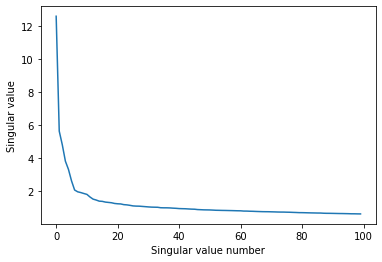

In [112]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(s[::-1])
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()

In [114]:
u, s, v_trans = svds(tfidf_mat, k=20)
v = v_trans.T